## ⚙️ Import Libraries

In [66]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


## ⏳ Load the Data (no outlier)

In [67]:
from sklearn.model_selection import train_test_split
import numpy as np
data = np.load("/kaggle/input/cleean-data/cleaned_data.npz")

X_train = data["training_set_filtered"]

y_train = data["masks_filtered"]

X_test = data["test_set"]
print(y_train[0].shape)
print(f"Test X shape: {X_test.shape}")

# Perform train-validation split (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

(64, 128)
Test X shape: (10022, 64, 128)
Train set: (2004, 64, 128), (2004, 64, 128)
Validation set: (501, 64, 128), (501, 64, 128)


### Outliers removed

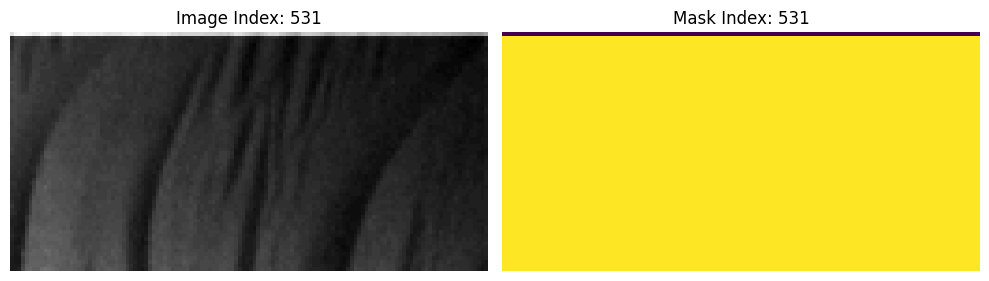

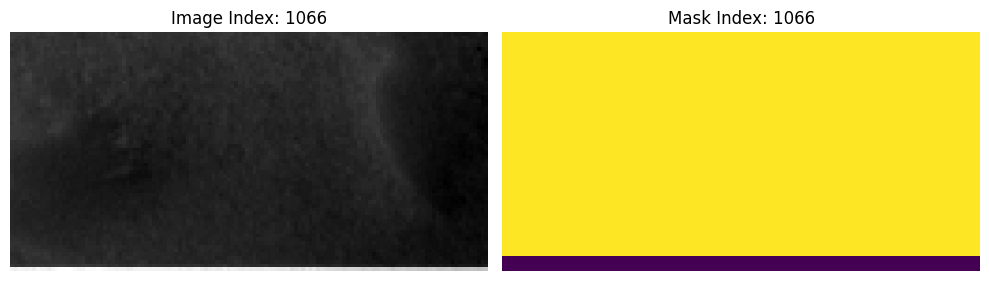

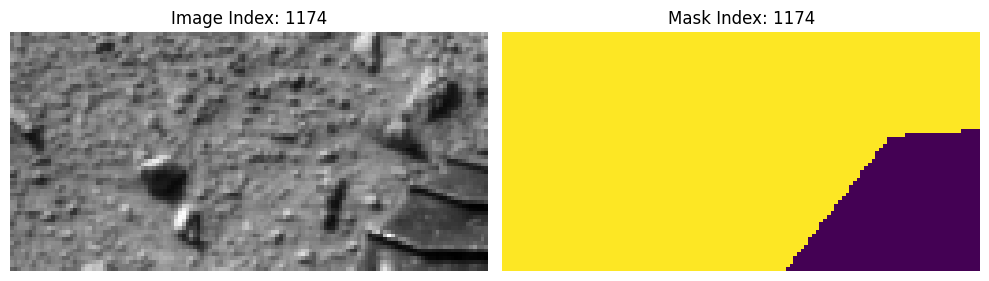

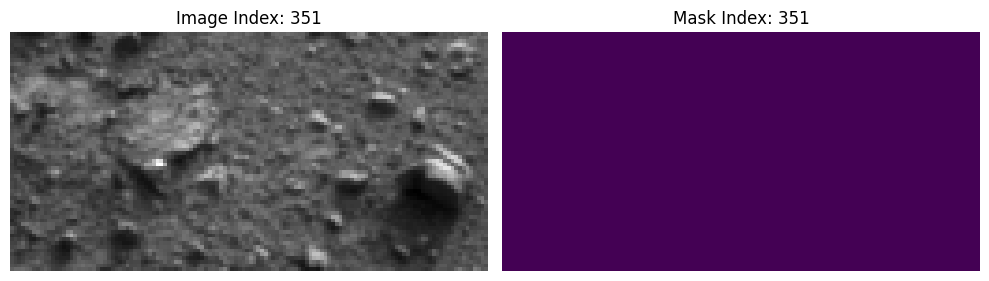

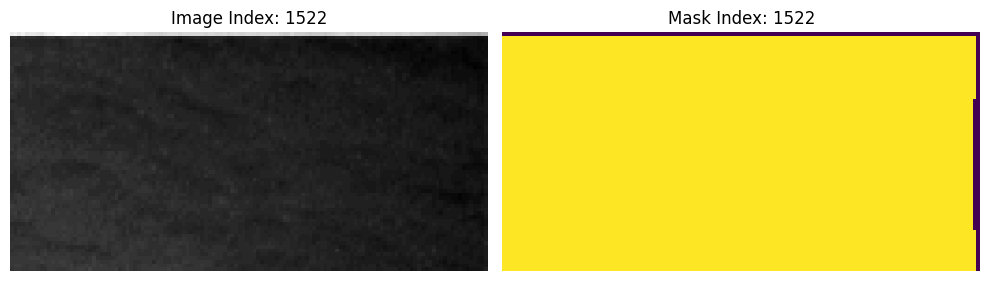

In [68]:
import random

# Visualize random image-mask pairs
for _ in range(5):
    idx = random.randint(0, len(X_train) - 1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display input image
    ax[0].imshow(X_train[idx], cmap="gray")
    ax[0].set_title(f"Image Index: {idx}")
    ax[0].axis("off")

    # Display corresponding mask
    ax[1].imshow(y_train[idx], cmap="viridis")
    ax[1].set_title(f"Mask Index: {idx}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

## LETS DO SOME AUGMENTATION!!

## invert image and noise

/tmp/ipykernel_23/1632159539.py:66: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(images), 6, i * 6 + 3)
/tmp/ipykernel_23/1632159539.py:88: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


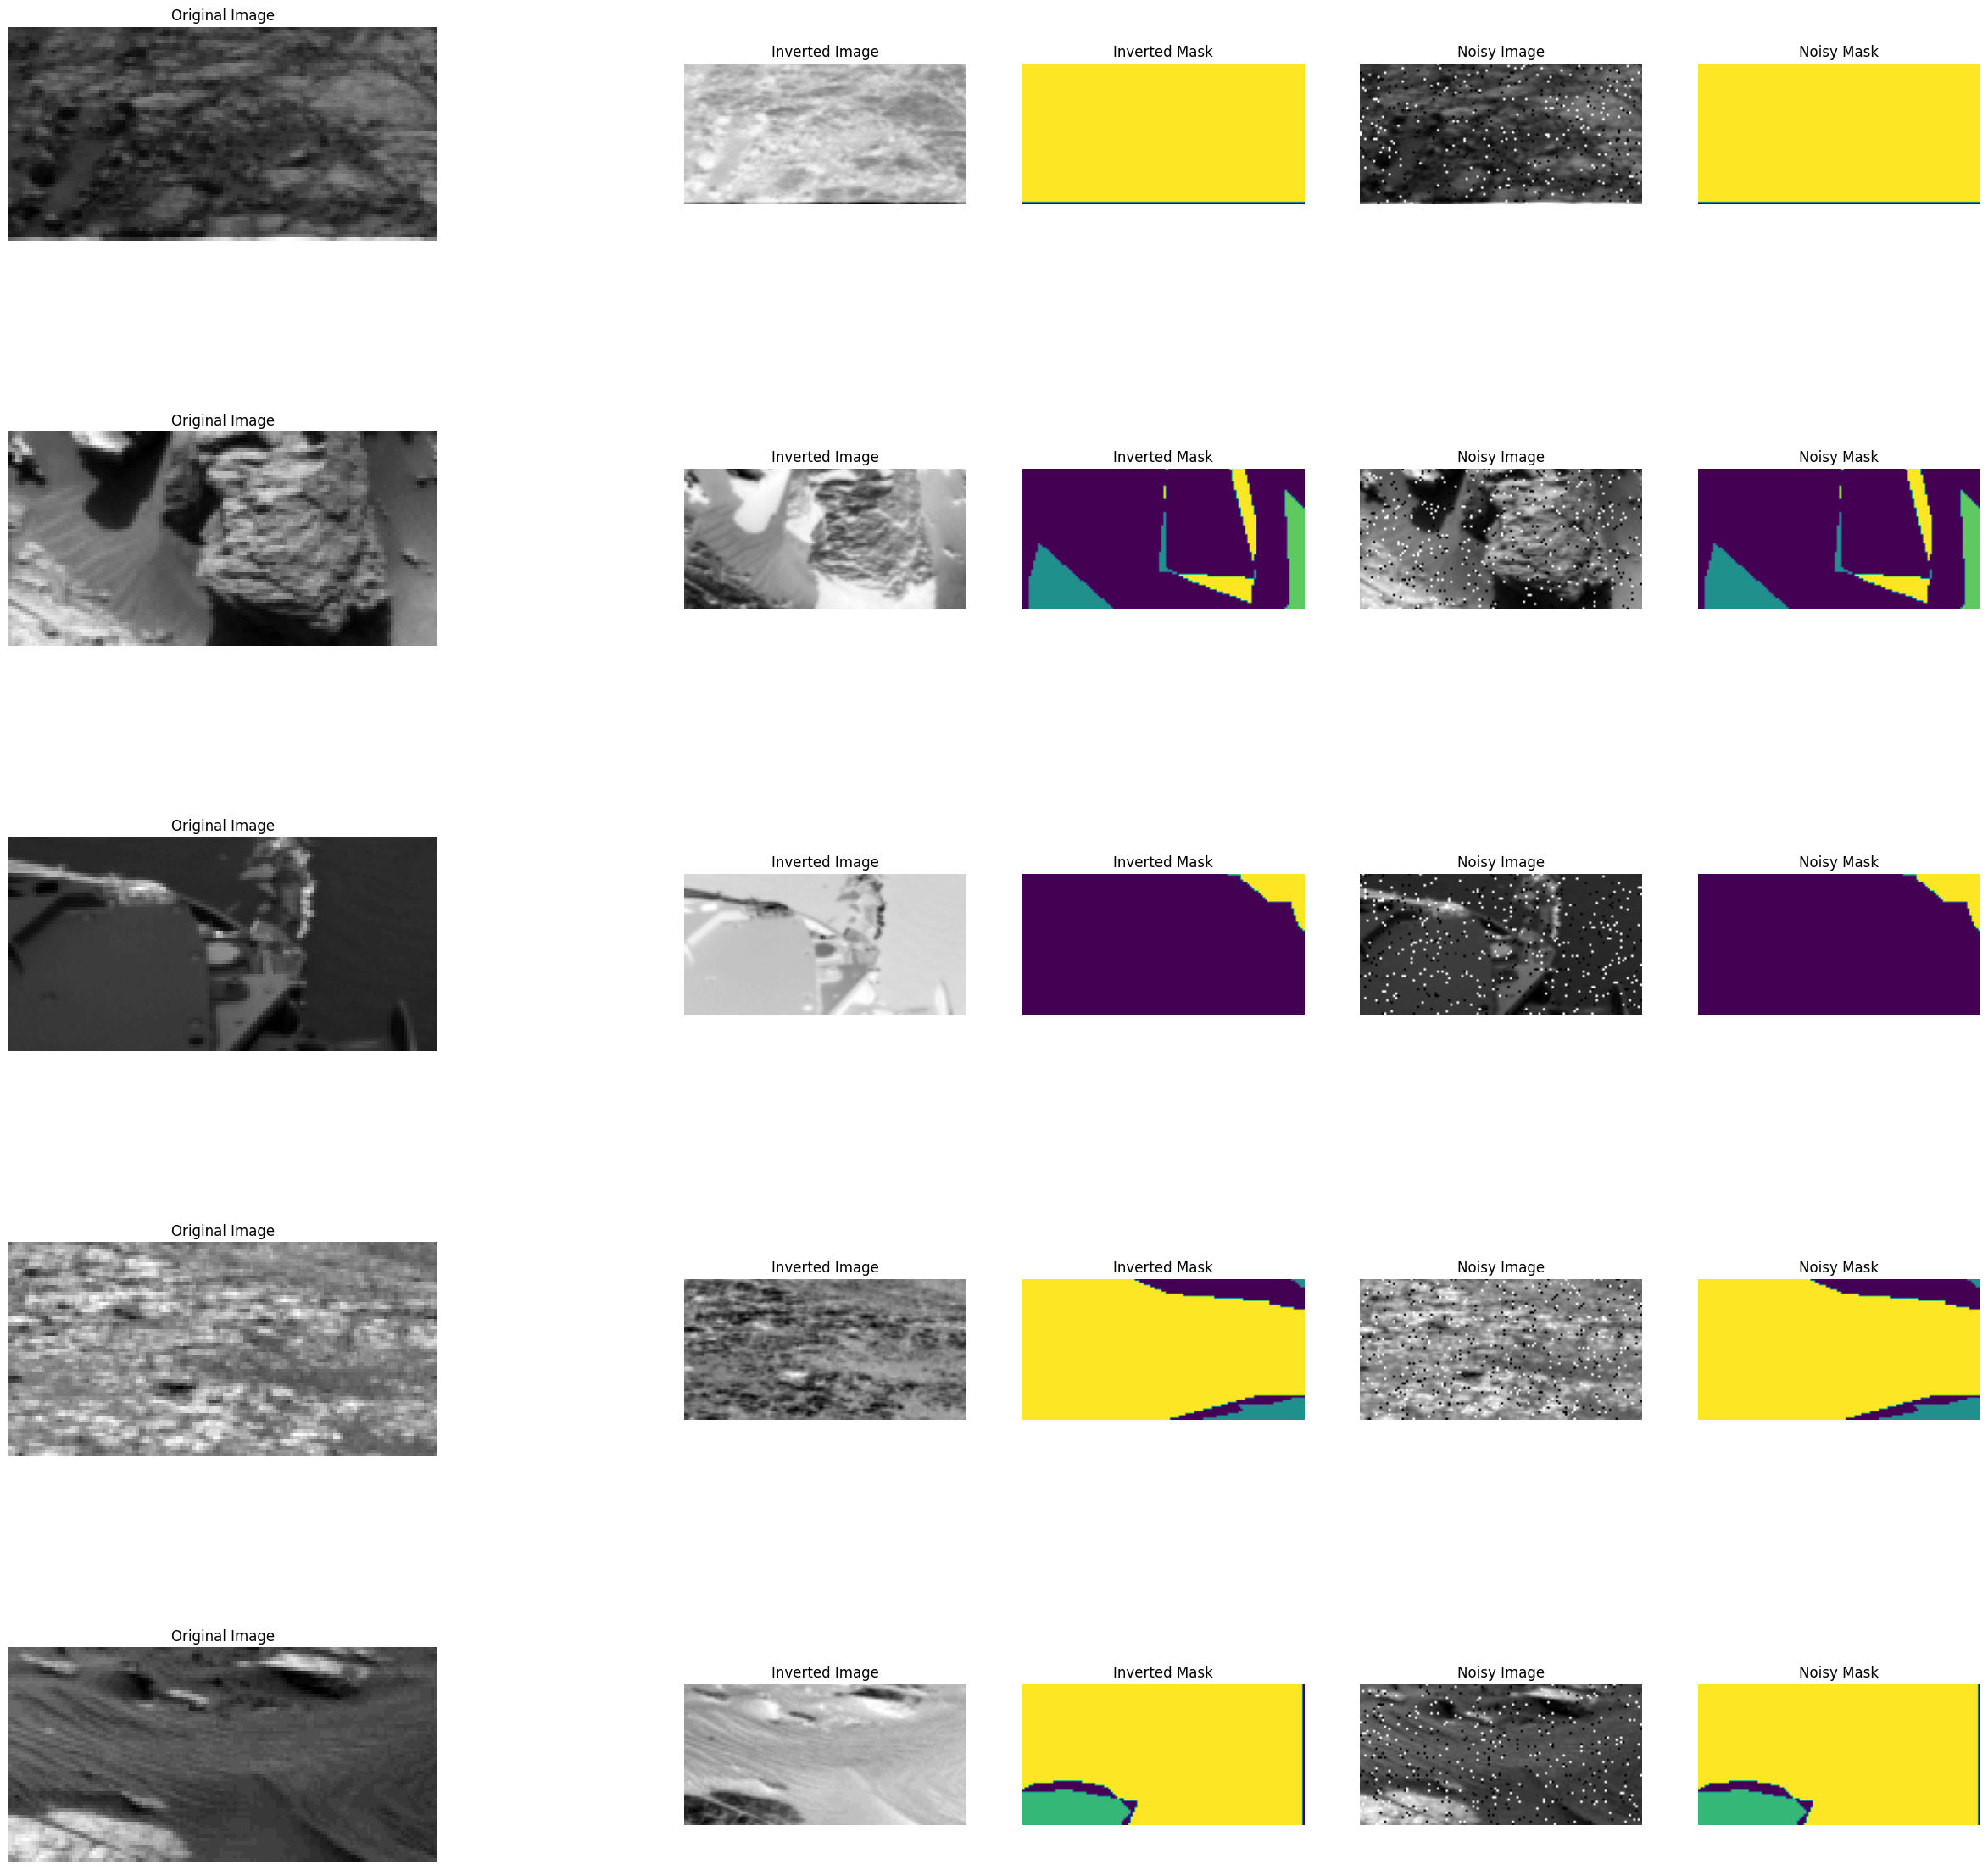

In [69]:


import numpy as np
from skimage.util import random_noise

# Define augmentation functions with mask handling
def invert_image(image, mask):
    return 255 - image, mask  # Mask remains unchanged

def add_salt_and_pepper_noise(image, mask, prob=0.03):
    """
    Add salt-and-pepper noise to an image while maintaining its original value range.

    Args:
        image (np.ndarray): Input image.
        mask (np.ndarray): Corresponding mask (unchanged).
        prob (float): Probability of noise per pixel.

    Returns:
        noisy_image (np.ndarray): Image with noise applied.
        mask (np.ndarray): Unchanged mask.
    """
    # Save the original range
    original_min = image.min()
    original_max = image.max()

    # Normalize the image to [0, 1]
    normalized_image = (image - original_min) / (original_max - original_min)

    # Generate random noise map
    random_map = np.random.random(image.shape)
    noisy_image = normalized_image.copy()
    noisy_image[random_map < prob] = 0  # Pepper
    noisy_image[random_map > (1 - prob)] = 1  # Salt

    # Rescale back to the original range
    noisy_image = noisy_image * (original_max - original_min) + original_min
    noisy_image = noisy_image.astype(image.dtype)  # Ensure the original data type is preserved

    return noisy_image, mask

"""def rotate_image(image, mask, angle):
    rotated_image = rotate(image, angle, reshape=False, mode='constant', cval=0)
    rotated_mask = rotate(mask, angle, reshape=False, mode='constant', order=0)
    return rotated_image, rotated_mask"""
"""
def adjust_brightness(image, mask, factor=1.2):
    brightened_image = np.clip(image * factor, 0, 255).astype(np.uint8)
    return brightened_image, mask  # Mask remains unchanged"""

# Visualize augmentations with masks
def visualize_all_augmentations(images, masks):
    plt.figure(figsize=(30, 30))
    for i, (image, mask) in enumerate(zip(images, masks)):
        # Original image and mask
        plt.subplot(len(images), 4, i * 4 + 1)
        plt.imshow(image, cmap="gray")
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(len(images), 4, i * 4 + 2)
        plt.imshow(mask, cmap="viridis")
        plt.title("Original Mask")
        plt.axis("off")

        # Inversion
        inverted_image, inverted_mask = invert_image(image, mask)
        plt.subplot(len(images), 6, i * 6 + 3)
        plt.imshow(inverted_image, cmap="gray")
        plt.title("Inverted Image")
        plt.axis("off")

        plt.subplot(len(images), 6, i * 6 + 4)
        plt.imshow(inverted_mask, cmap="viridis")
        plt.title("Inverted Mask")
        plt.axis("off")

        # Noise
        noisy_image, noisy_mask = add_salt_and_pepper_noise(image, mask)
        plt.subplot(len(images), 6, i * 6 + 5)
        plt.imshow(noisy_image, cmap="gray")
        plt.title("Noisy Image")
        plt.axis("off")

        plt.subplot(len(images), 6, i * 6 + 6)
        plt.imshow(noisy_mask, cmap="viridis")
        plt.title("Noisy Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Randomly select 5 samples from the dataset
random_indices = np.random.choice(len(X_train), size=5, replace=False)
sample_images = X_train[random_indices]
sample_masks = y_train[random_indices]

# Visualize augmentations
visualize_all_augmentations(sample_images, sample_masks)


### rotation

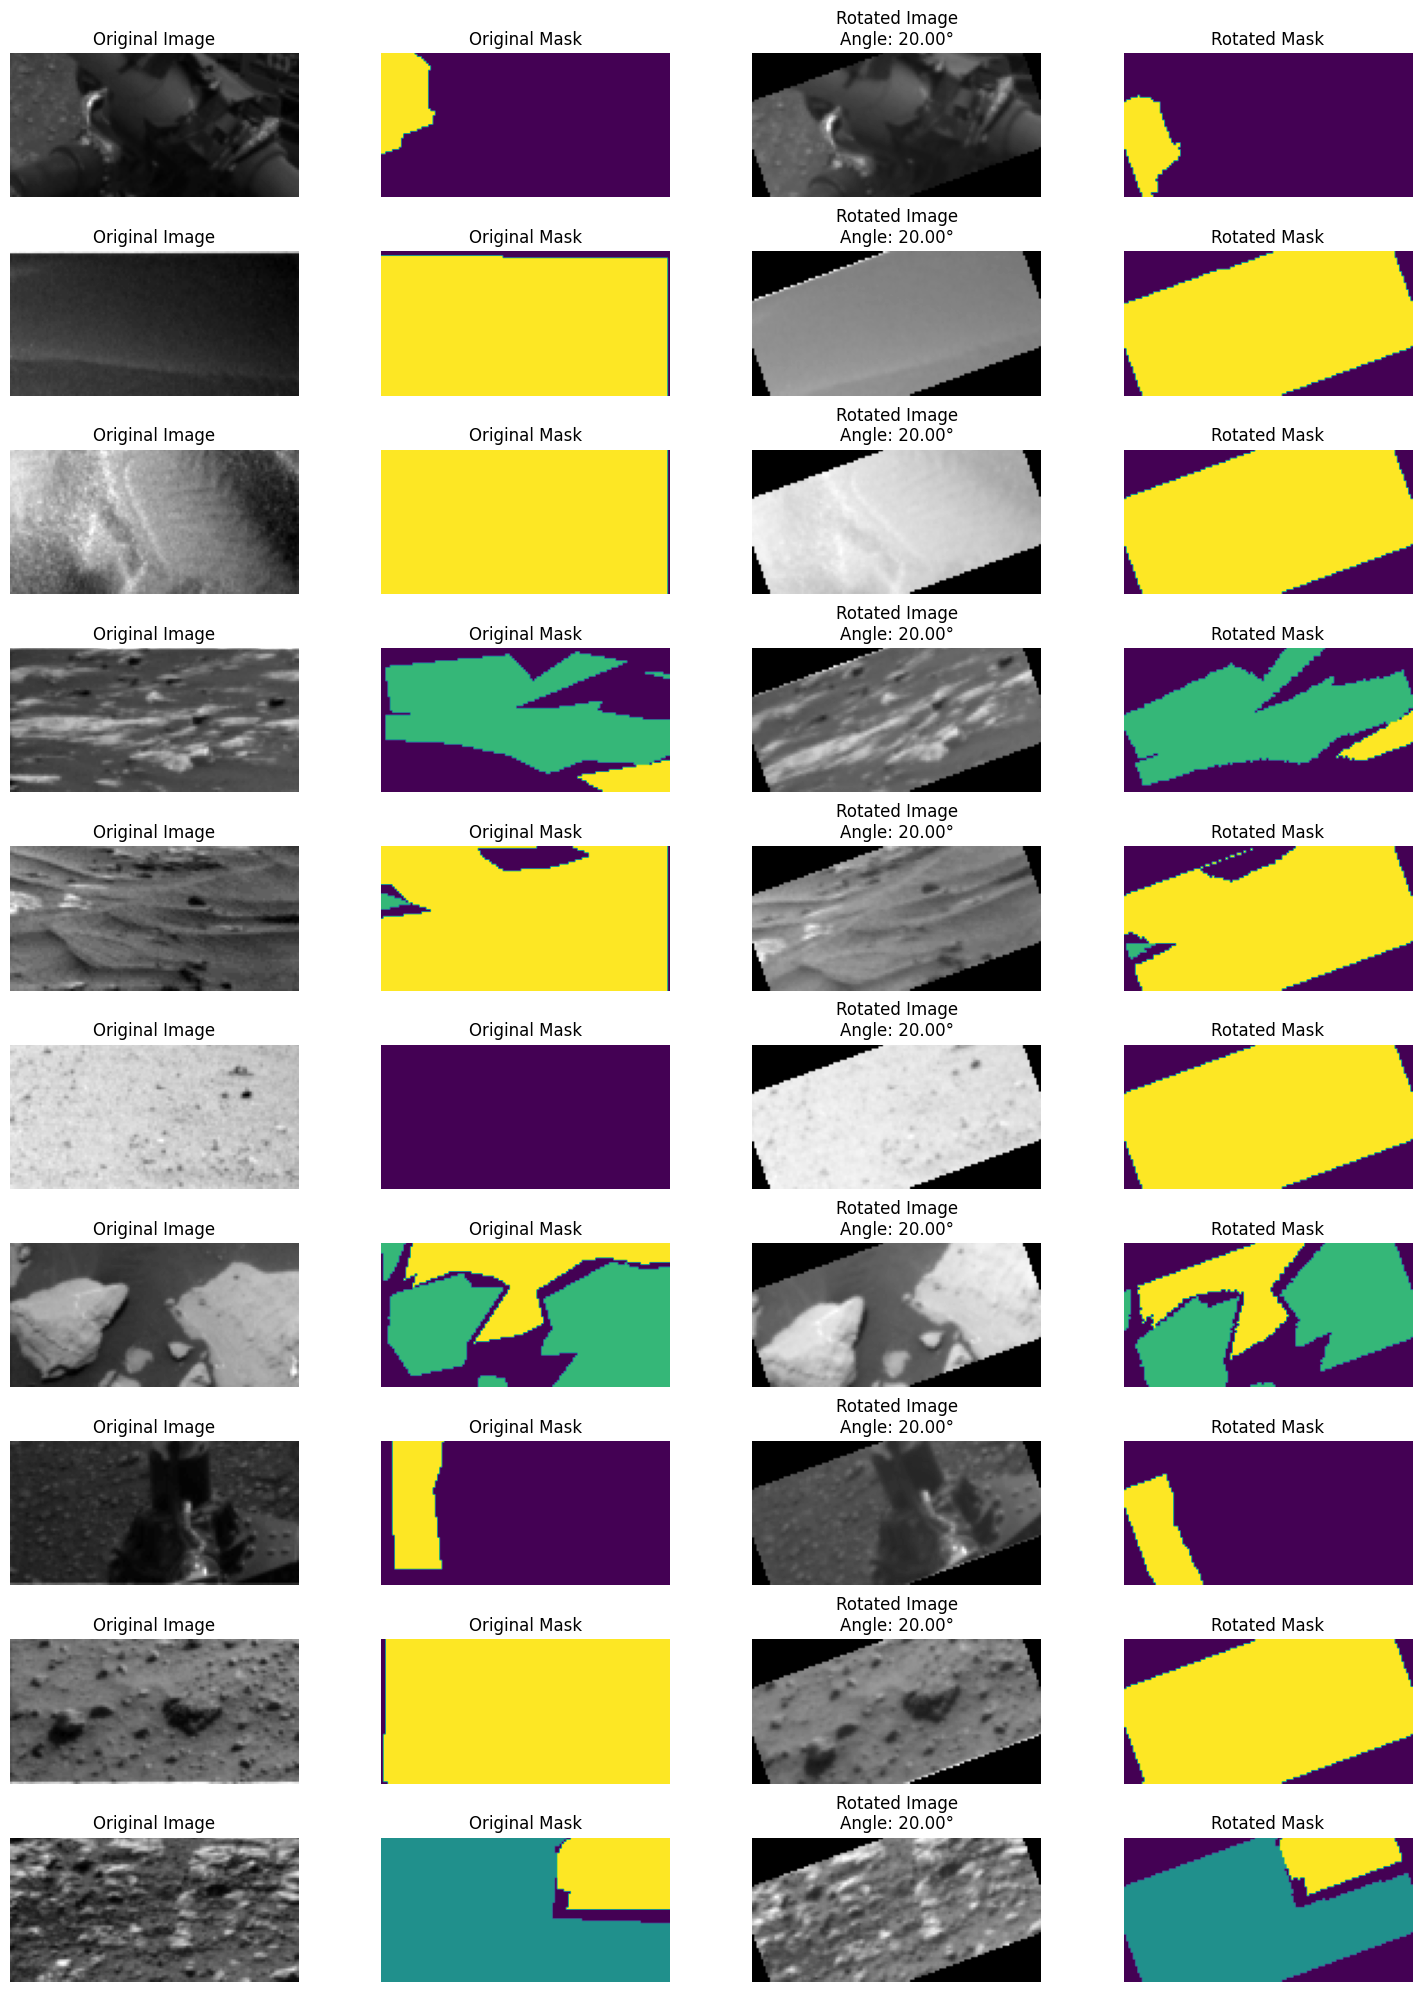

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

# Define the rotation function using scipy
def rotate_image_and_mask(image, mask, angle):
    """
    Rotate a grayscale image and its corresponding mask by a given angle.
    """
    # Rotate the grayscale image (bilinear interpolation)
    rotated_image = rotate(image, angle, reshape=False, mode="constant", order=1)

    # Rotate the mask (nearest-neighbor interpolation)
    rotated_mask = rotate(mask, angle, reshape=False, mode="constant", order=0)

    return rotated_image, rotated_mask

# Randomly select 10 images
random_indices = np.random.choice(len(X_train), size=10, replace=False)
selected_images = X_train[random_indices]
selected_masks = y_train[random_indices]

# Apply random rotation and visualize
plt.figure(figsize=(15, 20))
for i, (image, mask) in enumerate(zip(selected_images, selected_masks)):
    # Generate a random angle for rotation
    angle = np.random.uniform(20, 20)  # Random angle between -30° and 30°

    # Rotate the image and mask
    rotated_image, rotated_mask = rotate_image_and_mask(image, mask, angle)

    # Plot original and rotated images/masks
    plt.subplot(10, 4, i * 4 + 1)
    plt.imshow(image, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 2)
    plt.imshow(mask, cmap="viridis")
    plt.title("Original Mask")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 3)
    plt.imshow(rotated_image, cmap="gray")
    plt.title(f"Rotated Image\nAngle: {angle:.2f}°")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 4)
    plt.imshow(rotated_mask, cmap="viridis")
    plt.title("Rotated Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


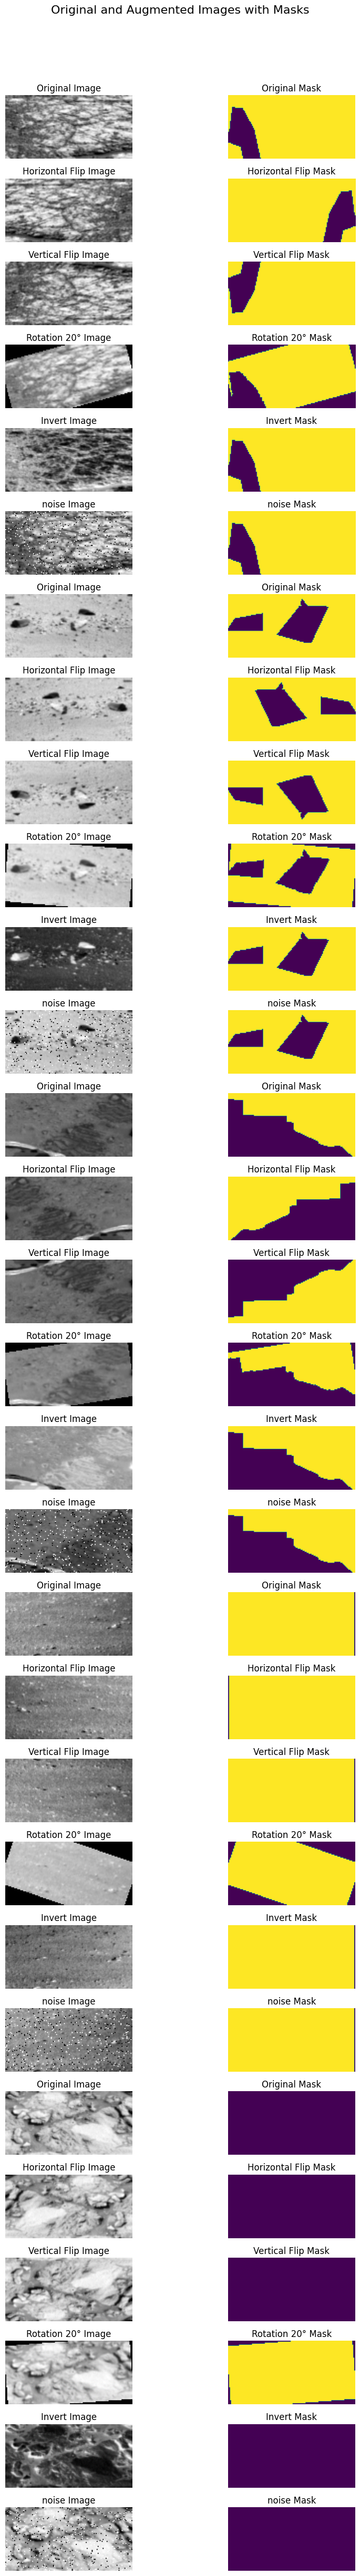

In [71]:
# Helper functions for applying augmentations
def augment_image_and_mask(image, mask, augment_type):
    if augment_type == "Horizontal Flip":
        return np.fliplr(image), np.fliplr(mask)
    elif augment_type == "Vertical Flip":
        return np.flipud(image), np.flipud(mask)
    elif augment_type == "Rotation 20°":
        angle = np.random.uniform(-20, 20)
        # Rotate the grayscale image (bilinear interpolation)
        rotated_image = rotate(image, angle, reshape=False, mode="constant", order=1)

        # Rotate the mask (nearest-neighbor interpolation)
        rotated_mask = rotate(mask, angle, reshape=False, mode="constant", order=0)

        return rotated_image, rotated_mask
    elif augment_type=="Invert":
        inverted_image, inverted_mask = invert_image(image, mask)
        return inverted_image,inverted_mask
    elif augment_type=="noise":
        noisy_image, noisy_mask = add_salt_and_pepper_noise(image, mask)
        return noisy_image,noisy_mask
        
    """elif augment_type == "Zoom (0.8-1.2)":
        zoom_factor = random.uniform(0.8, 1.2)
        zoom_image = np.clip(image * zoom_factor, 0, 255)
        return zoom_image, mask
    elif augment_type == "Shift (Width and Height)":
        shift_x, shift_y = random.uniform(-0.1, 0.1), random.uniform(-0.1, 0.1)
        return shift(image, [shift_x * image.shape[0], shift_y * image.shape[1]]), shift(mask, [shift_x * mask.shape[0], shift_y * mask.shape[1]], order=0)"""
    return image, mask

# Define augmentations
data_augmentations = {
    "Horizontal Flip": "Horizontal Flip",
    "Vertical Flip": "Vertical Flip",
    "Rotation 20°": "Rotation 20°",
    "Invert":"Invert",
    "noise":"noise"
    #"Zoom (0.8-1.2)": "Zoom (0.8-1.2)",
    #"Shift (Width and Height)": "Shift (Width and Height)",
}

# Visualize 5 random images and masks with augmentations
random_indices = np.random.choice(len(X_train), size=5, replace=False)
# Adjusting to display original image/mask with augmentations below each
fig, axes = plt.subplots(len(random_indices) * (1 + len(data_augmentations)), 2, figsize=(10, 50))
fig.suptitle("Original and Augmented Images with Masks", fontsize=16)

for idx, random_idx in enumerate(random_indices):
    original_image = X_train[random_idx]
    original_mask = y_train[random_idx]

    # Plot original image and mask
    row = idx * (1 + len(data_augmentations))  # Calculate starting row for each original image
    axes[row, 0].imshow(original_image, cmap='gray')
    axes[row, 0].set_title("Original Image")
    axes[row, 0].axis('off')

    axes[row, 1].imshow(original_mask)
    axes[row, 1].set_title("Original Mask")
    axes[row, 1].axis('off')

    # Apply augmentations and plot augmented images and masks
    for aug_idx, (augmentation_name, augment_type) in enumerate(data_augmentations.items()):
        augmented_image, augmented_mask = augment_image_and_mask(original_image, original_mask, augment_type)

        axes[row + aug_idx + 1, 0].imshow(augmented_image , cmap='gray' )
        axes[row + aug_idx + 1, 0].set_title(f"{augmentation_name} Image")
        axes[row + aug_idx + 1, 0].axis('off')

        axes[row + aug_idx + 1, 1].imshow(augmented_mask)
        axes[row + aug_idx + 1, 1].set_title(f"{augmentation_name} Mask")
        axes[row + aug_idx + 1, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 🛠️ Train and Save the Model

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
# Function to split and resize an image and its mask
def split_and_resize(image, mask, target_size):
    """
    Splits an image and mask into four quadrants and resizes them to the target size.

    Args:
        image (ndarray): Input image.
        mask (ndarray): Corresponding mask.
        target_size (tuple): Desired size (height, width) for the output quadrants.

    Returns:
        list: List of tuples (quadrant_image, quadrant_mask).
    """
    h, w = image.shape
    half_h, half_w = h // 2, w // 2

    quadrants = [
        (resize(image[:half_h, :half_w], target_size, mode="constant"),
         resize(mask[:half_h, :half_w], target_size, mode="constant", order=0)),
        (resize(image[:half_h, half_w:], target_size, mode="constant"),
         resize(mask[:half_h, half_w:], target_size, mode="constant", order=0)),
        (resize(image[half_h:, :half_w], target_size, mode="constant"),
         resize(mask[half_h:, :half_w], target_size, mode="constant", order=0)),
        (resize(image[half_h:, half_w:], target_size, mode="constant"),
         resize(mask[half_h:, half_w:], target_size, mode="constant", order=0)),
    ]
    return quadrants

In [74]:
from skimage.transform import resize
# Oversampling with conditions
augmented_X = []
augmented_y = []

# Target size for consistency
target_size = (64, 128)

# Counters
processed_images = 0
class_4_only_count = 0

for i, (image, mask) in enumerate(zip(X_train, y_train)):
    if 4 in mask:  # Check if class 4 is in the mask
        class_4_pixels = np.sum(mask == 4)
        total_pixels = mask.size

        if class_4_pixels / total_pixels > 0.1:
            processed_images += 1

            # Apply all augmentations sequentially
            for _ in range(10):
                aug_image, aug_mask = augment_image_and_mask(
                    image, mask, ["Horizontal Flip", "Vertical Flip", "Noise", "Rotation 20°"]
                )
                if 4 in aug_mask:  # Add only if rare class is present
                    augmented_X.append(resize(aug_image, target_size, mode="constant"))
                    augmented_y.append(resize(aug_mask, target_size, mode="constant", order=0).round().astype(int))
                
                    class_4_only_count += 1

                    # Add split quadrants that contain the rare class
                    quadrants = split_and_resize(aug_image, aug_mask, target_size)
                    for quad_img, quad_mask in quadrants:
                        if 4 in quad_mask:  # Ensure quadrant contains class 4
                            augmented_X.append(quad_img)
                            augmented_y.append(quad_mask.round().astype(int))
                         
                            class_4_only_count += 1
                            class_4_pixels = np.sum(quad_mask == 4)
                            total_pixels = mask.size
                            if class_4_pixels / total_pixels > 0.20:
                                for i in range(5):
                                    augmented_X.append(quad_img)
                                    augmented_y.append(quad_mask.round().astype(int))
                                 
                                    class_4_only_count += 1

        else:
            processed_images += 1
            for _ in range(3):
                aug_image, aug_mask = augment_image_and_mask(image, mask, ["Horizontal Flip", "Invert"])
                if 4 in aug_mask:  # Add only if rare class is present
                    augmented_X.append(resize(aug_image, target_size, mode="constant"))
                    augmented_y.append(resize(aug_mask, target_size, mode="constant", order=0).round().astype(int))
                 
                    class_4_only_count += 1

# Log results
print(f"Processed images with class 4: {processed_images}")
print(f"Generated images with only class 4: {class_4_only_count}")


Processed images with class 4: 56
Generated images with only class 4: 984


In [75]:
# Convert to numpy arrays
augmented_X = np.array(augmented_X)
augmented_y = np.array(augmented_y)



# Add original data
augmented_X = np.concatenate([X_train, augmented_X], axis=0)
augmented_y = np.concatenate([y_train, augmented_y], axis=0)

# Save augmented dataset
np.savez_compressed("augmented_dataset.npz", X=augmented_X, y=augmented_y)

In [76]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_dataset.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["X"]
augmented_masks = rotation_data["y"]

# Merge with original X_train and y_train
X_train = augmented_images
y_train = augmented_masks

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (2988, 64, 128)
New y_train shape: (2988, 64, 128)


total number of images 1040 out of 2988 images: percentage 34.805890227576974 %
Class Percentages:
Class 0.0: 30.56%
Class 1.0: 23.60%
Class 2.0: 18.26%
Class 3.0: 16.96%
Class 4.0: 10.62%


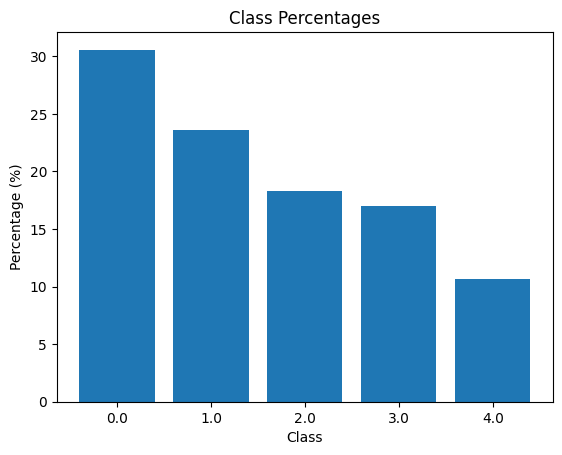

In [77]:
import numpy as np
import matplotlib.pyplot as plt



# Filter only the images with the rare class (class 4)
rare_class = 4
rare_class_indices = [i for i in range(len(y_train)) if rare_class in y_train[i]]
print("total number of images",len(rare_class_indices ),"out of",len(y_train),"images: percentage", 100*len(rare_class_indices )/len(y_train),"%")
# Extract images and masks containing the rare class
X_train_rare = X_train
y_train_rare = y_train

# Calculate the percentage of each class in the rare class masks
unique_classes, class_counts = np.unique(y_train_rare, return_counts=True)
total_pixels = np.sum(class_counts)
class_percentages = {cls: count / total_pixels * 100 for cls, count in zip(unique_classes, class_counts)}

# Print the percentages
print("Class Percentages:")
for cls, pct in class_percentages.items():
    print(f"Class {cls}: {pct:.2f}%")

# Plot histogram of class percentages
plt.bar(class_percentages.keys(), class_percentages.values(), tick_label=list(class_percentages.keys()))
plt.xlabel("Class")
plt.ylabel("Percentage (%)")
plt.title("Class Percentages")
plt.show()


In [78]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [79]:
X_val = X_val[..., np.newaxis] / 255.0

In [80]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (2988, 64, 128, 1)
X_val shape: (501, 64, 128, 1)
y_train shape: (2988, 64, 128)


In [81]:
# Custom callback for visualization
class VisualizeSegmentationCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, num_images=2):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.num_images = num_images
        self.selected_indices = []

        # Identify images containing at least 4 classes
        for i in range(len(y_train)):
            if len(np.unique(y_train[i])) >= 4:  # Check for at least 4 classes
                self.selected_indices.append(i)
            if len(self.selected_indices) == num_images:
                break

    def on_epoch_end(self, epoch, logs=None):
        # Plot predictions for the selected images
        fig, axes = plt.subplots(self.num_images, 3, figsize=(15, self.num_images * 5))

        for idx, i in enumerate(self.selected_indices):
            # Extract image and ground truth
            X_sample = self.X_train[i:i + 1]  # Add batch dimension
            y_sample = self.y_train[i]

            # Predict on the image
            predicted_mask = self.model.predict(X_sample)
            predicted_mask = np.argmax(predicted_mask, axis=-1)[0]  # Convert to class labels

            # Visualize the input, ground truth, and predicted mask
            axes[idx, 0].imshow(X_sample[0].squeeze(), cmap="gray")
            axes[idx, 0].set_title("Input Image")
            axes[idx, 0].axis("off")

            axes[idx, 1].imshow(y_sample, cmap="viridis",vmin=0,vmax=4)
            axes[idx, 1].set_title("Ground Truth Mask")
            axes[idx, 1].axis("off")

            axes[idx, 2].imshow(predicted_mask, cmap="viridis",vmin=0,vmax=4)
            axes[idx, 2].set_title(f"Predicted Mask (Epoch {epoch + 1})")
            axes[idx, 2].axis("off")

        plt.tight_layout()
        plt.show()

## Adding advanced tecnics

In [82]:
# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove any singleton dimensions
y_train = np.squeeze(y_train)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

if y_train.ndim == 3:  # Ensure y_train has the correct shape
    y_train = y_train[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

Shape of X_train after reshaping: (2988, 64, 128, 1)
Shape of y_train after reshaping: (2988, 64, 128, 1)


In [83]:
# Ensure the input shape for both images and masks is correct
X_val = np.squeeze(X_val)  # Remove any singleton dimensions
y_val= np.squeeze(y_val)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_val.ndim == 3:  # If missing the channel dimension, add it
    X_val = X_val[..., np.newaxis]

if y_val.ndim == 3:  # Ensure y_train has the correct shape
    y_val = y_val[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_val.shape}")
print(f"Shape of y_train after reshaping: {y_val.shape}")

Shape of X_train after reshaping: (501, 64, 128, 1)
Shape of y_train after reshaping: (501, 64, 128, 1)


In [84]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove singleton dimensions
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

y_train = np.squeeze(y_train)  # Ensure that y_train has the correct shape

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

# Convert y_train to integers for class count
y_train_int = y_train.astype(np.int32)

# Calculate class weights based on pixel proportions
class_pixel_counts = np.bincount(y_train_int.flatten(), minlength=num_classes)  # Count pixels for each class
total_pixels = np.sum(class_pixel_counts)  # Total number of pixels
class_weights = total_pixels / (class_pixel_counts + 1e-6)  # Inverse frequency
class_weights /= np.sum(class_weights)  # Normalize to sum to 1

print(f"Class pixel counts: {class_pixel_counts}")
print(f"Calculated class weights: {class_weights}")

# Updated EarlyStopping with min_delta to ignore minimal improvements
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor loss instead of validation loss
    patience=30,
    restore_best_weights=True,
    min_delta=1e-4  # Minimum change to qualify as an improvement
)


model_checkpoint = ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_loss",  # Monitor loss instead of validation loss
    save_best_only=True,
    mode="min",
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor loss instead of validation loss
    factor=0.5,
    patience=5,
    verbose=1,
    mode="min",
    min_lr=1e-6
)

# Visualization Callback for Two Images with At Least 4 Classes
visualize_callback = VisualizeSegmentationCallback(X_val, y_val, num_images=2)




Shape of X_train after reshaping: (2988, 64, 128, 1)
Shape of y_train after reshaping: (2988, 64, 128)
Class pixel counts: [7481540 5776987 4469768 4150351 2599050]
Calculated class weights: [0.11560608 0.14971671 0.19350255 0.20839479 0.33277987]


In [85]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [86]:
from tensorflow.keras.callbacks import Callback
class SaveBestMeanIoU(Callback):
    def __init__(self, filepath, monitor="val_mean_io_u", mode="max", verbose=1):
        super(SaveBestMeanIoU, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.verbose = verbose
        self.best = -float("inf") if mode == "max" else float("inf")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Debug: Print available keys in logs
        print(f"Available log keys: {logs.keys()}")
        
        # Use the correct log key
        current = logs.get(self.monitor)
        if current is None:
            if self.verbose > 0:
                print(f"Warning: Monitor '{self.monitor}' is not available in logs.")
            return

        if (self.mode == "max" and current > self.best) or (self.mode == "min" and current < self.best):
            self.best = current
            if self.verbose > 0:
                print(f"Epoch {epoch + 1}: {self.monitor} improved to {current:.4f}, saving model.")
            self.model.save(self.filepath)


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_110 (Conv2D) │ (None, 64, 128,   │        640 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_111 (Conv2D) │ (None, 64, 128,   │     36,928 │ conv2d_110[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_112 (Conv2D) │ (None, 64, 128,   │        128 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_35 (Add)        │ (None, 64, 128,   │          0 │ conv2d_111[0][0], │
│                     │ 64)               │            │ conv2d_112[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 32, 64,    │          0 │ add_35[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_113 (Conv2D) │ (None, 32, 64,    │     73,856 │ max_pooling2d_15… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_114 (Conv2D) │ (None, 32, 64,    │    147,584 │ conv2d_113[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_115 (Conv2D) │ (None, 32, 64,    │      8,320 │ max_pooling2d_15… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, 32, 64,    │          0 │ conv2d_114[0][0], │
│                     │ 128)              │            │ conv2d_115[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 16, 32,    │          0 │ add_36[0][0]      │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_116 (Conv2D) │ (None, 16, 32,    │    295,168 │ max_pooling2d_16… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_117 (Conv2D) │ (None, 16, 32,    │    590,080 │ conv2d_116[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_118 (Conv2D) │ (None, 16, 32,    │     33,024 │ max_pooling2d_16… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_37 (Add)        │ (None, 16, 32,    │          0 │ conv2d_117[0][0], │
│                     │ 256)              │            │ conv2d_118[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 8, 16,     │          0 │ add_37[0][0]      │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_119 (Conv2D) │ (None, 8, 16,     │  1,180,160 │ max_pooling2d_17

 Total params: 8,041,989 (30.68 MB)

 Trainable params: 8,041,989 (30.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000


W0000 00:00:1733920177.402759     127 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.2858 - loss: 1.5616 - mean_io_u_5: 0.0605 - mean_iou: 0.0605

W0000 00:00:1733920201.491342     127 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.2862 - loss: 1.5613 - mean_io_u_5: 0.0605 - mean_iou: 0.0605

W0000 00:00:1733920224.817864     126 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733920228.149310     126 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])
Epoch 1: val_mean_iou improved to 0.0893, saving model.

Epoch 1: val_loss improved from inf to 1.40971, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


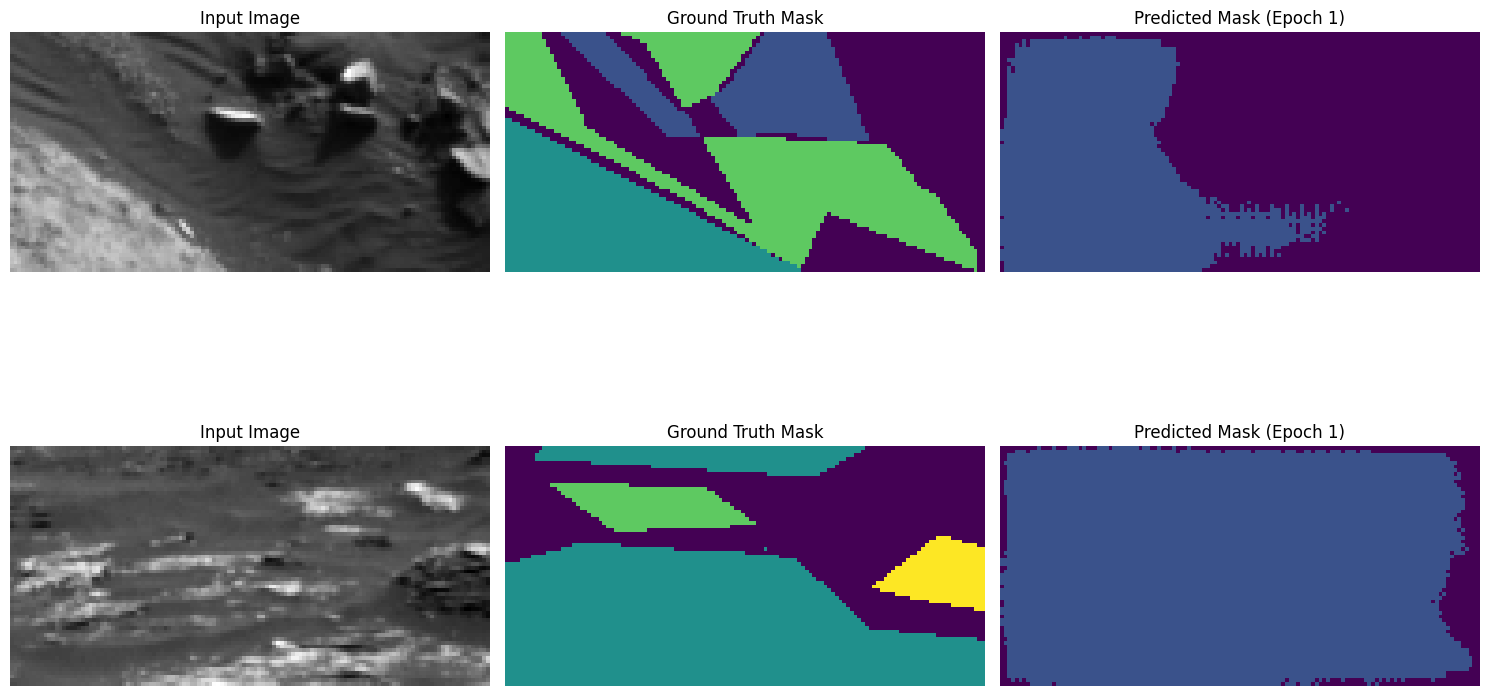

94/94 ━━━━━━━━━━━━━━━━━━━━ 62s 539ms/step - accuracy: 0.2866 - loss: 1.5609 - mean_io_u_5: 0.0604 - mean_iou: 0.0604 - val_accuracy: 0.4005 - val_loss: 1.4097 - val_mean_io_u_5: 0.0893 - val_mean_iou: 0.0893 - learning_rate: 1.0000e-04
Epoch 2/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.3705 - loss: 1.4288 - mean_io_u_5: 0.0865 - mean_iou: 0.0865Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])
Epoch 2: val_mean_iou improved to 0.1910, saving model.

Epoch 2: val_loss improved from 1.40971 to 1.26826, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


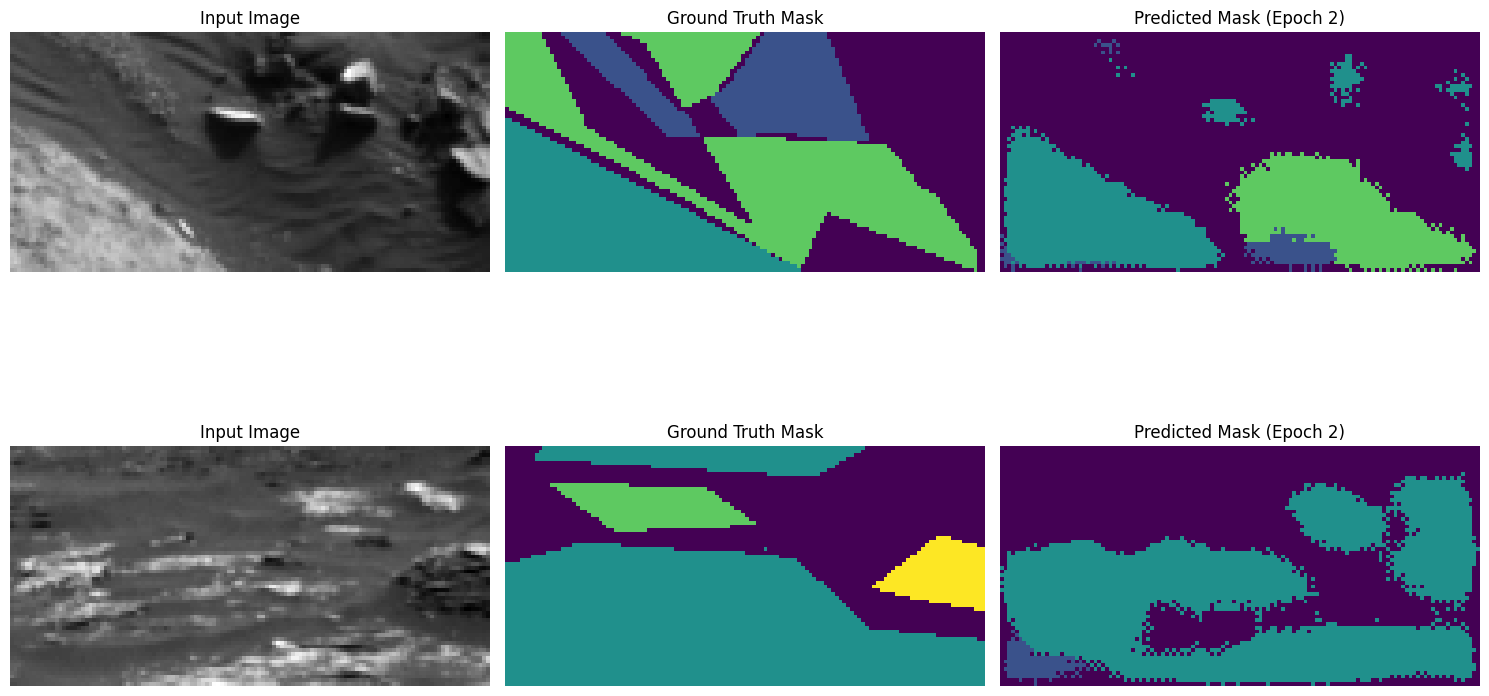

94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 229ms/step - accuracy: 0.3708 - loss: 1.4282 - mean_io_u_5: 0.0870 - mean_iou: 0.0870 - val_accuracy: 0.4333 - val_loss: 1.2683 - val_mean_io_u_5: 0.1910 - val_mean_iou: 0.1910 - learning_rate: 1.0000e-04
Epoch 3/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.5018 - loss: 1.1686 - mean_io_u_5: 0.2608 - mean_iou: 0.2608Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])
Epoch 3: val_mean_iou improved to 0.2989, saving model.

Epoch 3: val_loss improved from 1.26826 to 1.07230, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


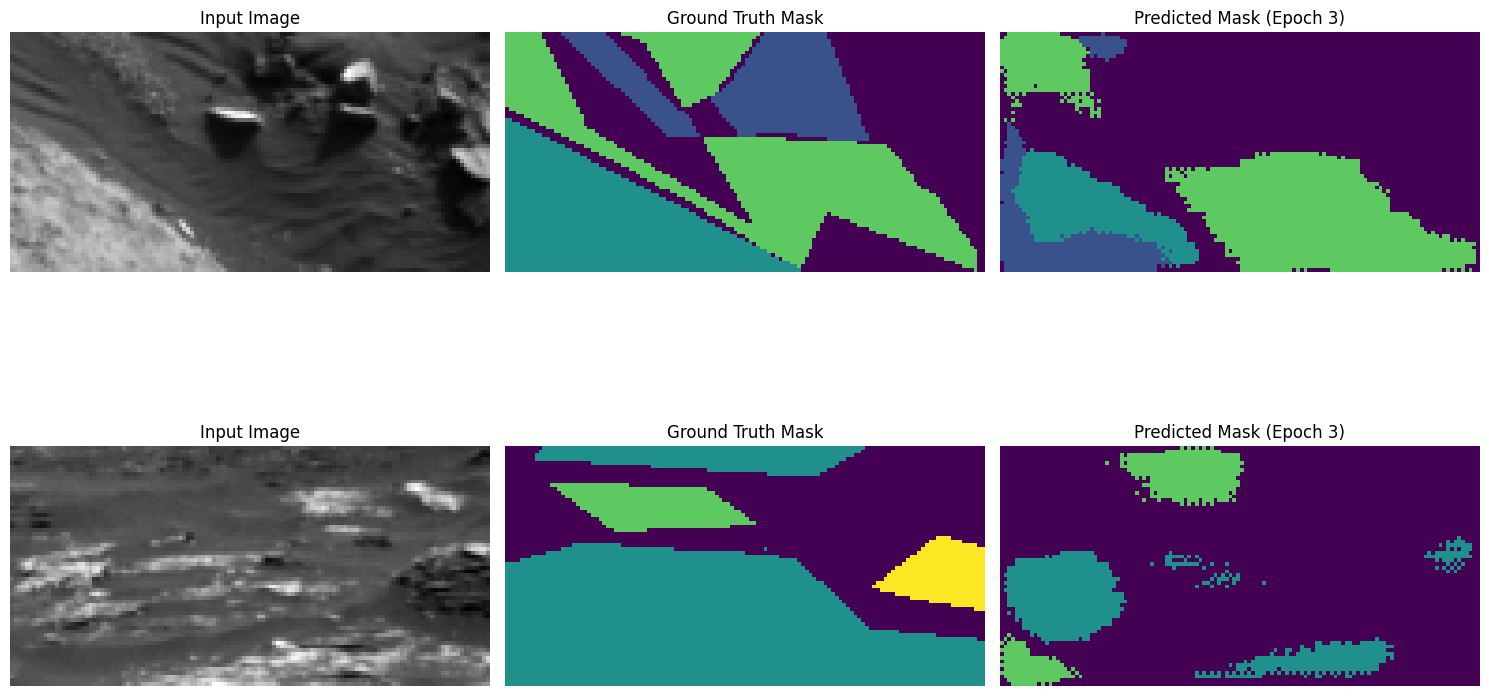

94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 237ms/step - accuracy: 0.5021 - loss: 1.1682 - mean_io_u_5: 0.2611 - mean_iou: 0.2611 - val_accuracy: 0.5935 - val_loss: 1.0723 - val_mean_io_u_5: 0.2989 - val_mean_iou: 0.2989 - learning_rate: 1.0000e-04
Epoch 4/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.5765 - loss: 1.0148 - mean_io_u_5: 0.3789 - mean_iou: 0.3789Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 4: val_loss did not improve from 1.07230
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


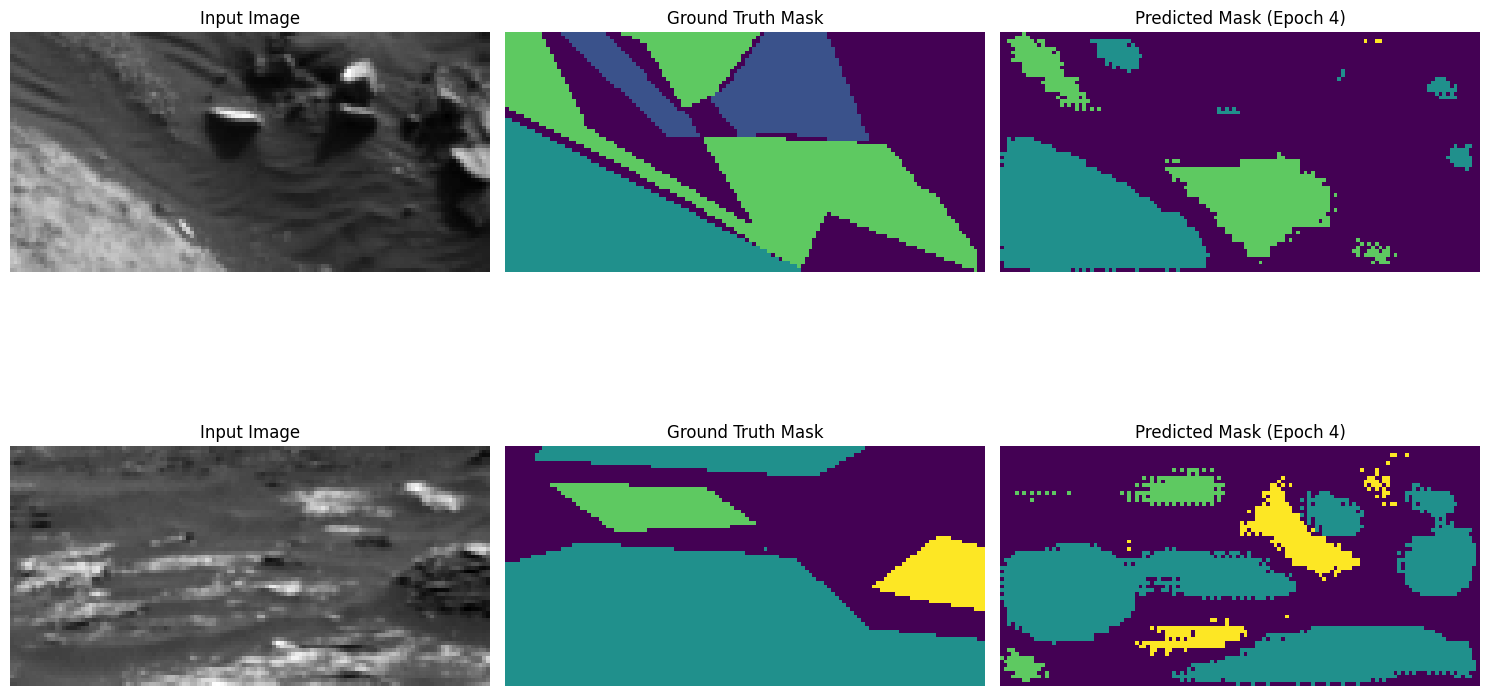

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.5765 - loss: 1.0147 - mean_io_u_5: 0.3790 - mean_iou: 0.3790 - val_accuracy: 0.5318 - val_loss: 1.1426 - val_mean_io_u_5: 0.2798 - val_mean_iou: 0.2798 - learning_rate: 1.0000e-04
Epoch 5/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.6014 - loss: 0.9543 - mean_io_u_5: 0.4366 - mean_iou: 0.4366Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 5: val_loss did not improve from 1.07230
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


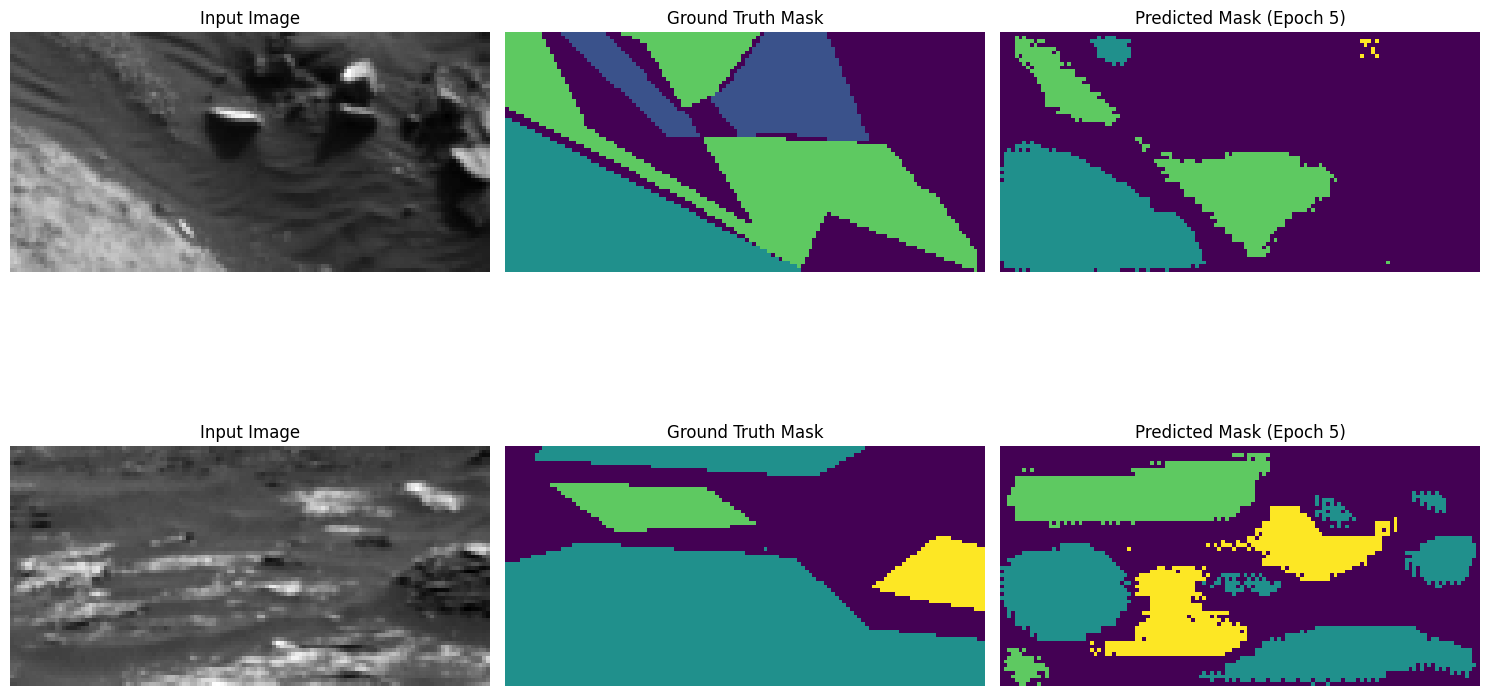

94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - accuracy: 0.6015 - loss: 0.9541 - mean_io_u_5: 0.4366 - mean_iou: 0.4366 - val_accuracy: 0.5300 - val_loss: 1.1713 - val_mean_io_u_5: 0.2762 - val_mean_iou: 0.2762 - learning_rate: 1.0000e-04
Epoch 6/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.6129 - loss: 0.9301 - mean_io_u_5: 0.4539 - mean_iou: 0.4539Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])
Epoch 6: val_mean_iou improved to 0.3373, saving model.

Epoch 6: val_loss improved from 1.07230 to 1.00468, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


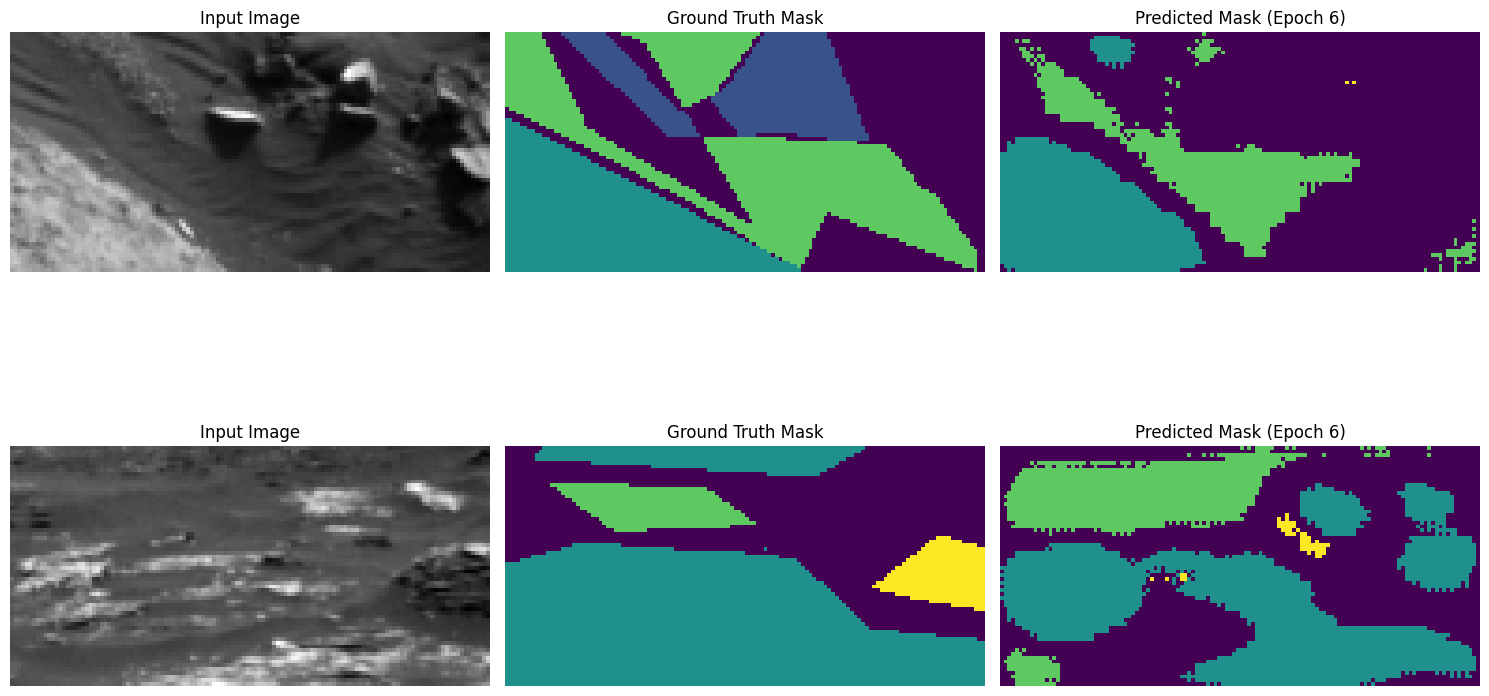

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 227ms/step - accuracy: 0.6131 - loss: 0.9297 - mean_io_u_5: 0.4541 - mean_iou: 0.4541 - val_accuracy: 0.6037 - val_loss: 1.0047 - val_mean_io_u_5: 0.3373 - val_mean_iou: 0.3373 - learning_rate: 1.0000e-04
Epoch 7/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.6516 - loss: 0.8565 - mean_io_u_5: 0.4992 - mean_iou: 0.4992Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 7: val_loss improved from 1.00468 to 1.00179, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


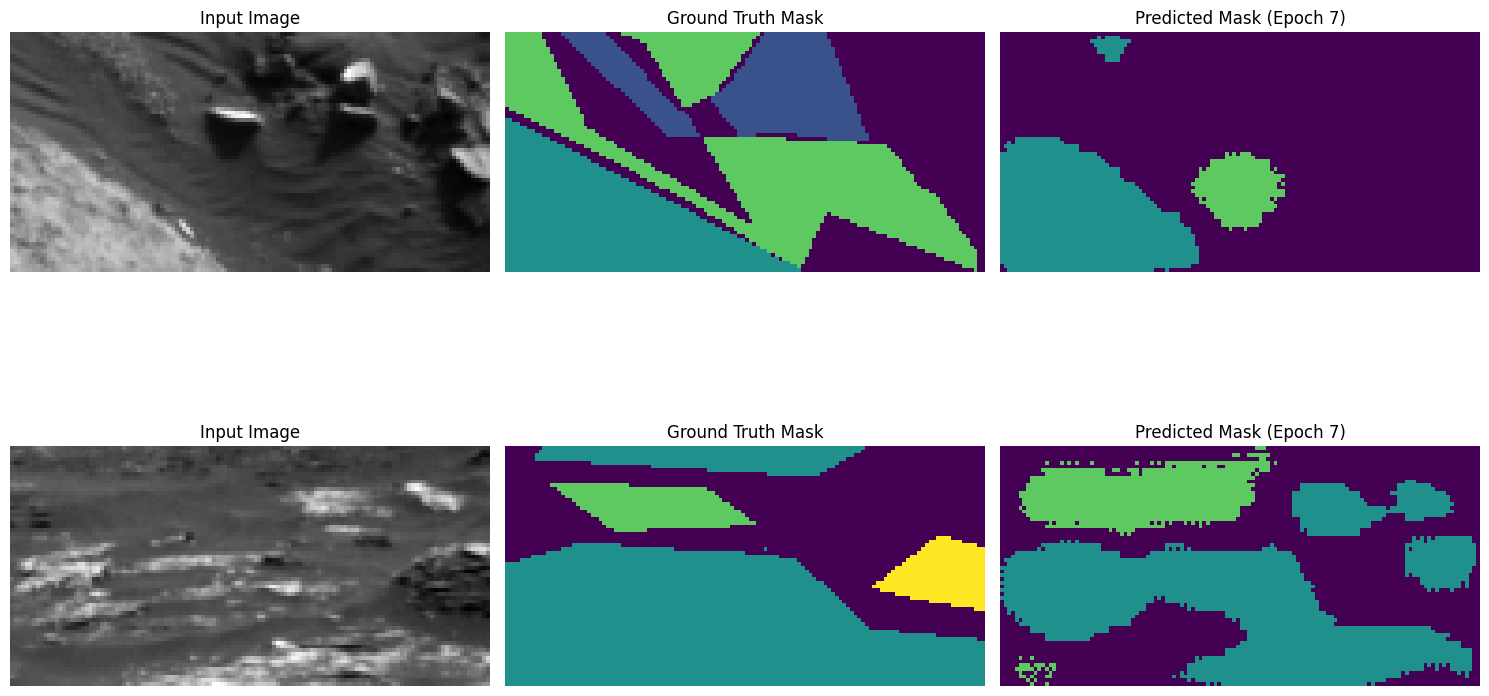

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - accuracy: 0.6517 - loss: 0.8563 - mean_io_u_5: 0.4992 - mean_iou: 0.4992 - val_accuracy: 0.6091 - val_loss: 1.0018 - val_mean_io_u_5: 0.3330 - val_mean_iou: 0.3330 - learning_rate: 1.0000e-04
Epoch 8/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.6805 - loss: 0.7983 - mean_io_u_5: 0.5256 - mean_iou: 0.5256Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])
Epoch 8: val_mean_iou improved to 0.3668, saving model.

Epoch 8: val_loss improved from 1.00179 to 0.91368, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


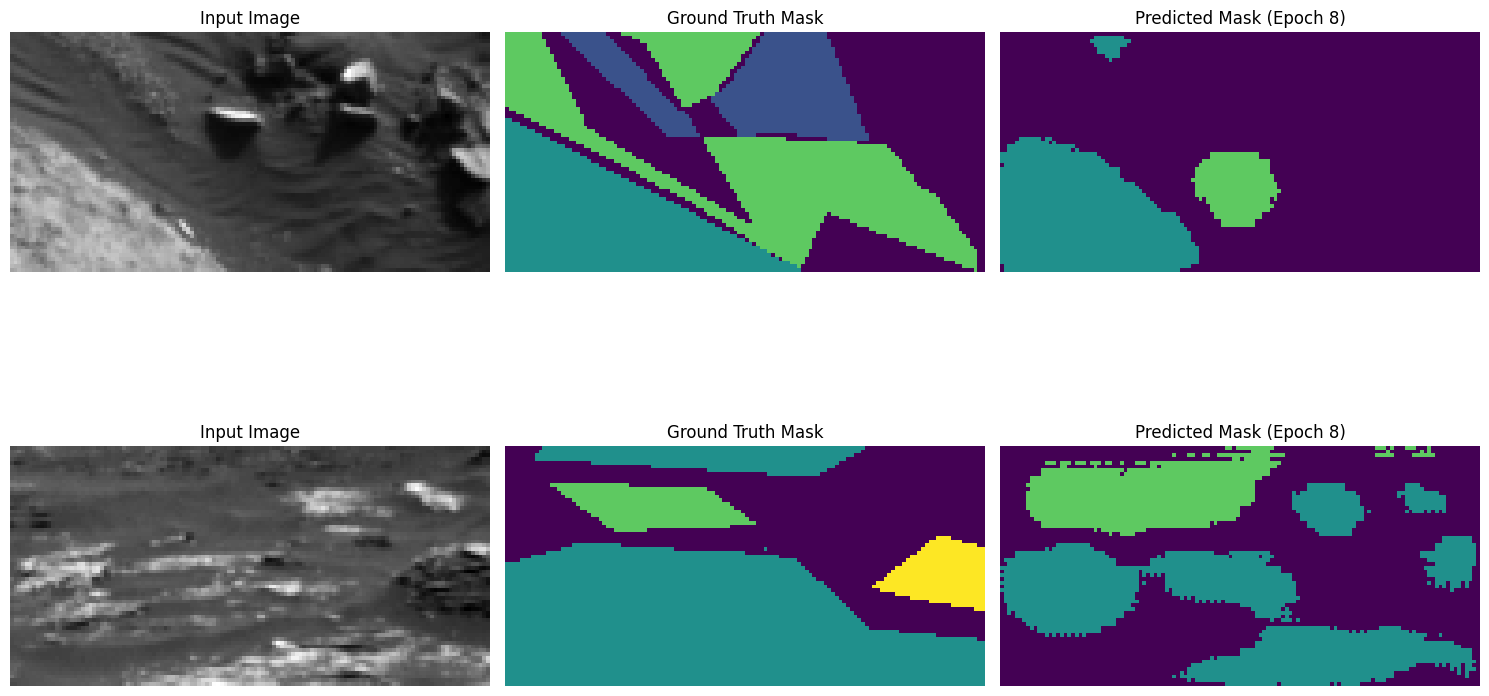

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 228ms/step - accuracy: 0.6806 - loss: 0.7981 - mean_io_u_5: 0.5256 - mean_iou: 0.5256 - val_accuracy: 0.6487 - val_loss: 0.9137 - val_mean_io_u_5: 0.3668 - val_mean_iou: 0.3668 - learning_rate: 1.0000e-04
Epoch 9/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7029 - loss: 0.7522 - mean_io_u_5: 0.5394 - mean_iou: 0.5394Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])
Epoch 9: val_mean_iou improved to 0.3797, saving model.

Epoch 9: val_loss improved from 0.91368 to 0.88734, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


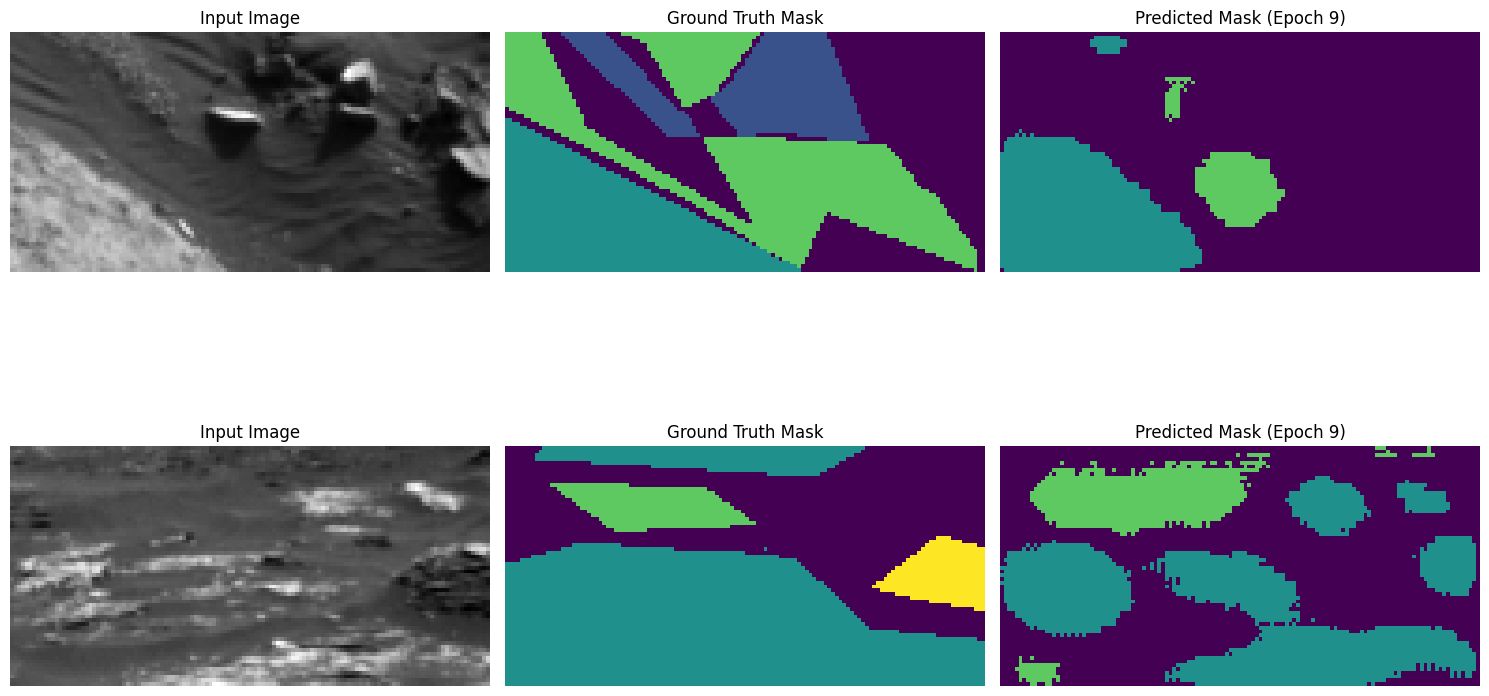

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 228ms/step - accuracy: 0.7030 - loss: 0.7522 - mean_io_u_5: 0.5395 - mean_iou: 0.5395 - val_accuracy: 0.6596 - val_loss: 0.8873 - val_mean_io_u_5: 0.3797 - val_mean_iou: 0.3797 - learning_rate: 1.0000e-04
Epoch 10/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7224 - loss: 0.7097 - mean_io_u_5: 0.5587 - mean_iou: 0.5587Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])
Epoch 10: val_mean_iou improved to 0.3878, saving model.

Epoch 10: val_loss improved from 0.88734 to 0.85737, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


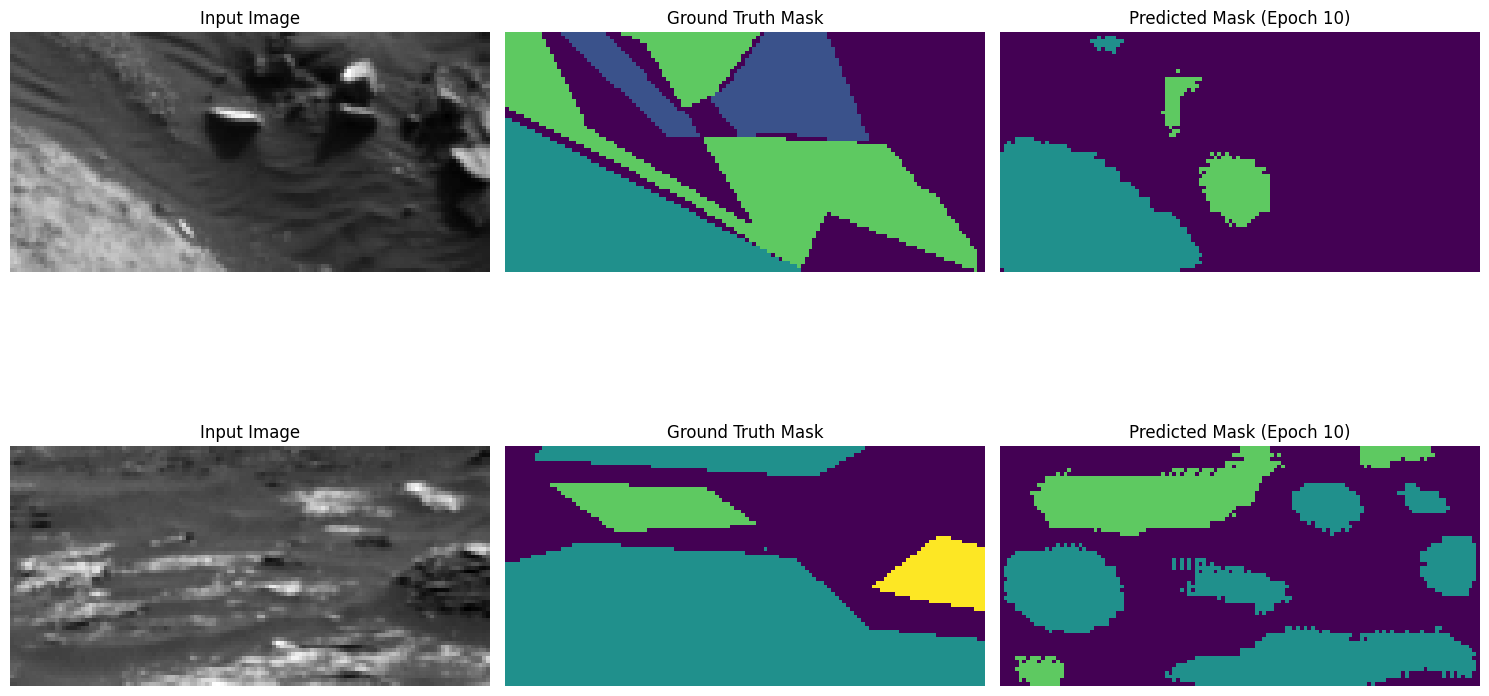

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 228ms/step - accuracy: 0.7224 - loss: 0.7098 - mean_io_u_5: 0.5587 - mean_iou: 0.5587 - val_accuracy: 0.6713 - val_loss: 0.8574 - val_mean_io_u_5: 0.3878 - val_mean_iou: 0.3878 - learning_rate: 1.0000e-04
Epoch 11/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7400 - loss: 0.6697 - mean_io_u_5: 0.5763 - mean_iou: 0.5763Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 11: val_loss did not improve from 0.85737
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


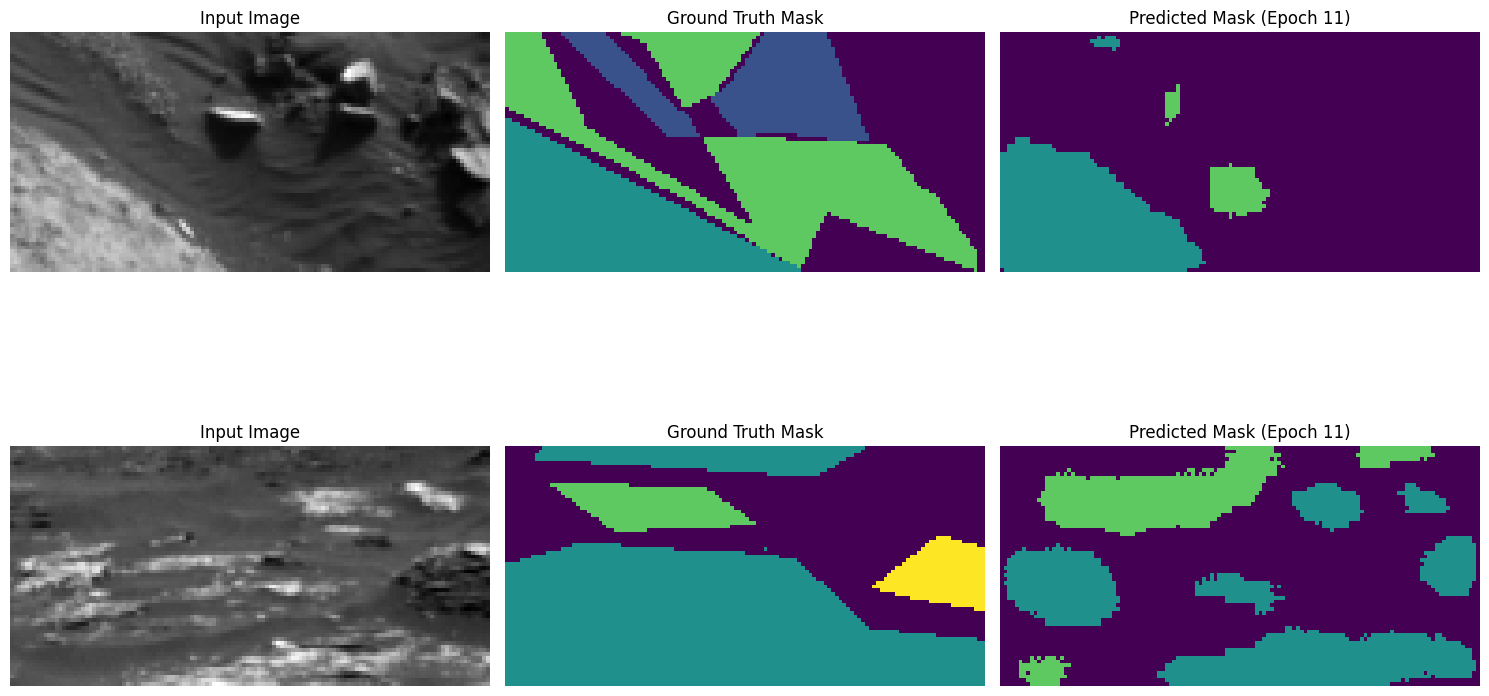

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.7400 - loss: 0.6698 - mean_io_u_5: 0.5763 - mean_iou: 0.5763 - val_accuracy: 0.6725 - val_loss: 0.8609 - val_mean_io_u_5: 0.3855 - val_mean_iou: 0.3855 - learning_rate: 1.0000e-04
Epoch 12/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7500 - loss: 0.6445 - mean_io_u_5: 0.5854 - mean_iou: 0.5854Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 12: val_loss did not improve from 0.85737
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


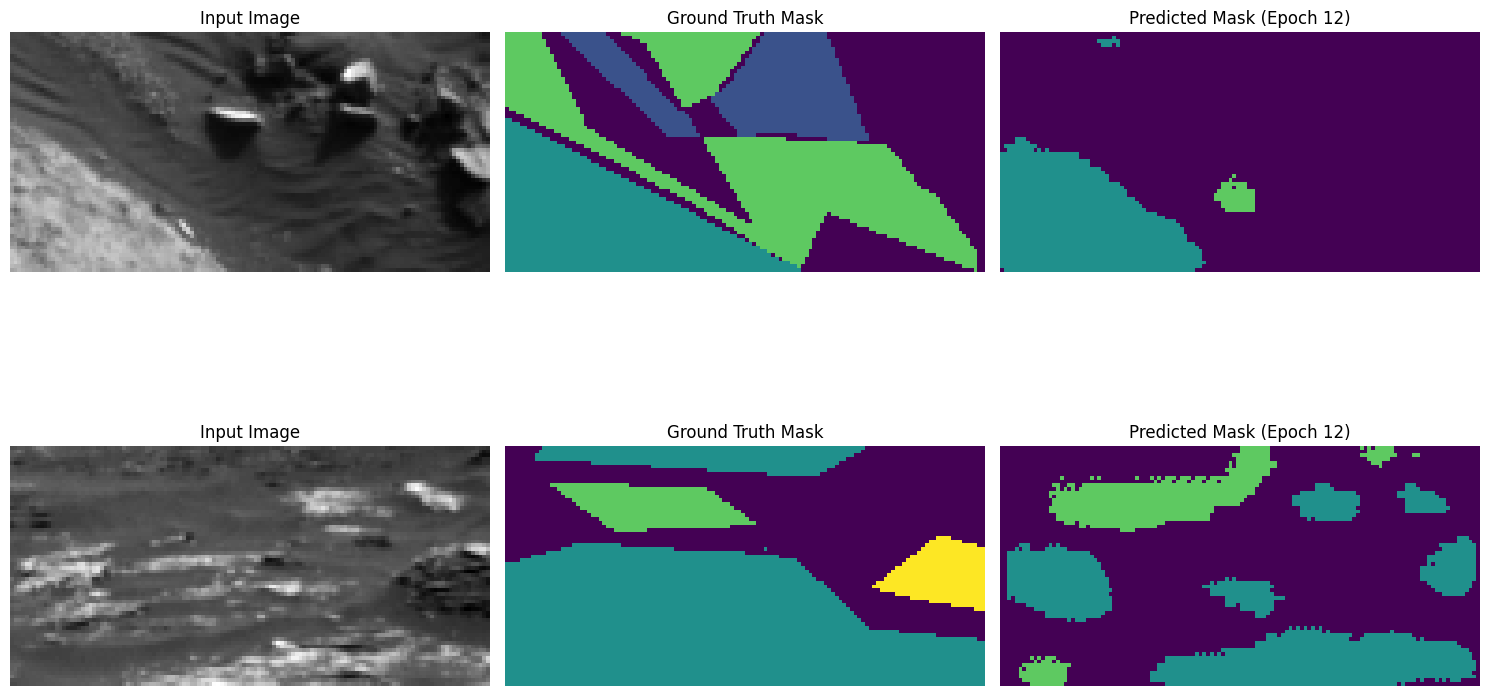

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.7499 - loss: 0.6445 - mean_io_u_5: 0.5854 - mean_iou: 0.5854 - val_accuracy: 0.6673 - val_loss: 0.8763 - val_mean_io_u_5: 0.3753 - val_mean_iou: 0.3753 - learning_rate: 1.0000e-04
Epoch 13/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7538 - loss: 0.6359 - mean_io_u_5: 0.5876 - mean_iou: 0.5876Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 13: val_loss improved from 0.85737 to 0.85244, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


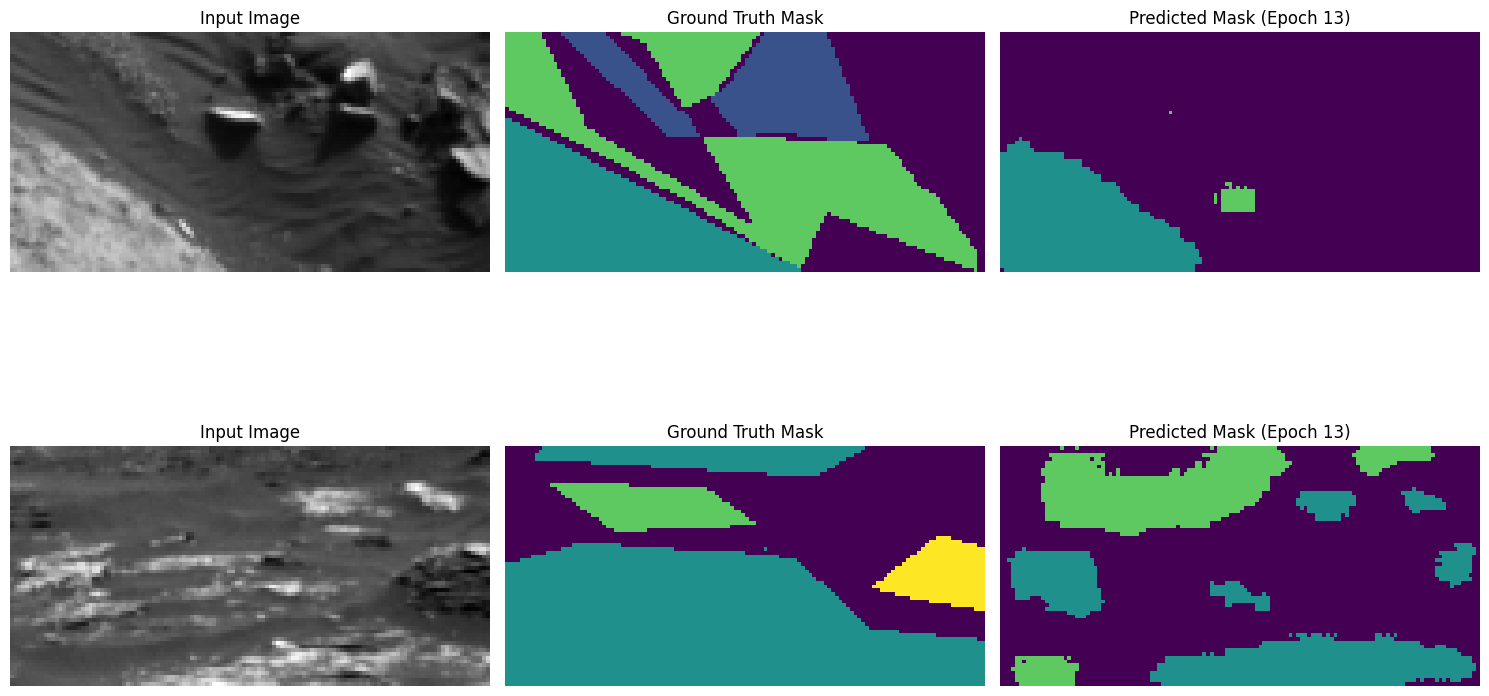

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - accuracy: 0.7538 - loss: 0.6359 - mean_io_u_5: 0.5876 - mean_iou: 0.5876 - val_accuracy: 0.6805 - val_loss: 0.8524 - val_mean_io_u_5: 0.3798 - val_mean_iou: 0.3798 - learning_rate: 1.0000e-04
Epoch 14/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7604 - loss: 0.6190 - mean_io_u_5: 0.5933 - mean_iou: 0.5933Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 14: val_loss improved from 0.85244 to 0.84642, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


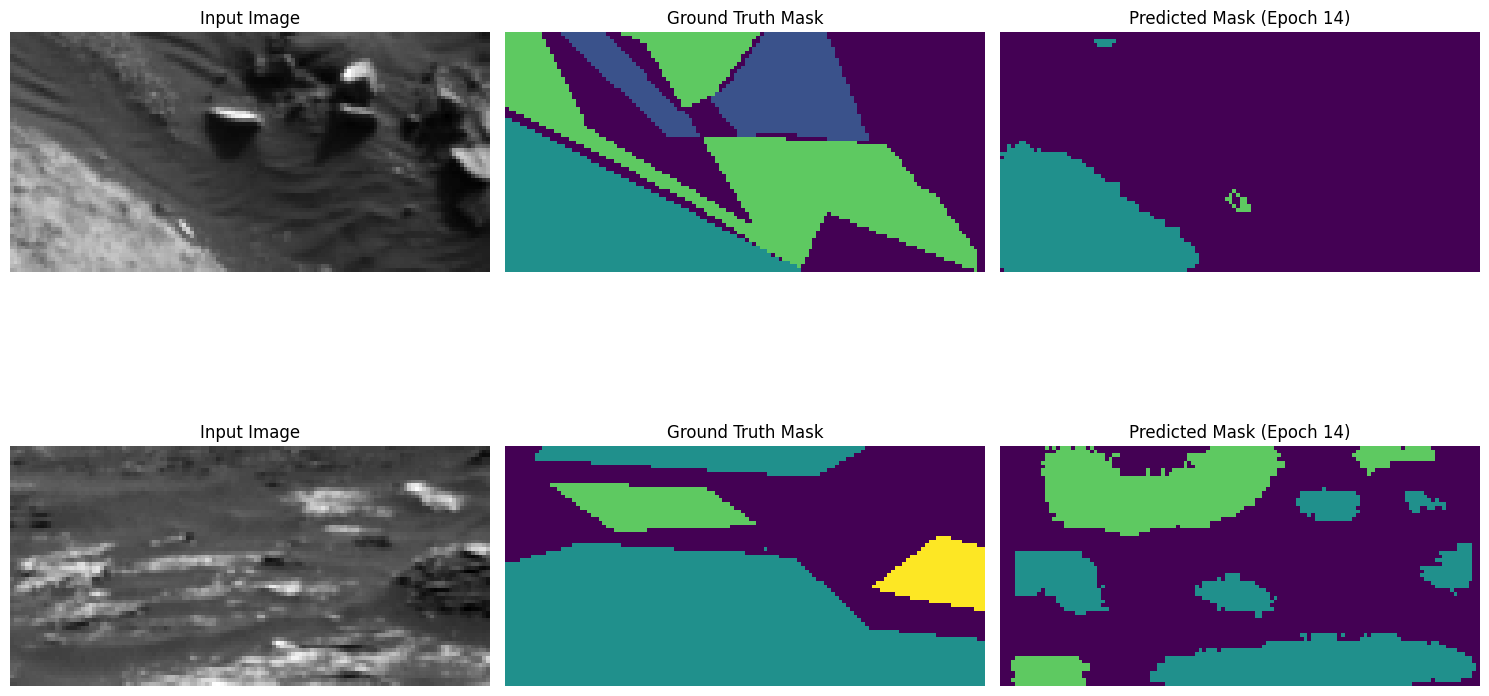

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 225ms/step - accuracy: 0.7604 - loss: 0.6190 - mean_io_u_5: 0.5934 - mean_iou: 0.5934 - val_accuracy: 0.6861 - val_loss: 0.8464 - val_mean_io_u_5: 0.3843 - val_mean_iou: 0.3843 - learning_rate: 1.0000e-04
Epoch 15/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7675 - loss: 0.6031 - mean_io_u_5: 0.6001 - mean_iou: 0.6001Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 15: val_loss did not improve from 0.84642
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


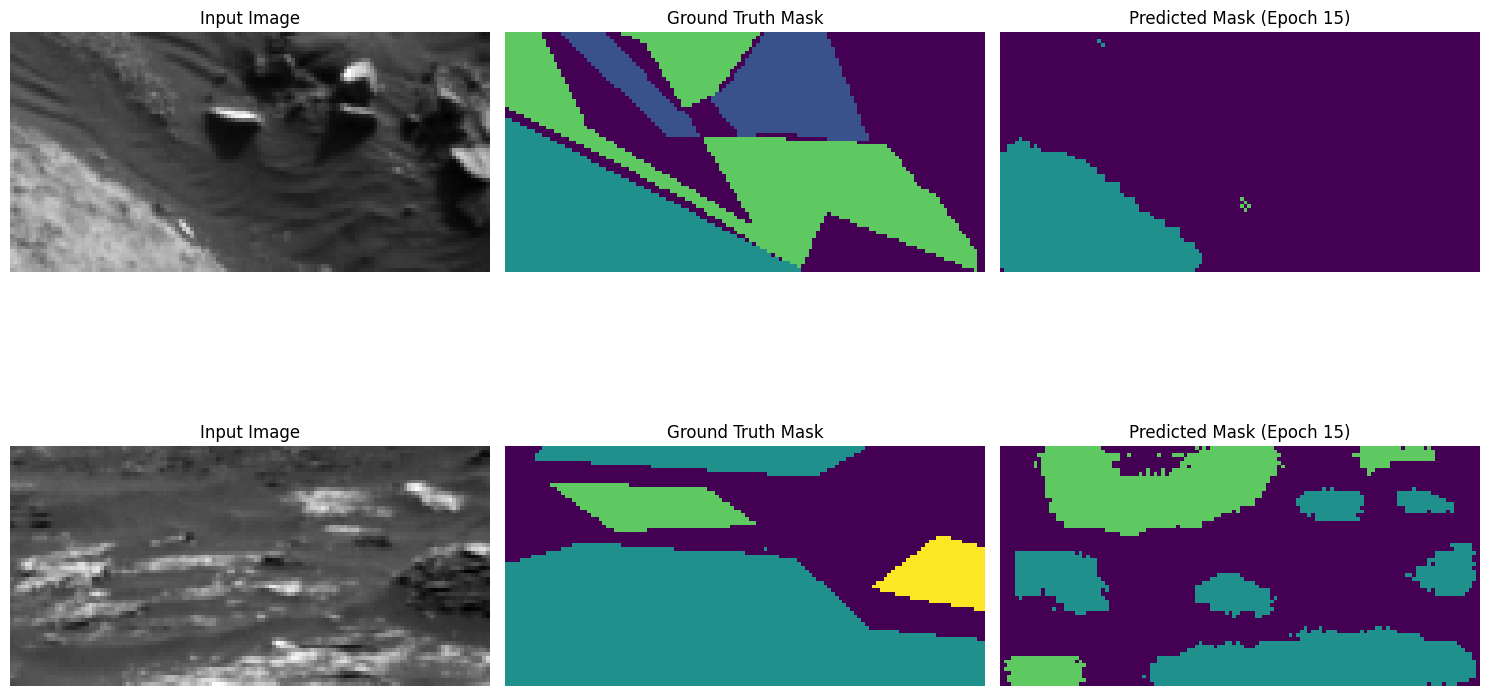

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.7675 - loss: 0.6031 - mean_io_u_5: 0.6002 - mean_iou: 0.6002 - val_accuracy: 0.6842 - val_loss: 0.8624 - val_mean_io_u_5: 0.3839 - val_mean_iou: 0.3839 - learning_rate: 1.0000e-04
Epoch 16/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7704 - loss: 0.5964 - mean_io_u_5: 0.6020 - mean_iou: 0.6020Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 16: val_loss did not improve from 0.84642
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


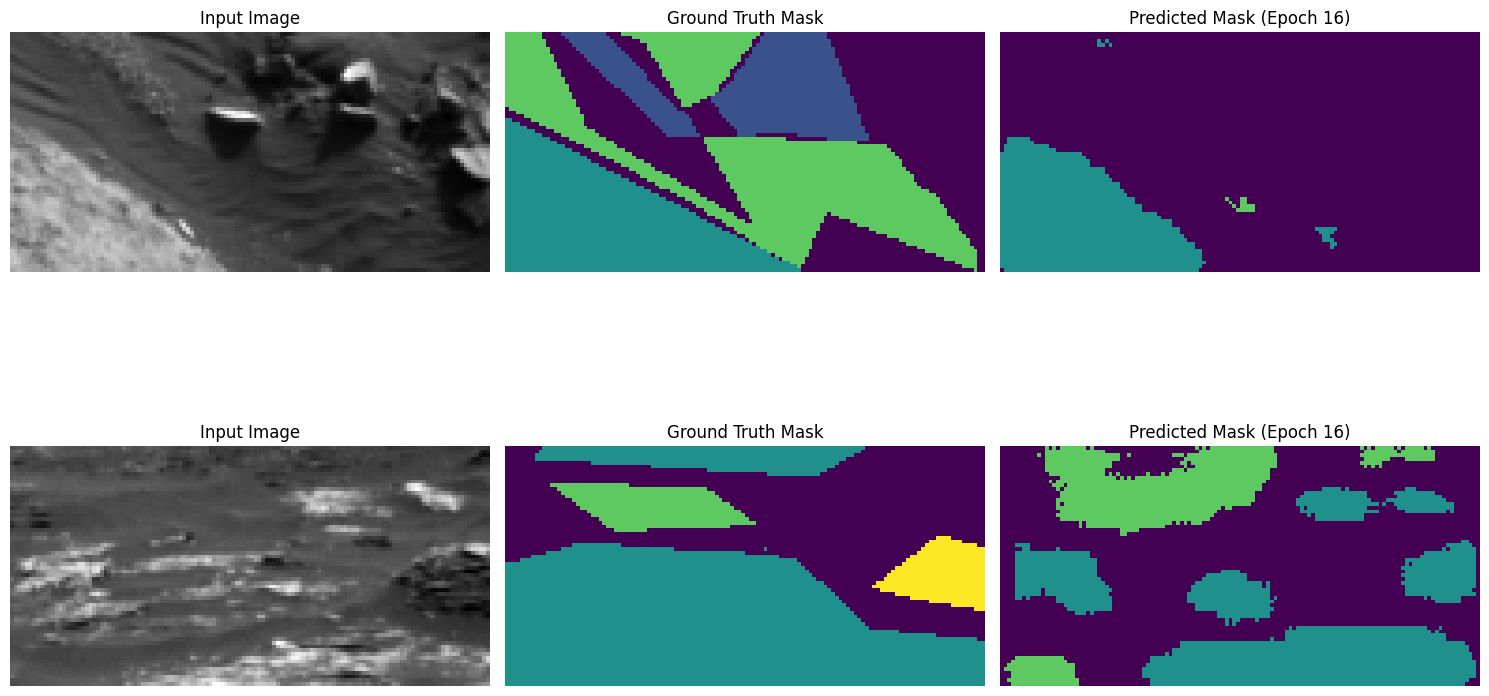

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.7704 - loss: 0.5964 - mean_io_u_5: 0.6020 - mean_iou: 0.6020 - val_accuracy: 0.6787 - val_loss: 0.8800 - val_mean_io_u_5: 0.3796 - val_mean_iou: 0.3796 - learning_rate: 1.0000e-04
Epoch 17/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7734 - loss: 0.5866 - mean_io_u_5: 0.6043 - mean_iou: 0.6043Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 17: val_loss did not improve from 0.84642
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


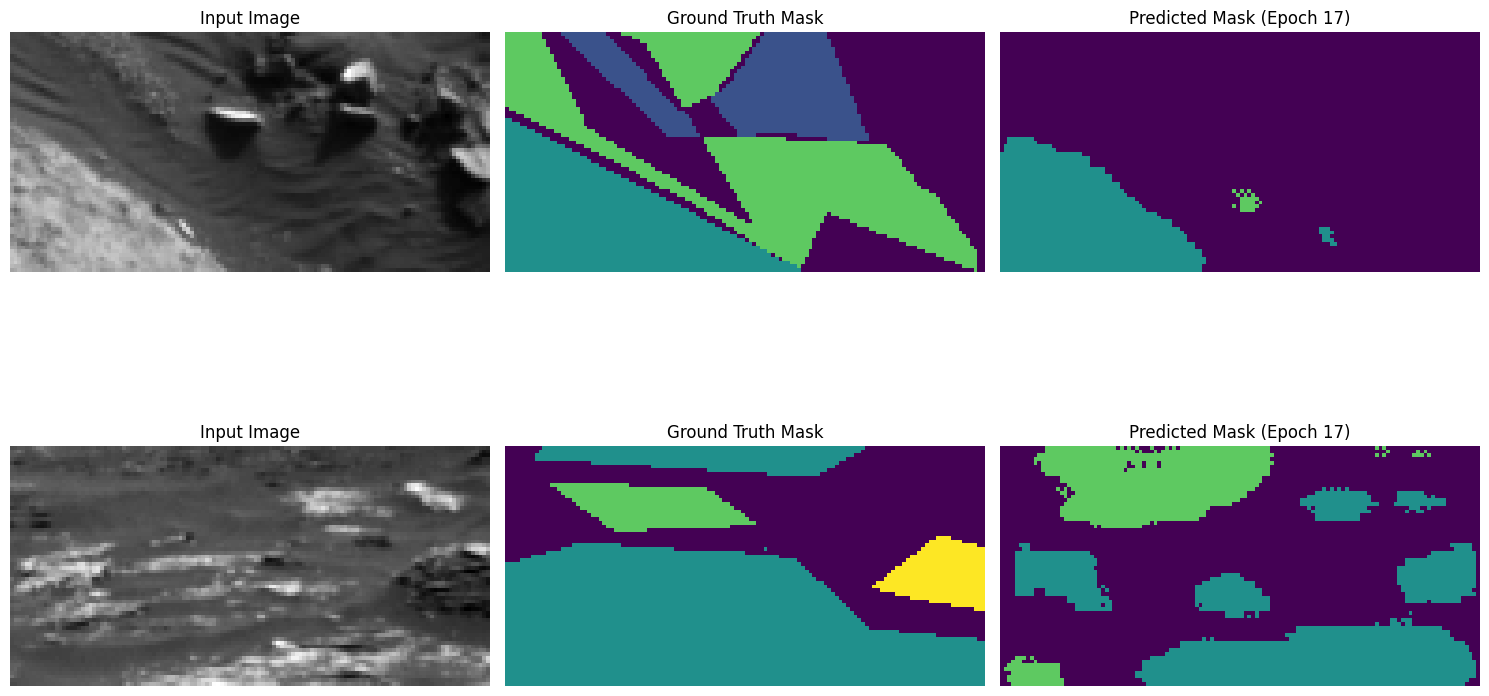

94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 218ms/step - accuracy: 0.7734 - loss: 0.5866 - mean_io_u_5: 0.6044 - mean_iou: 0.6044 - val_accuracy: 0.6656 - val_loss: 0.9351 - val_mean_io_u_5: 0.3664 - val_mean_iou: 0.3664 - learning_rate: 1.0000e-04
Epoch 18/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7749 - loss: 0.5800 - mean_io_u_5: 0.6047 - mean_iou: 0.6047Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 18: val_loss did not improve from 0.84642
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


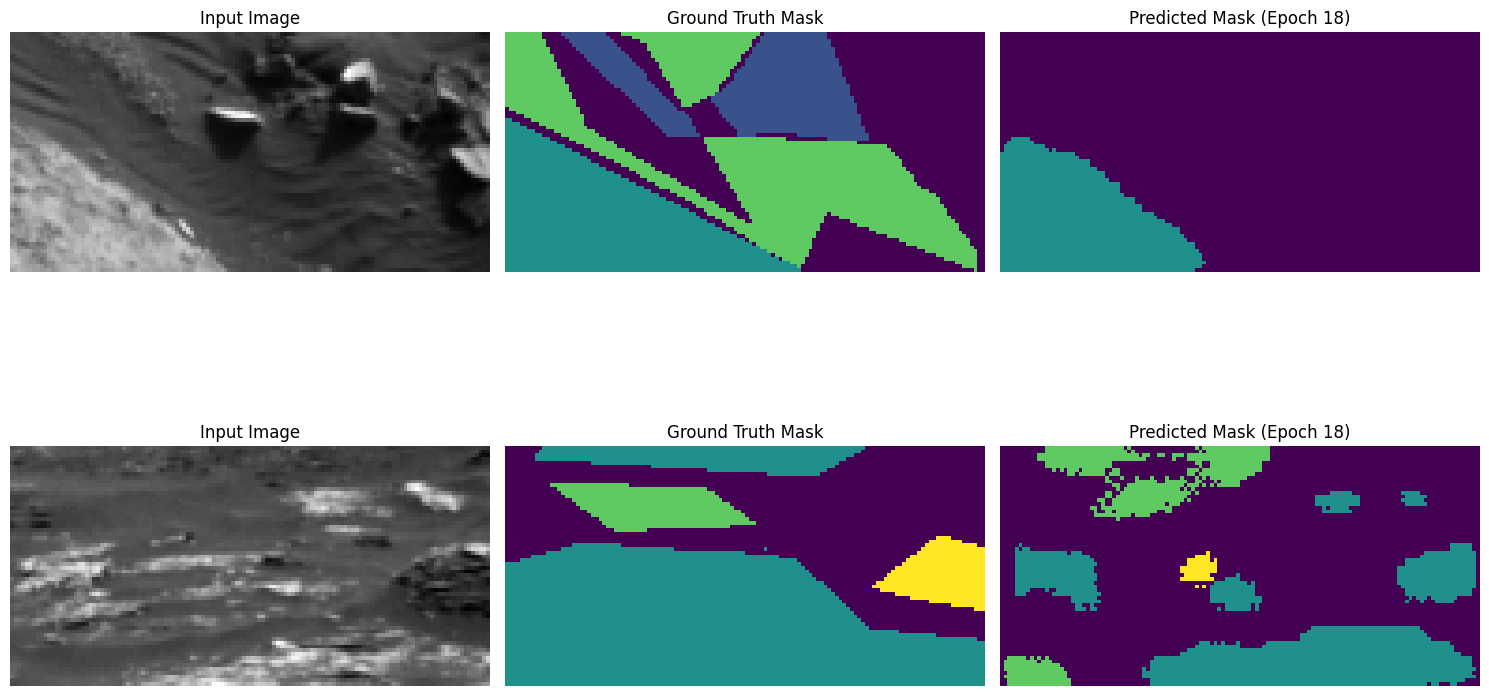

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - accuracy: 0.7750 - loss: 0.5799 - mean_io_u_5: 0.6047 - mean_iou: 0.6047 - val_accuracy: 0.6469 - val_loss: 1.0052 - val_mean_io_u_5: 0.3453 - val_mean_iou: 0.3453 - learning_rate: 1.0000e-04
Epoch 19/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7711 - loss: 0.5909 - mean_io_u_5: 0.6005 - mean_iou: 0.6005Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])
Epoch 19: val_mean_iou improved to 0.4020, saving model.

Epoch 19: val_loss improved from 0.84642 to 0.81829, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


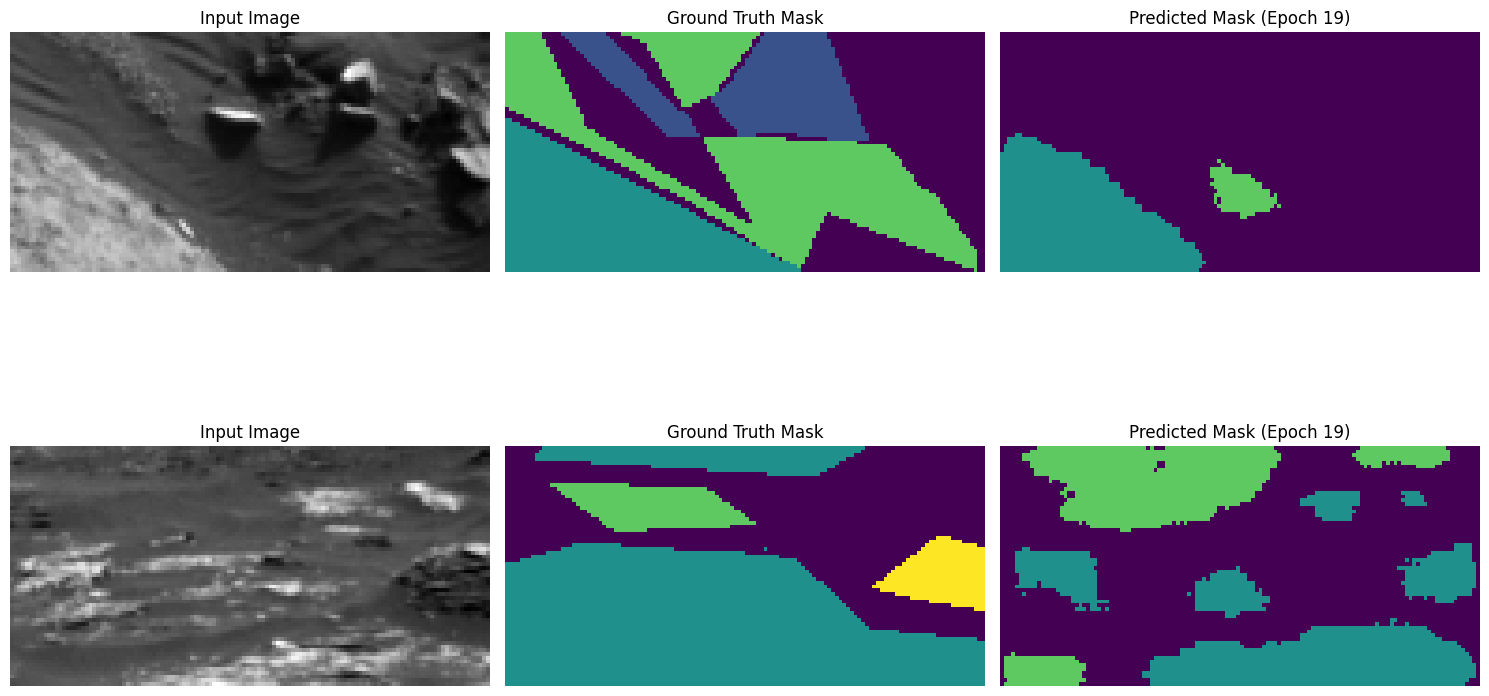

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 227ms/step - accuracy: 0.7711 - loss: 0.5908 - mean_io_u_5: 0.6006 - mean_iou: 0.6006 - val_accuracy: 0.7029 - val_loss: 0.8183 - val_mean_io_u_5: 0.4020 - val_mean_iou: 0.4020 - learning_rate: 1.0000e-04
Epoch 20/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7643 - loss: 0.5967 - mean_io_u_5: 0.5895 - mean_iou: 0.5895Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])
Epoch 20: val_mean_iou improved to 0.4088, saving model.

Epoch 20: val_loss improved from 0.81829 to 0.80914, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


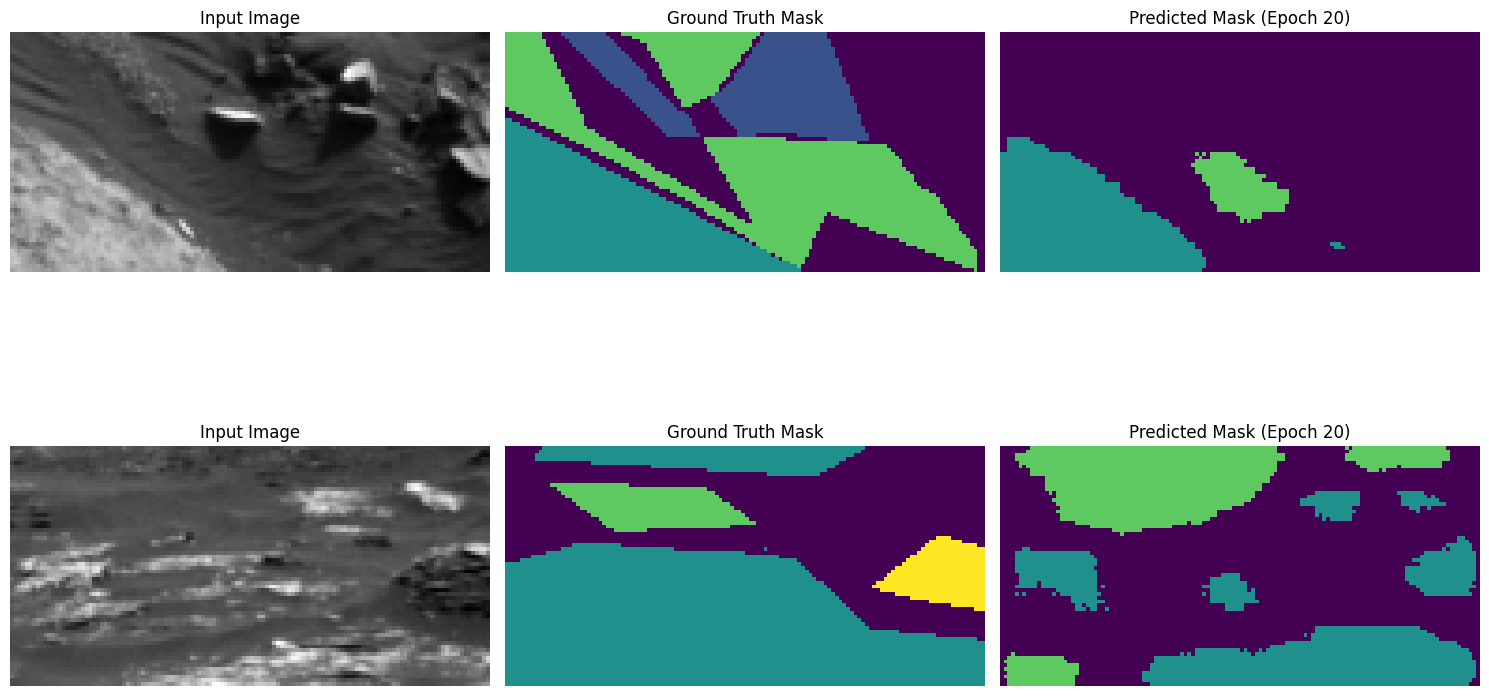

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 227ms/step - accuracy: 0.7644 - loss: 0.5965 - mean_io_u_5: 0.5897 - mean_iou: 0.5897 - val_accuracy: 0.7082 - val_loss: 0.8091 - val_mean_io_u_5: 0.4088 - val_mean_iou: 0.4088 - learning_rate: 1.0000e-04
Epoch 21/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7812 - loss: 0.5598 - mean_io_u_5: 0.6112 - mean_iou: 0.6112Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])
Epoch 21: val_mean_iou improved to 0.4100, saving model.

Epoch 21: val_loss did not improve from 0.80914
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


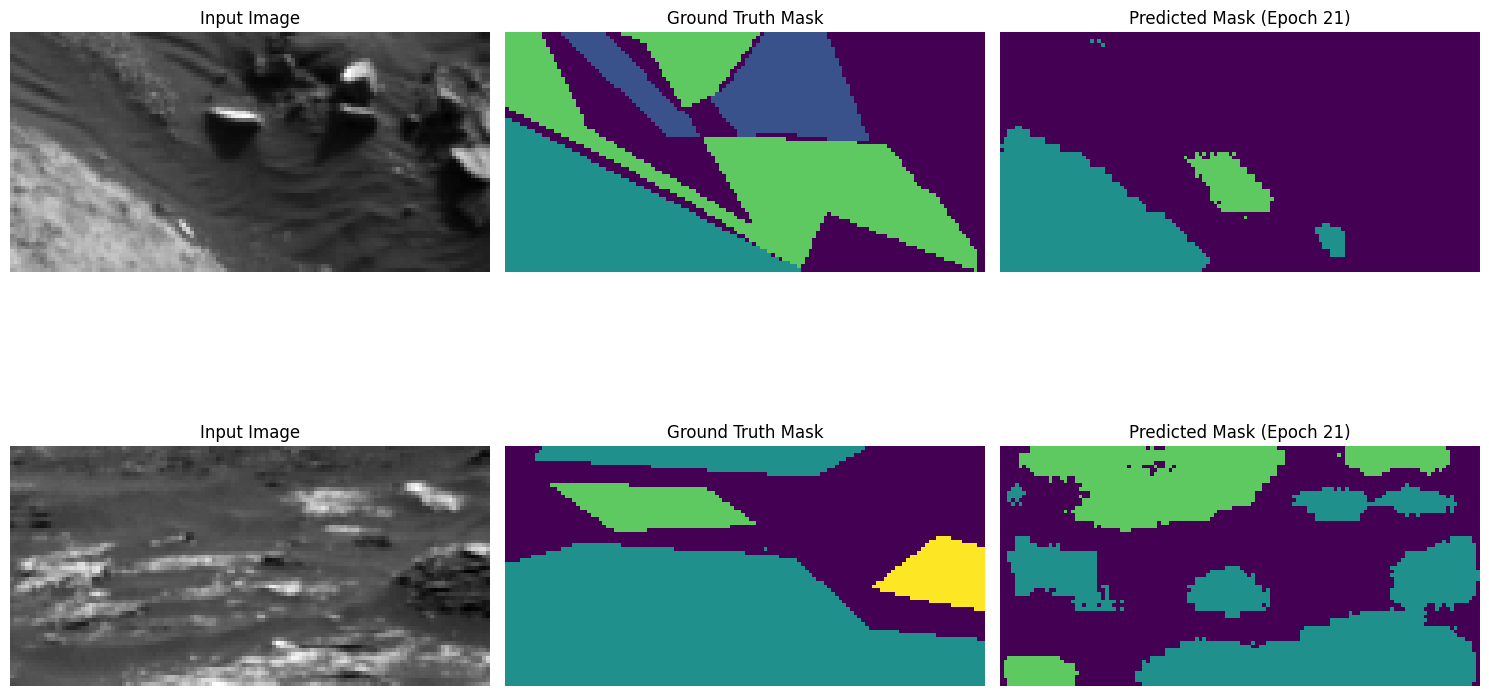

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step - accuracy: 0.7812 - loss: 0.5597 - mean_io_u_5: 0.6113 - mean_iou: 0.6113 - val_accuracy: 0.7024 - val_loss: 0.8200 - val_mean_io_u_5: 0.4100 - val_mean_iou: 0.4100 - learning_rate: 1.0000e-04
Epoch 22/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7863 - loss: 0.5485 - mean_io_u_5: 0.6163 - mean_iou: 0.6163Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 22: val_loss did not improve from 0.80914
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


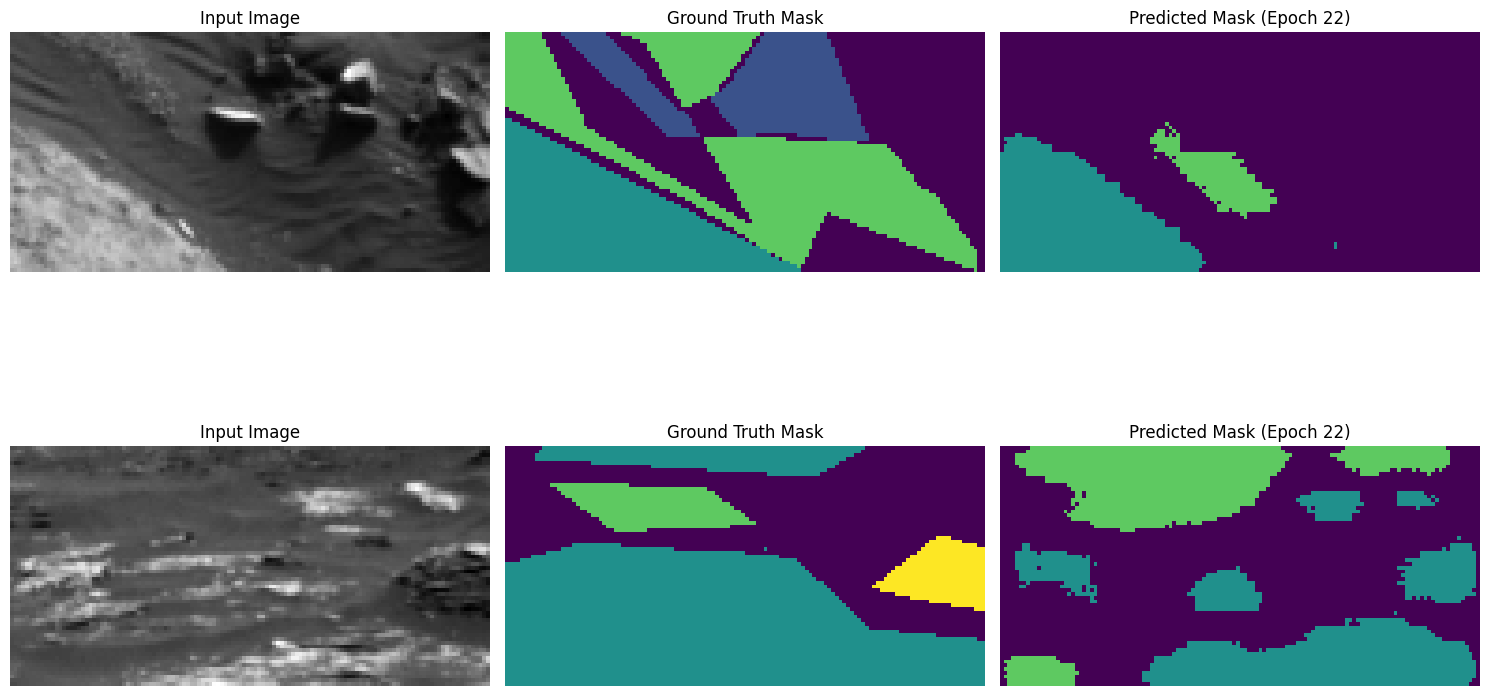

94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 218ms/step - accuracy: 0.7863 - loss: 0.5484 - mean_io_u_5: 0.6163 - mean_iou: 0.6163 - val_accuracy: 0.7073 - val_loss: 0.8199 - val_mean_io_u_5: 0.4058 - val_mean_iou: 0.4058 - learning_rate: 1.0000e-04
Epoch 23/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7857 - loss: 0.5474 - mean_io_u_5: 0.6155 - mean_iou: 0.6155Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])
Epoch 23: val_mean_iou improved to 0.4146, saving model.

Epoch 23: val_loss improved from 0.80914 to 0.78937, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


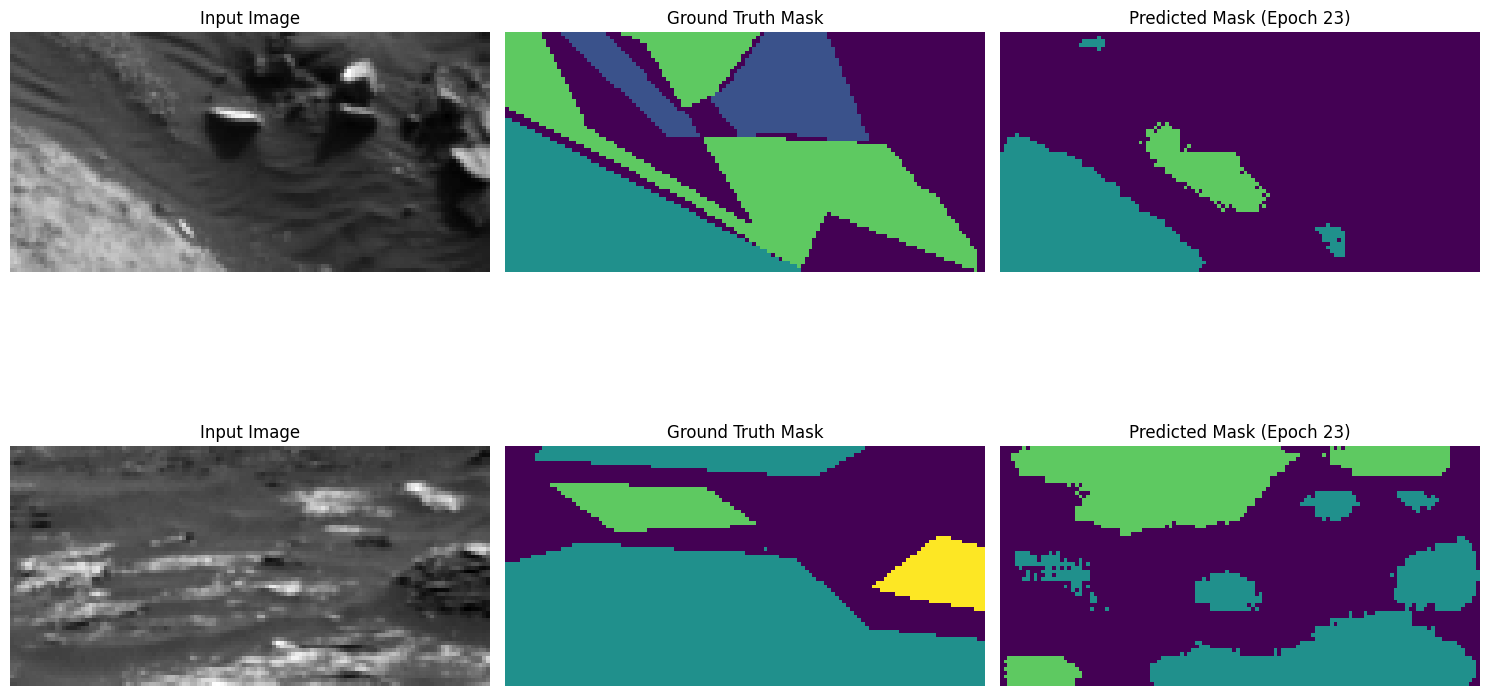

94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 236ms/step - accuracy: 0.7858 - loss: 0.5474 - mean_io_u_5: 0.6156 - mean_iou: 0.6156 - val_accuracy: 0.7154 - val_loss: 0.7894 - val_mean_io_u_5: 0.4146 - val_mean_iou: 0.4146 - learning_rate: 1.0000e-04
Epoch 24/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7907 - loss: 0.5332 - mean_io_u_5: 0.6200 - mean_iou: 0.6200Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])
Epoch 24: val_mean_iou improved to 0.4220, saving model.

Epoch 24: val_loss improved from 0.78937 to 0.77324, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


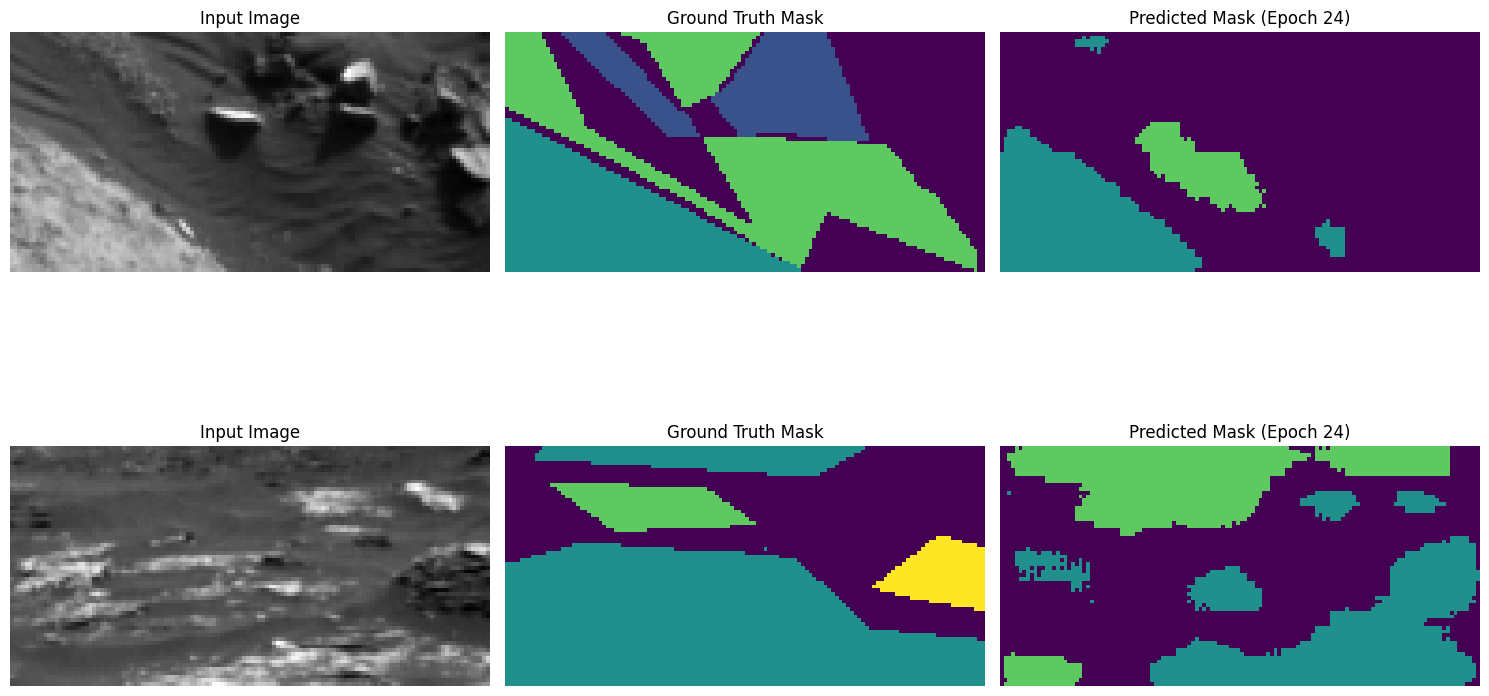

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 227ms/step - accuracy: 0.7908 - loss: 0.5332 - mean_io_u_5: 0.6200 - mean_iou: 0.6200 - val_accuracy: 0.7178 - val_loss: 0.7732 - val_mean_io_u_5: 0.4220 - val_mean_iou: 0.4220 - learning_rate: 1.0000e-04
Epoch 25/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7981 - loss: 0.5166 - mean_io_u_5: 0.6288 - mean_iou: 0.6288Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 25: val_loss did not improve from 0.77324
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


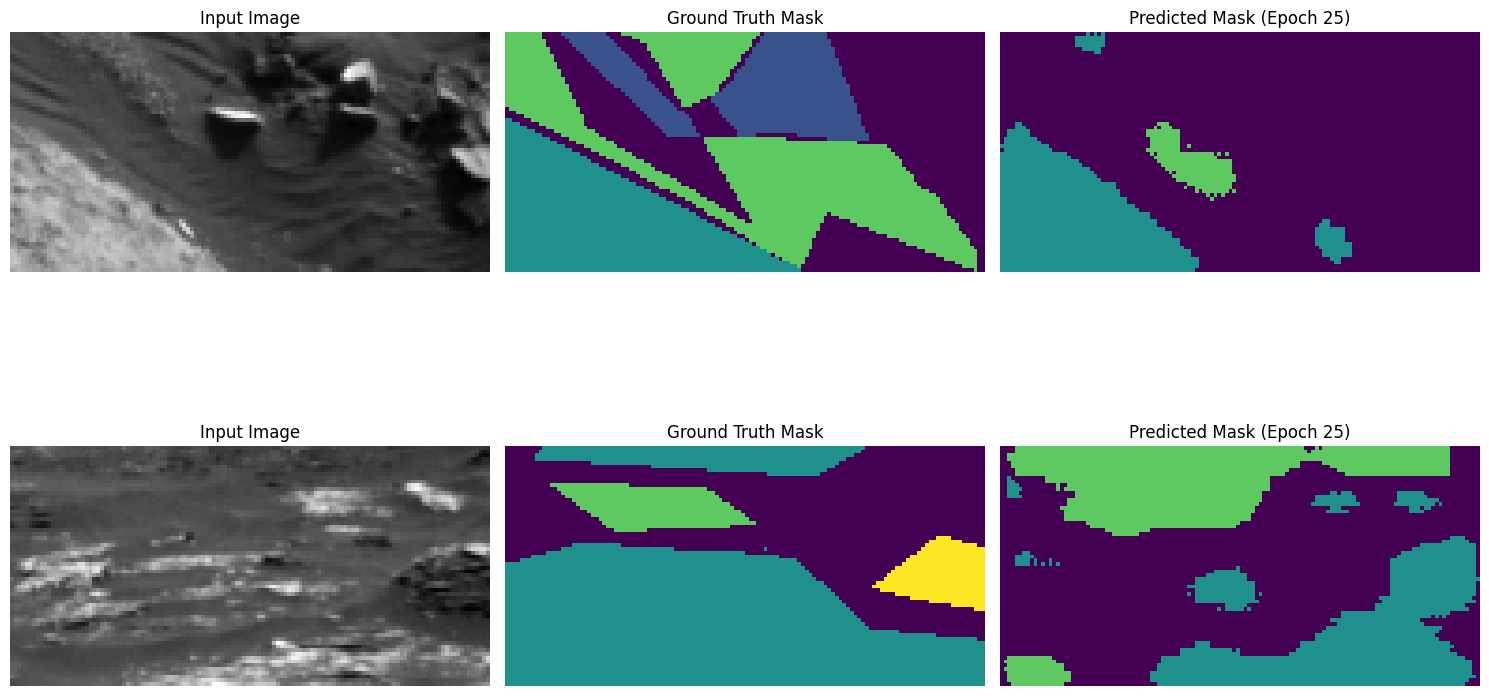

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.7981 - loss: 0.5166 - mean_io_u_5: 0.6289 - mean_iou: 0.6289 - val_accuracy: 0.7151 - val_loss: 0.7926 - val_mean_io_u_5: 0.4165 - val_mean_iou: 0.4165 - learning_rate: 1.0000e-04
Epoch 26/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8042 - loss: 0.5037 - mean_io_u_5: 0.6339 - mean_iou: 0.6339Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 26: val_loss did not improve from 0.77324
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


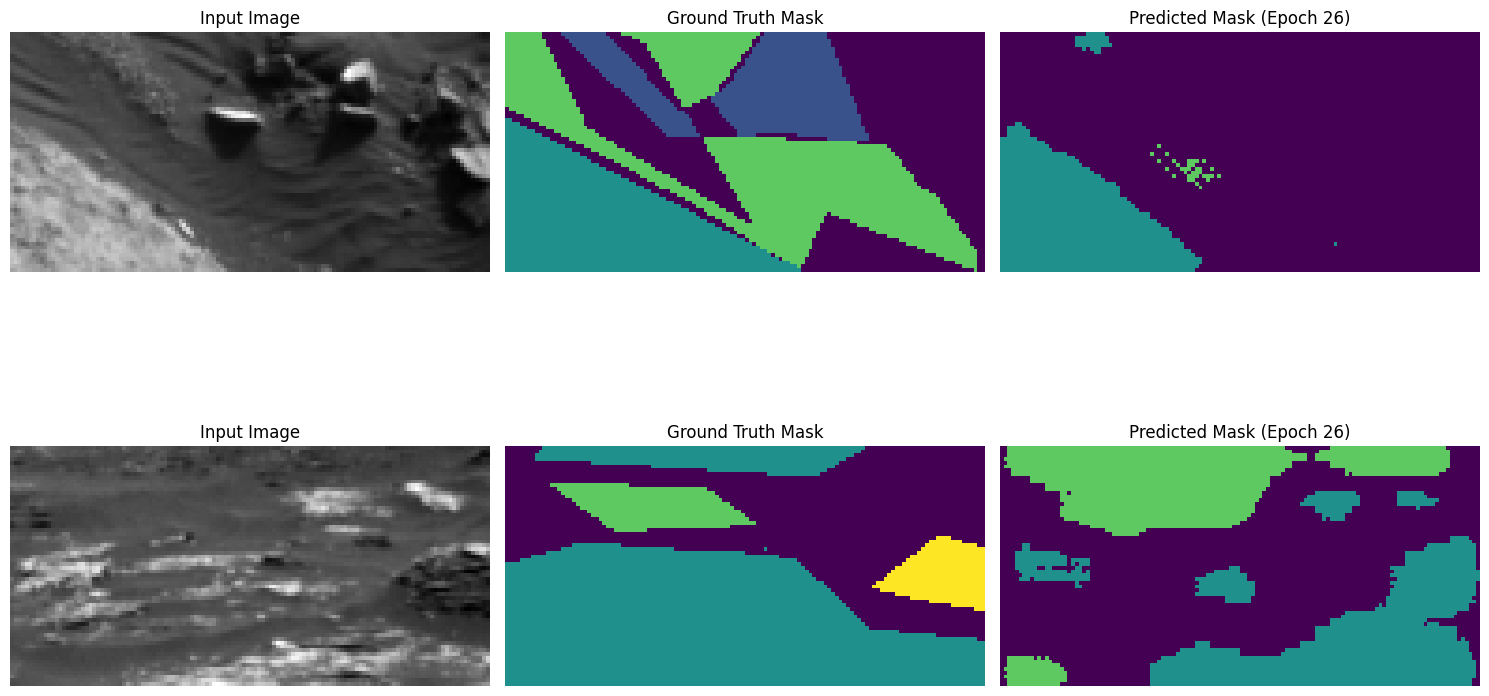

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.8042 - loss: 0.5037 - mean_io_u_5: 0.6339 - mean_iou: 0.6339 - val_accuracy: 0.7186 - val_loss: 0.7913 - val_mean_io_u_5: 0.4169 - val_mean_iou: 0.4169 - learning_rate: 1.0000e-04
Epoch 27/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8102 - loss: 0.4879 - mean_io_u_5: 0.6411 - mean_iou: 0.6411Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 27: val_loss did not improve from 0.77324
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


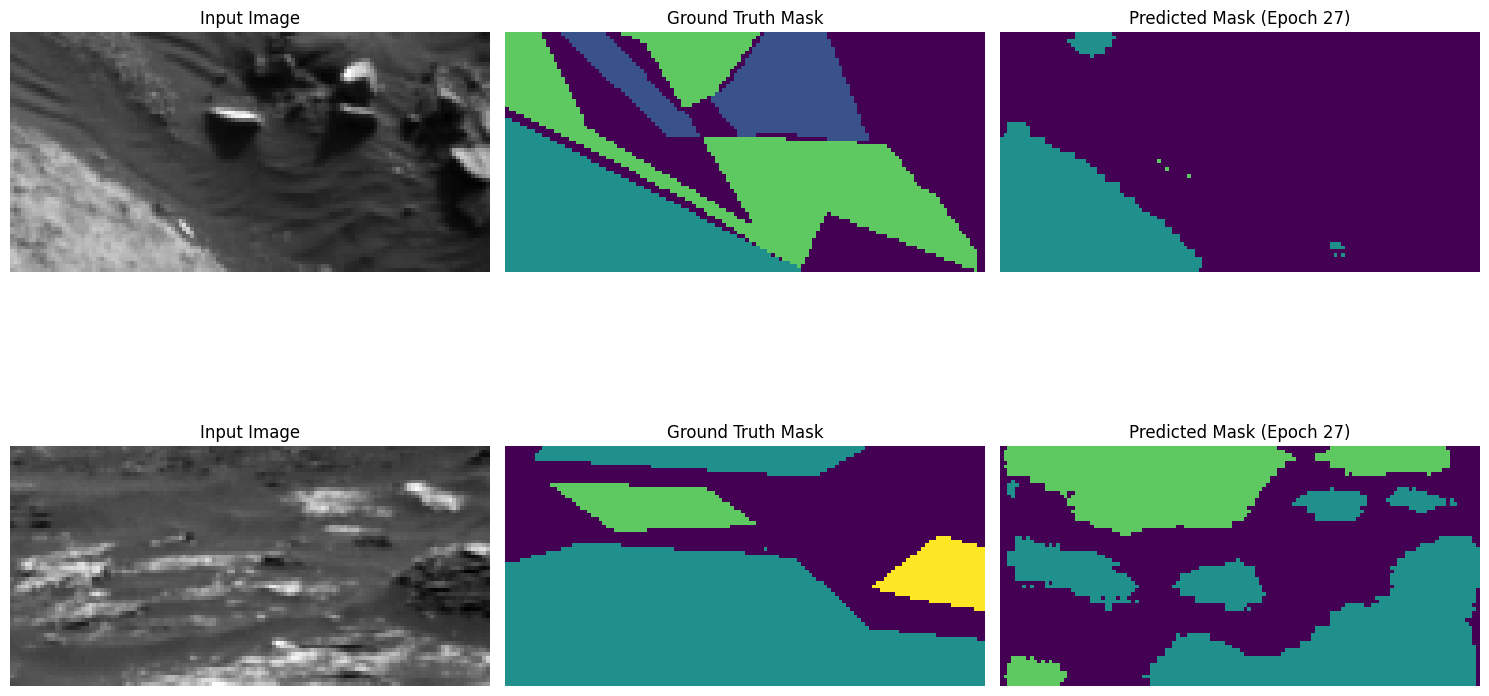

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.8103 - loss: 0.4879 - mean_io_u_5: 0.6412 - mean_iou: 0.6412 - val_accuracy: 0.7128 - val_loss: 0.8185 - val_mean_io_u_5: 0.4141 - val_mean_iou: 0.4141 - learning_rate: 1.0000e-04
Epoch 28/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8180 - loss: 0.4724 - mean_io_u_5: 0.6496 - mean_iou: 0.6496Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 28: val_loss did not improve from 0.77324
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


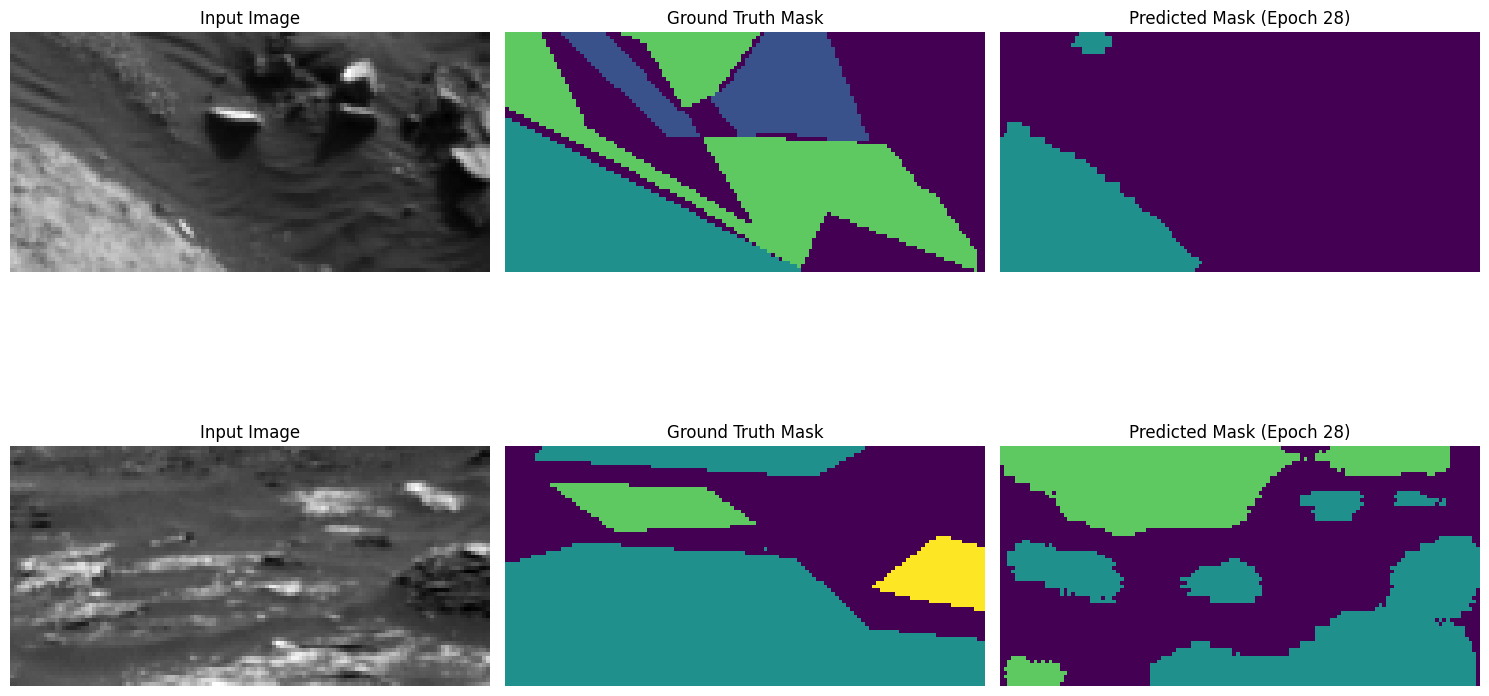

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - accuracy: 0.8180 - loss: 0.4724 - mean_io_u_5: 0.6496 - mean_iou: 0.6496 - val_accuracy: 0.7109 - val_loss: 0.8363 - val_mean_io_u_5: 0.4112 - val_mean_iou: 0.4112 - learning_rate: 1.0000e-04
Epoch 29/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8193 - loss: 0.4698 - mean_io_u_5: 0.6494 - mean_iou: 0.6494Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 29: val_loss did not improve from 0.77324

Epoch 29: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


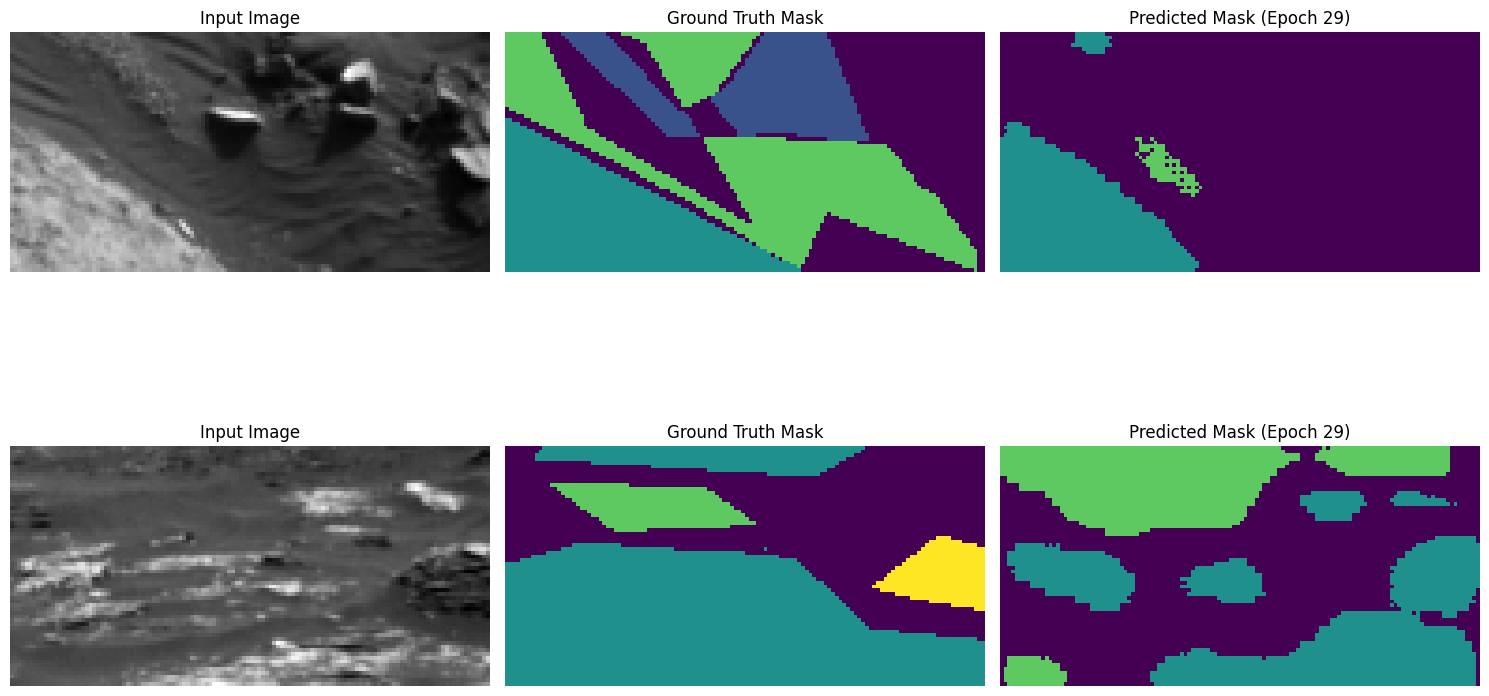

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.8193 - loss: 0.4698 - mean_io_u_5: 0.6495 - mean_iou: 0.6495 - val_accuracy: 0.7076 - val_loss: 0.8509 - val_mean_io_u_5: 0.4070 - val_mean_iou: 0.4070 - learning_rate: 1.0000e-04
Epoch 30/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8226 - loss: 0.4622 - mean_io_u_5: 0.6533 - mean_iou: 0.6533Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])
Epoch 30: val_mean_iou improved to 0.4326, saving model.

Epoch 30: val_loss improved from 0.77324 to 0.75129, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


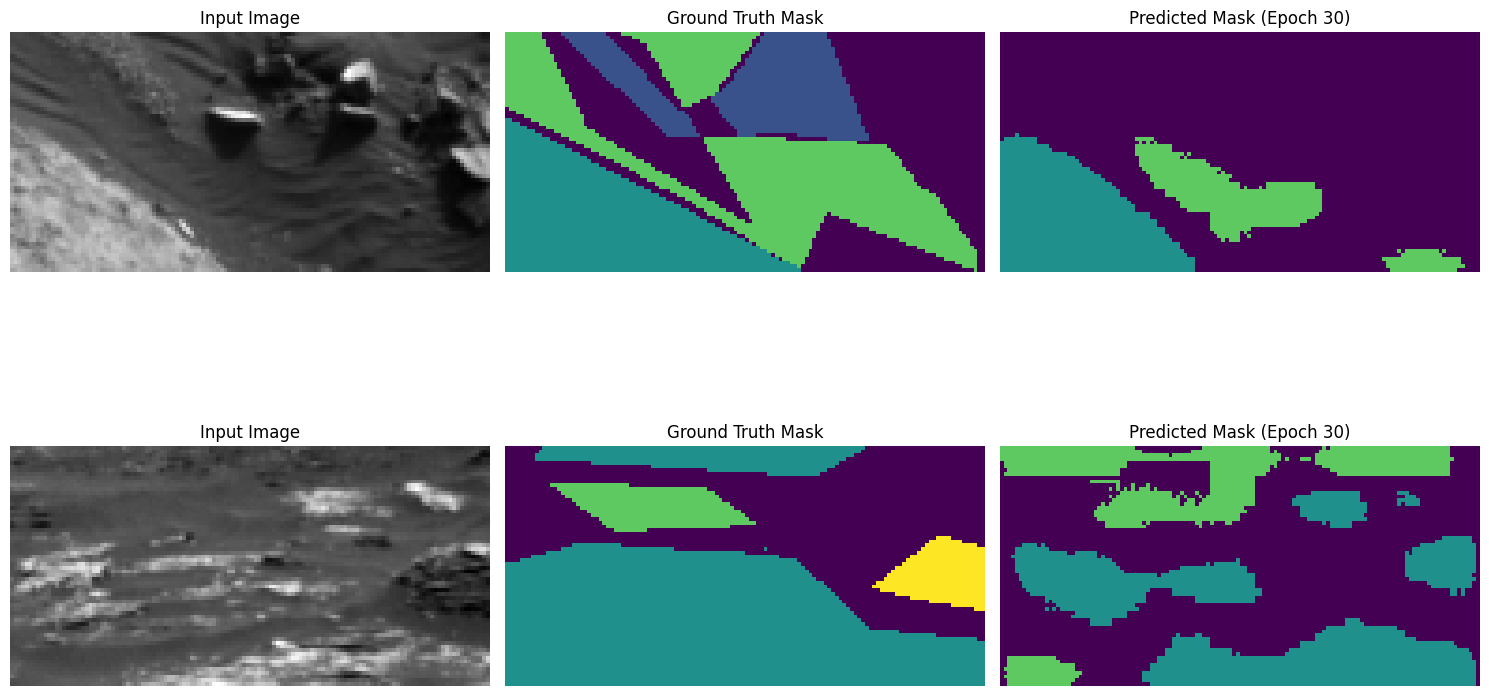

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 227ms/step - accuracy: 0.8225 - loss: 0.4622 - mean_io_u_5: 0.6533 - mean_iou: 0.6533 - val_accuracy: 0.7302 - val_loss: 0.7513 - val_mean_io_u_5: 0.4326 - val_mean_iou: 0.4326 - learning_rate: 5.0000e-05
Epoch 31/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8261 - loss: 0.4470 - mean_io_u_5: 0.6597 - mean_iou: 0.6597Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 31: val_loss improved from 0.75129 to 0.74751, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


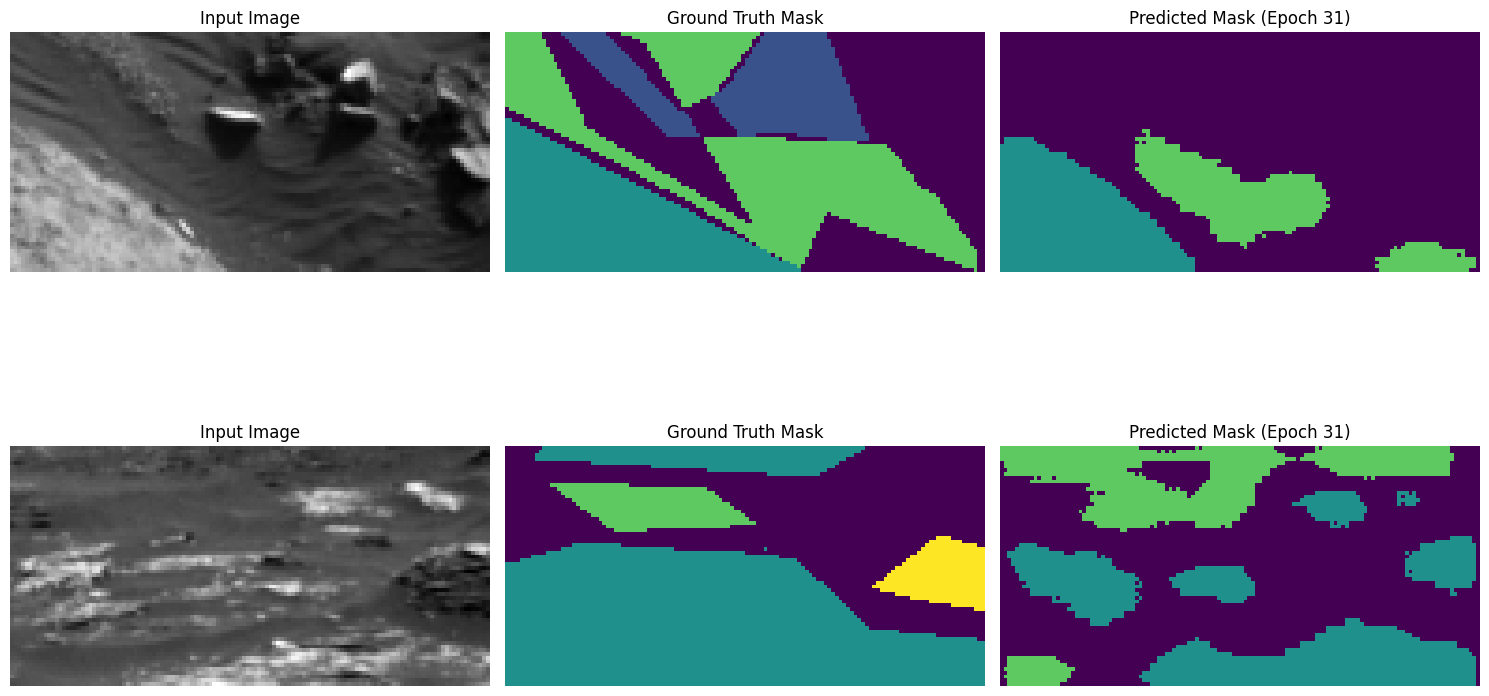

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - accuracy: 0.8261 - loss: 0.4470 - mean_io_u_5: 0.6597 - mean_iou: 0.6597 - val_accuracy: 0.7309 - val_loss: 0.7475 - val_mean_io_u_5: 0.4326 - val_mean_iou: 0.4326 - learning_rate: 5.0000e-05
Epoch 32/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8332 - loss: 0.4298 - mean_io_u_5: 0.6673 - mean_iou: 0.6673Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 32: val_loss did not improve from 0.74751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


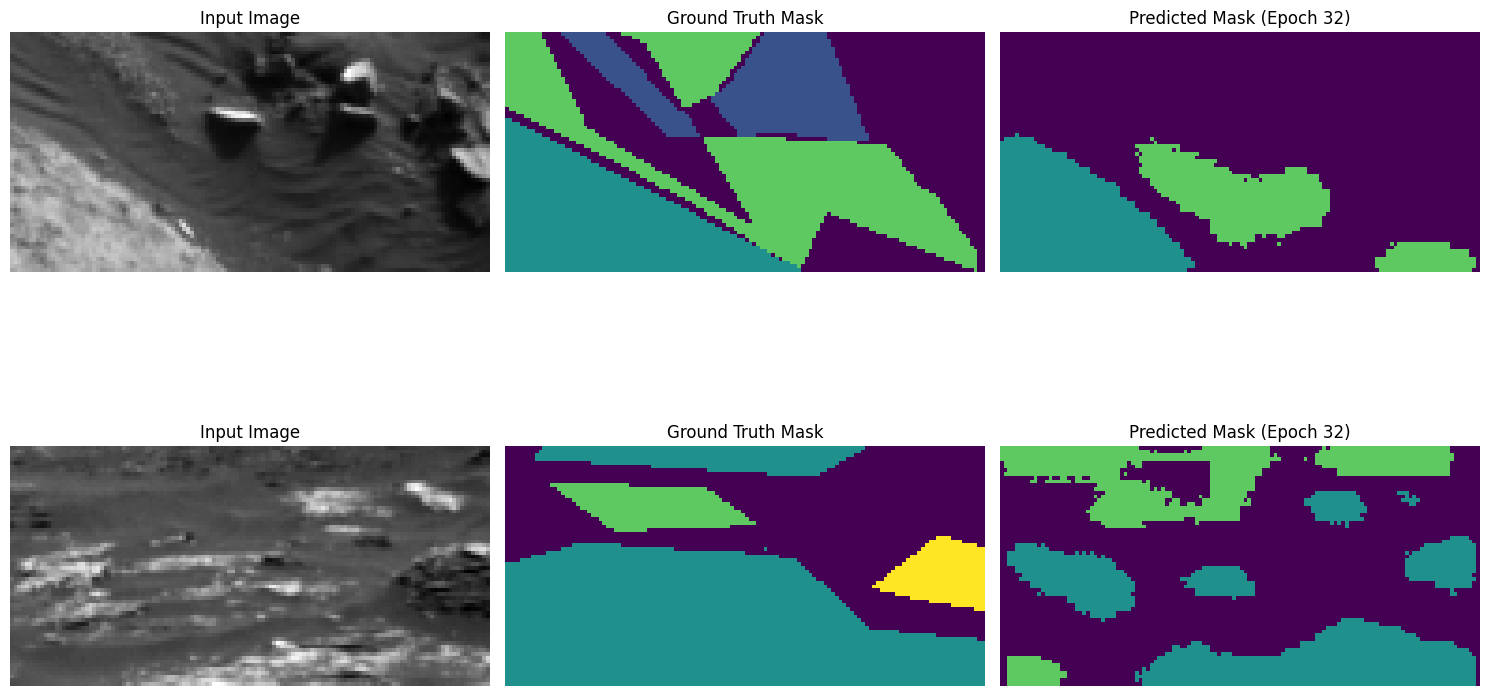

94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 218ms/step - accuracy: 0.8331 - loss: 0.4299 - mean_io_u_5: 0.6673 - mean_iou: 0.6673 - val_accuracy: 0.7312 - val_loss: 0.7538 - val_mean_io_u_5: 0.4318 - val_mean_iou: 0.4318 - learning_rate: 5.0000e-05
Epoch 33/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8375 - loss: 0.4200 - mean_io_u_5: 0.6715 - mean_iou: 0.6715Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 33: val_loss did not improve from 0.74751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


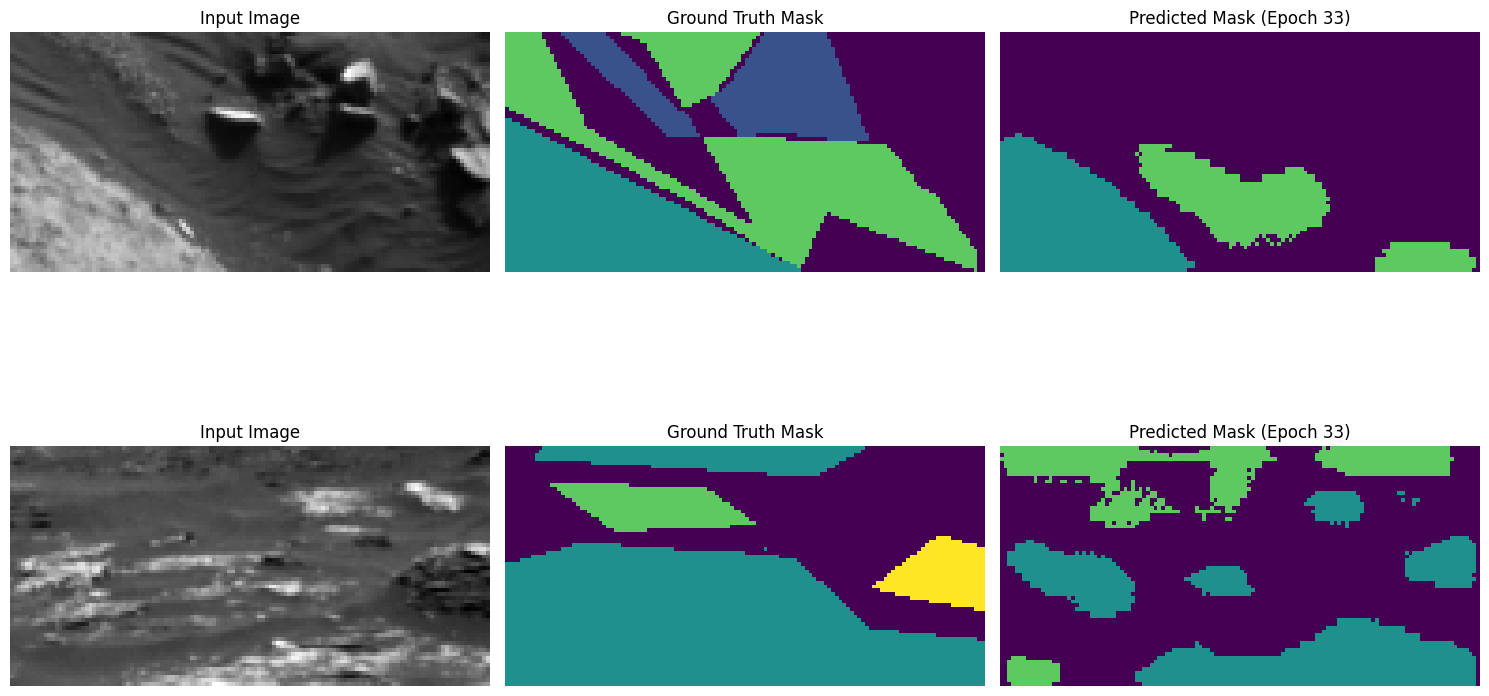

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.8374 - loss: 0.4201 - mean_io_u_5: 0.6715 - mean_iou: 0.6715 - val_accuracy: 0.7317 - val_loss: 0.7589 - val_mean_io_u_5: 0.4311 - val_mean_iou: 0.4311 - learning_rate: 5.0000e-05
Epoch 34/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8411 - loss: 0.4117 - mean_io_u_5: 0.6751 - mean_iou: 0.6751Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 34: val_loss did not improve from 0.74751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


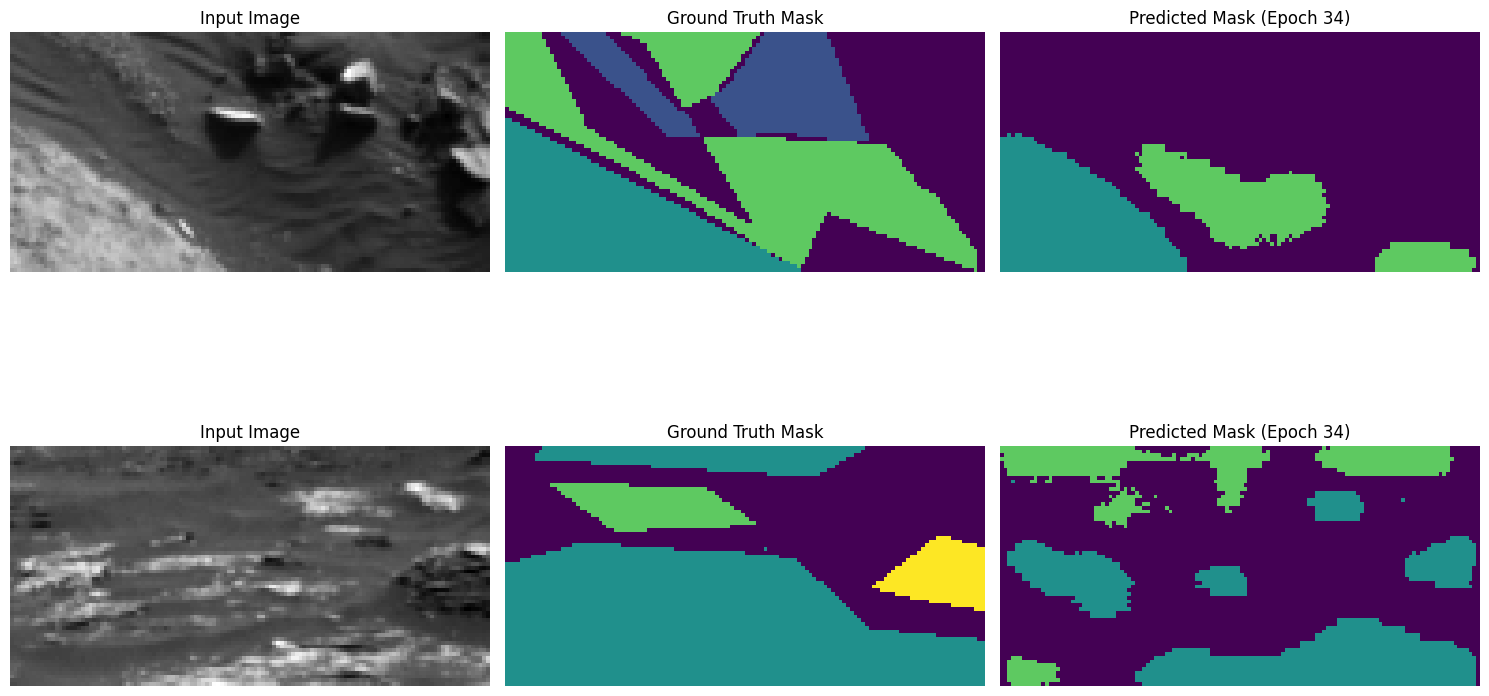

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - accuracy: 0.8411 - loss: 0.4118 - mean_io_u_5: 0.6751 - mean_iou: 0.6751 - val_accuracy: 0.7321 - val_loss: 0.7642 - val_mean_io_u_5: 0.4307 - val_mean_iou: 0.4307 - learning_rate: 5.0000e-05
Epoch 35/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8446 - loss: 0.4038 - mean_io_u_5: 0.6787 - mean_iou: 0.6787Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 35: val_loss did not improve from 0.74751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


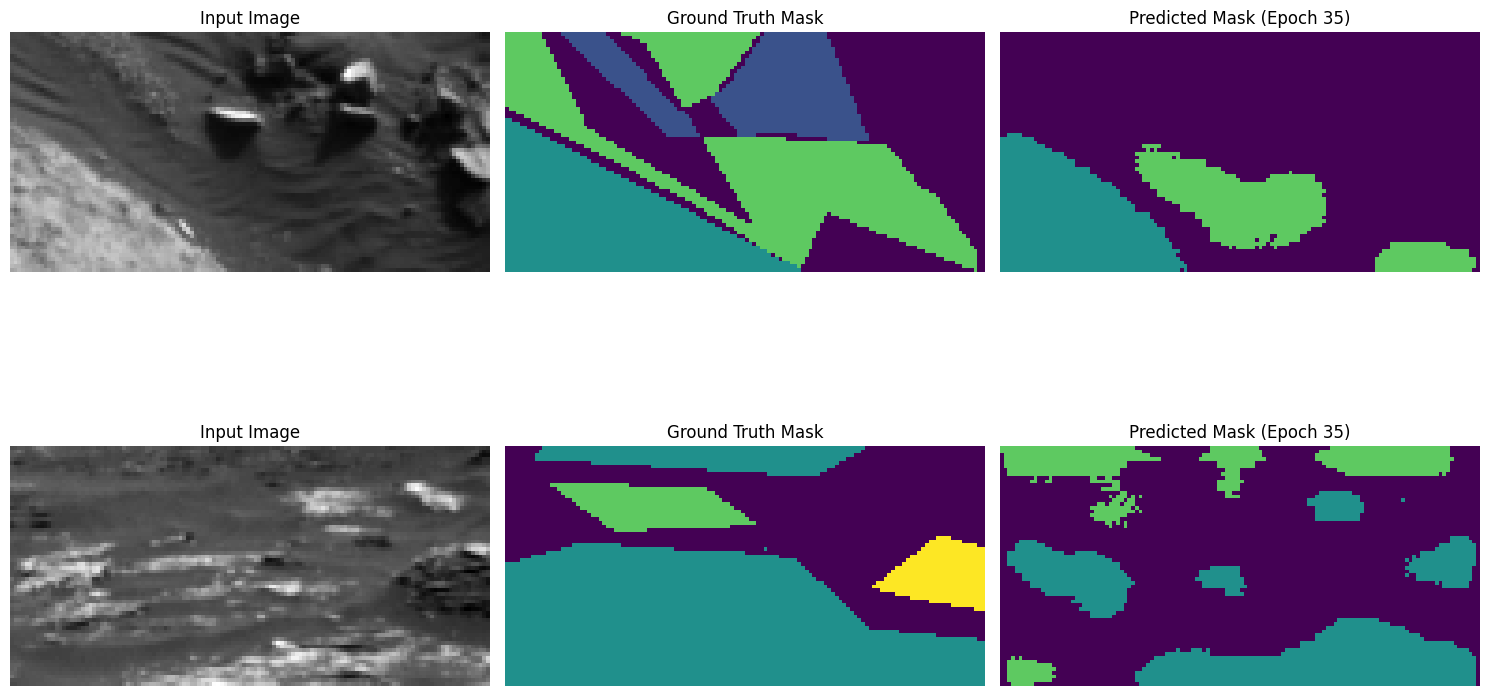

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.8446 - loss: 0.4039 - mean_io_u_5: 0.6787 - mean_iou: 0.6787 - val_accuracy: 0.7323 - val_loss: 0.7688 - val_mean_io_u_5: 0.4300 - val_mean_iou: 0.4300 - learning_rate: 5.0000e-05
Epoch 36/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8479 - loss: 0.3965 - mean_io_u_5: 0.6821 - mean_iou: 0.6821Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 36: val_loss did not improve from 0.74751

Epoch 36: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


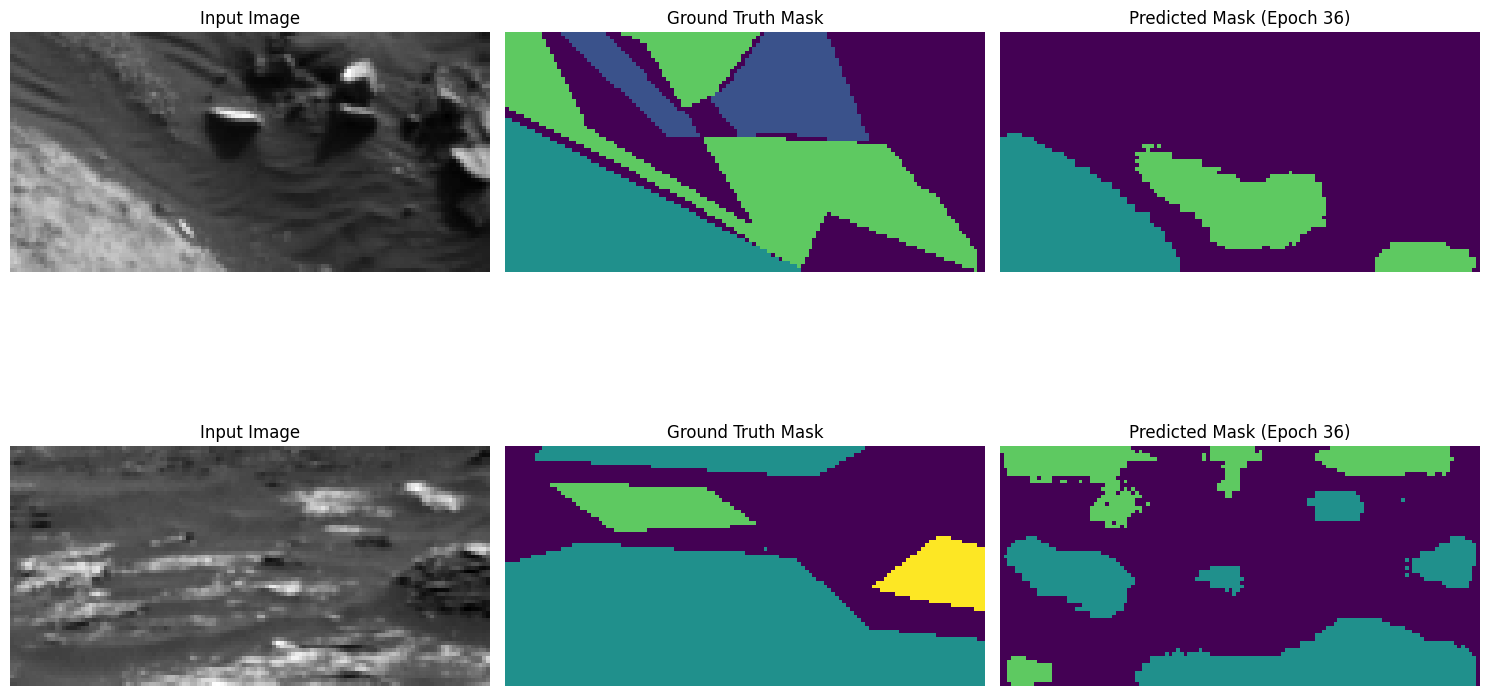

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.8478 - loss: 0.3966 - mean_io_u_5: 0.6821 - mean_iou: 0.6821 - val_accuracy: 0.7325 - val_loss: 0.7729 - val_mean_io_u_5: 0.4301 - val_mean_iou: 0.4301 - learning_rate: 5.0000e-05
Epoch 37/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8542 - loss: 0.3843 - mean_io_u_5: 0.6901 - mean_iou: 0.6901Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 37: val_loss did not improve from 0.74751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


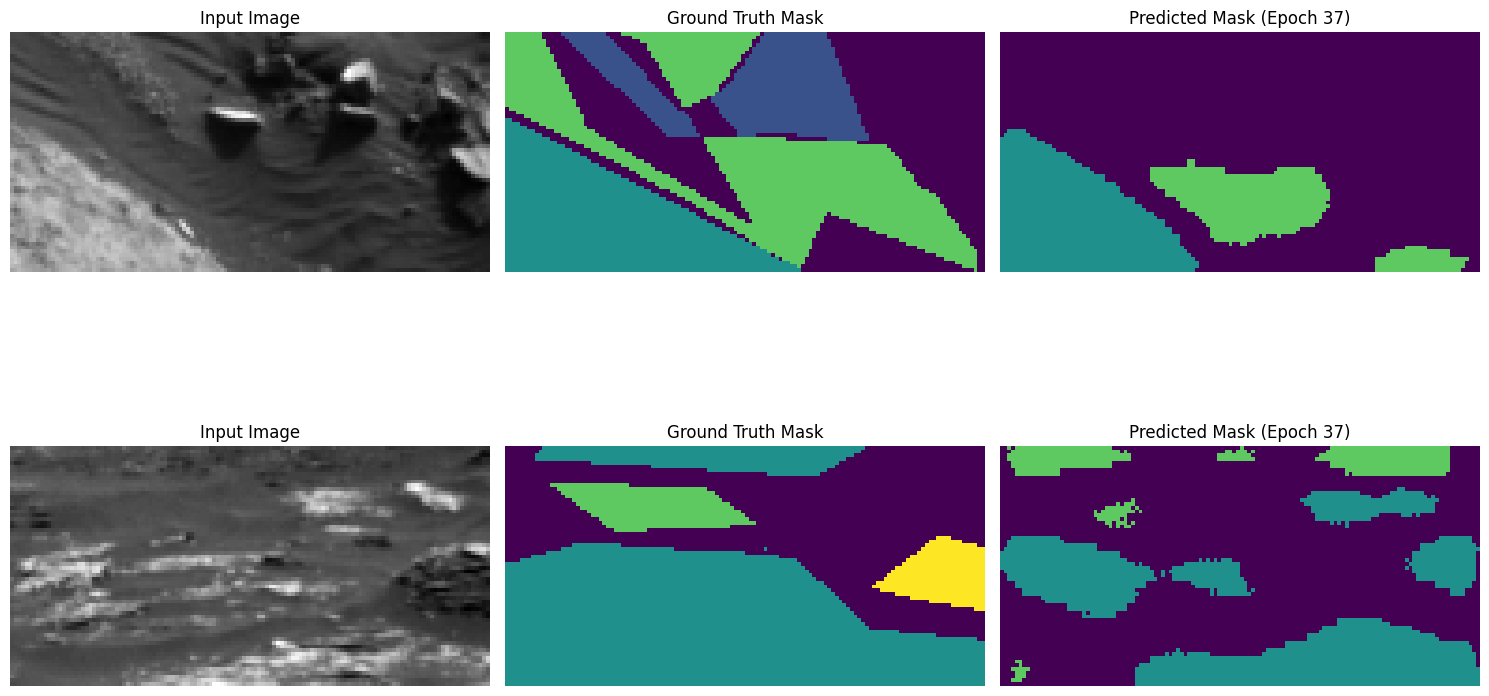

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - accuracy: 0.8542 - loss: 0.3844 - mean_io_u_5: 0.6901 - mean_iou: 0.6901 - val_accuracy: 0.7312 - val_loss: 0.7732 - val_mean_io_u_5: 0.4292 - val_mean_iou: 0.4292 - learning_rate: 2.5000e-05
Epoch 38/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8577 - loss: 0.3738 - mean_io_u_5: 0.6928 - mean_iou: 0.6928Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 38: val_loss did not improve from 0.74751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


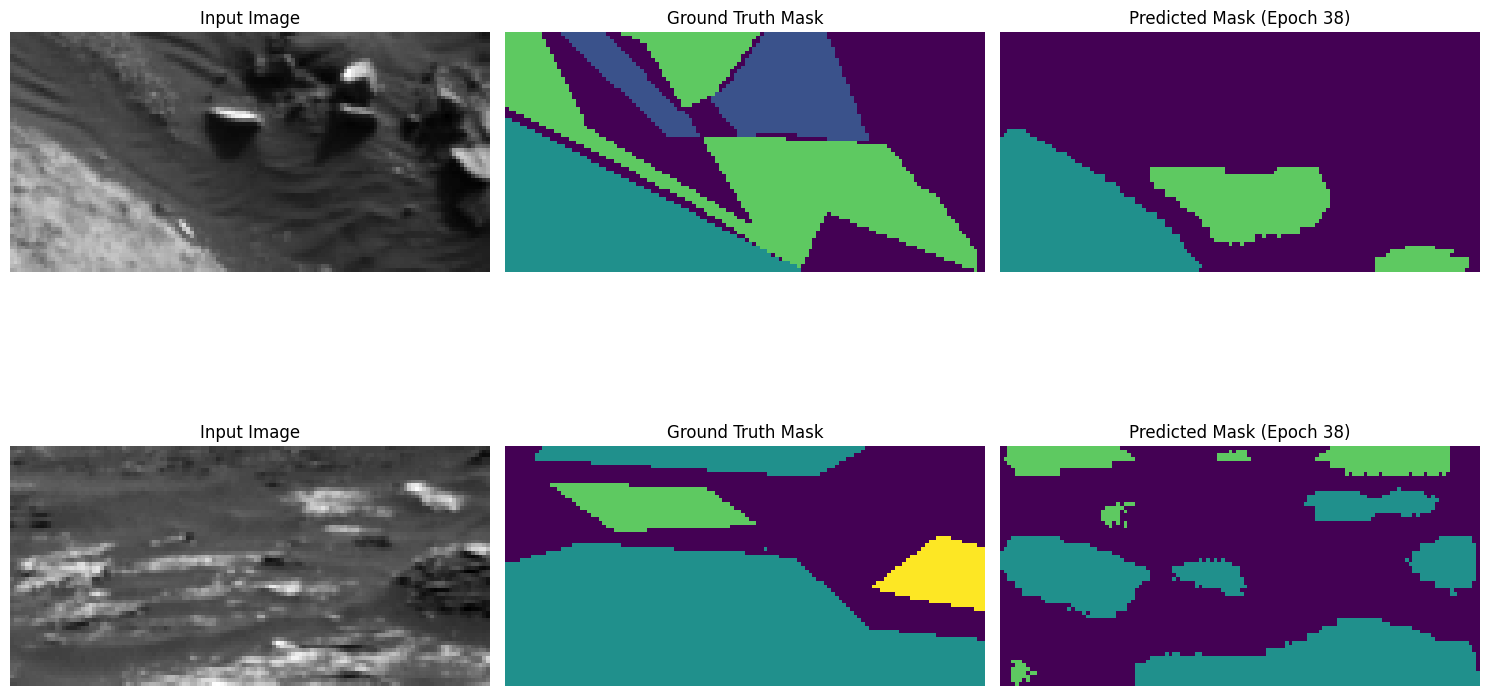

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - accuracy: 0.8577 - loss: 0.3739 - mean_io_u_5: 0.6928 - mean_iou: 0.6928 - val_accuracy: 0.7312 - val_loss: 0.7792 - val_mean_io_u_5: 0.4289 - val_mean_iou: 0.4289 - learning_rate: 2.5000e-05
Epoch 39/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8608 - loss: 0.3663 - mean_io_u_5: 0.6962 - mean_iou: 0.6962Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 39: val_loss did not improve from 0.74751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


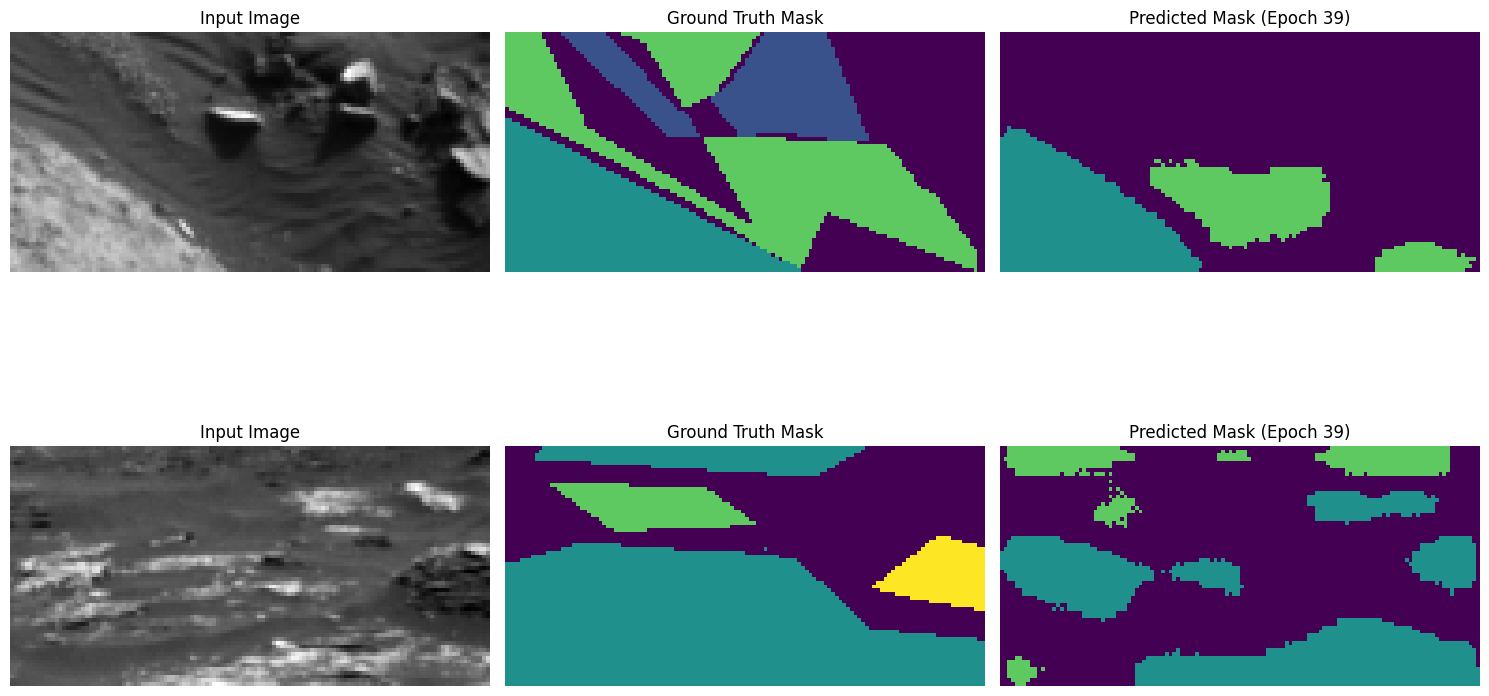

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.8608 - loss: 0.3663 - mean_io_u_5: 0.6962 - mean_iou: 0.6962 - val_accuracy: 0.7316 - val_loss: 0.7823 - val_mean_io_u_5: 0.4295 - val_mean_iou: 0.4295 - learning_rate: 2.5000e-05
Epoch 40/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8636 - loss: 0.3598 - mean_io_u_5: 0.6990 - mean_iou: 0.6990Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 40: val_loss did not improve from 0.74751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


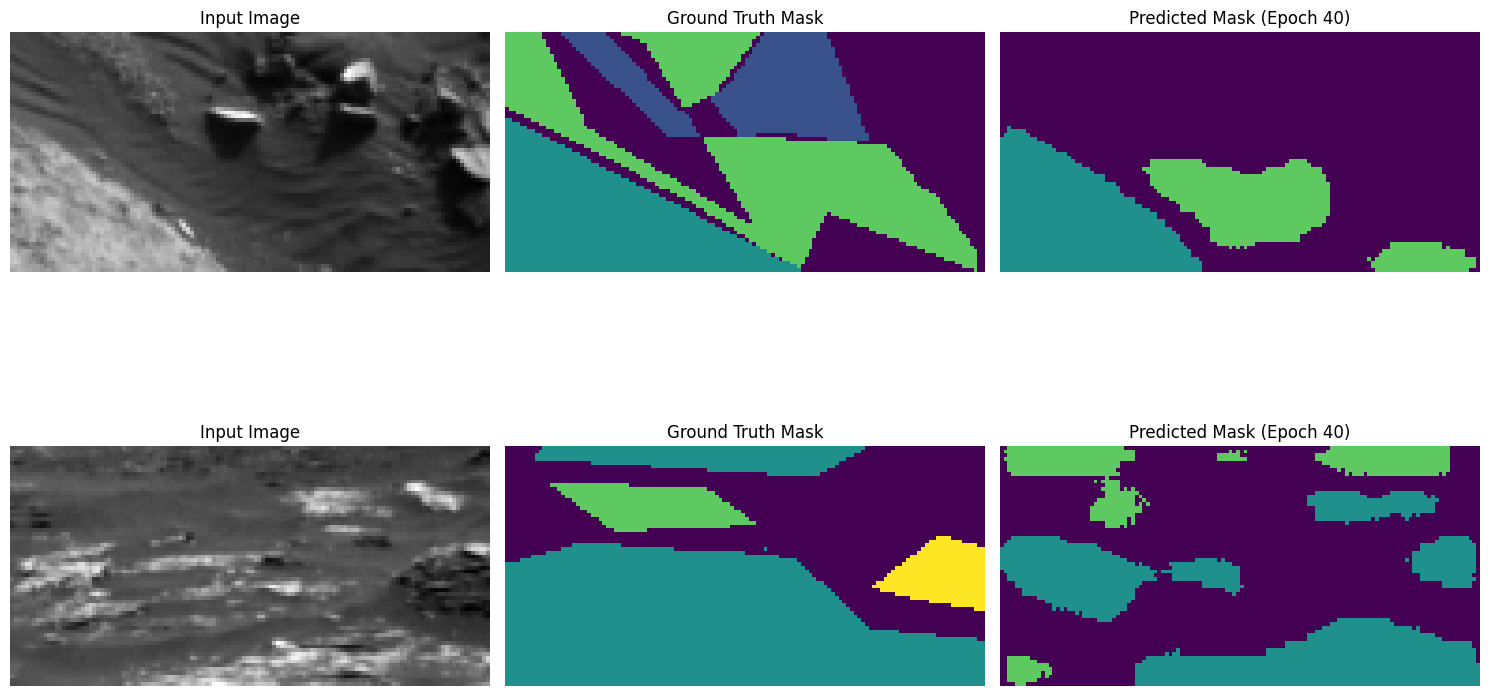

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 220ms/step - accuracy: 0.8636 - loss: 0.3599 - mean_io_u_5: 0.6990 - mean_iou: 0.6990 - val_accuracy: 0.7320 - val_loss: 0.7851 - val_mean_io_u_5: 0.4304 - val_mean_iou: 0.4304 - learning_rate: 2.5000e-05
Epoch 41/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8660 - loss: 0.3540 - mean_io_u_5: 0.7015 - mean_iou: 0.7015Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 41: val_loss did not improve from 0.74751

Epoch 41: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


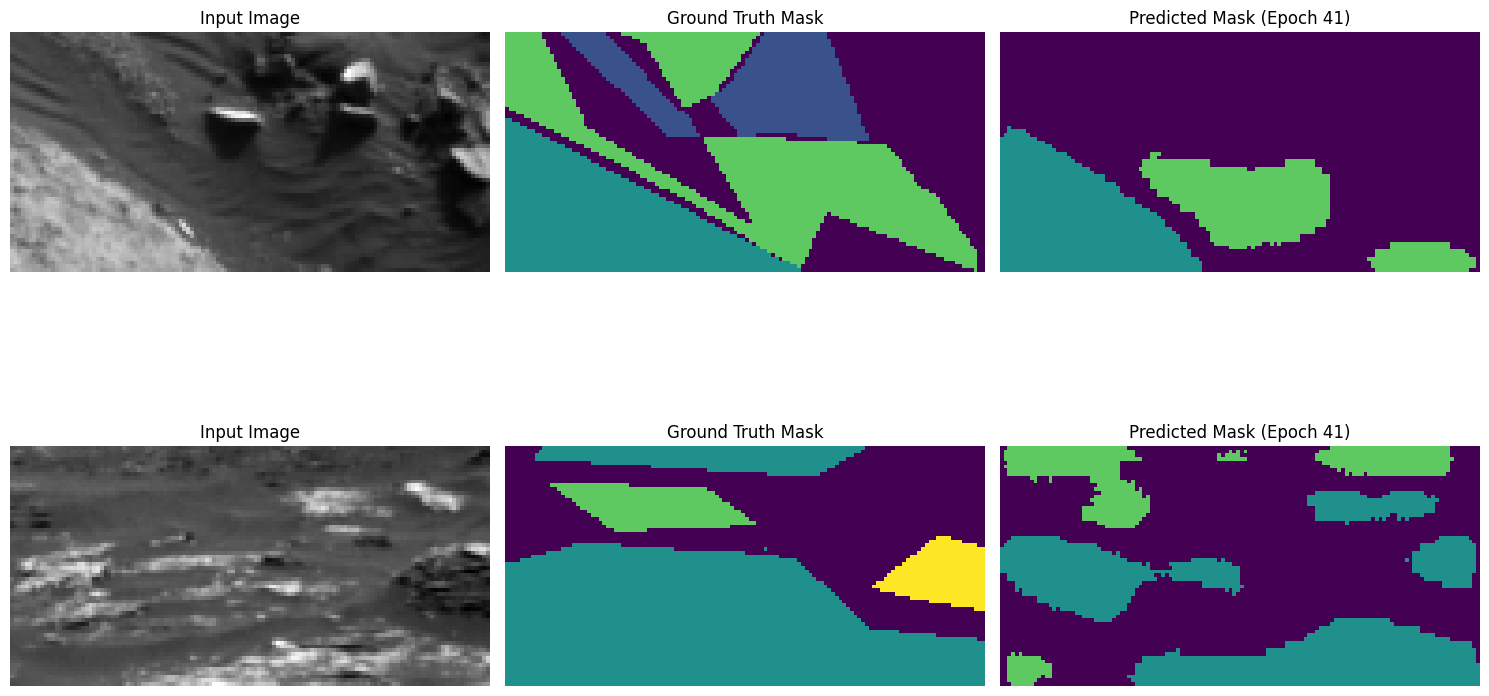

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.8660 - loss: 0.3541 - mean_io_u_5: 0.7015 - mean_iou: 0.7015 - val_accuracy: 0.7323 - val_loss: 0.7876 - val_mean_io_u_5: 0.4312 - val_mean_iou: 0.4312 - learning_rate: 2.5000e-05
Epoch 42/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8677 - loss: 0.3483 - mean_io_u_5: 0.7030 - mean_iou: 0.7030Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])
Epoch 42: val_mean_iou improved to 0.4359, saving model.

Epoch 42: val_loss did not improve from 0.74751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


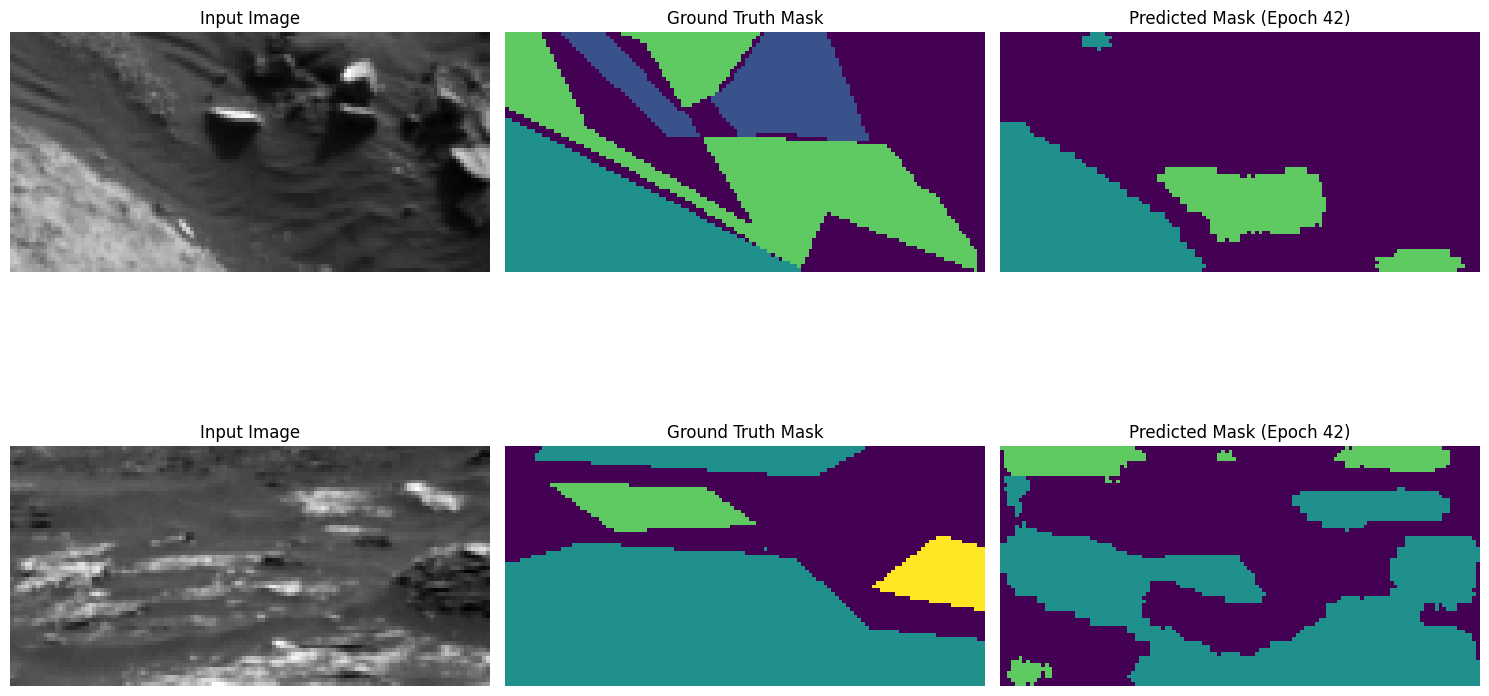

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 223ms/step - accuracy: 0.8677 - loss: 0.3484 - mean_io_u_5: 0.7030 - mean_iou: 0.7030 - val_accuracy: 0.7365 - val_loss: 0.7832 - val_mean_io_u_5: 0.4359 - val_mean_iou: 0.4359 - learning_rate: 1.2500e-05
Epoch 43/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8713 - loss: 0.3416 - mean_io_u_5: 0.7069 - mean_iou: 0.7069Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 43: val_loss did not improve from 0.74751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


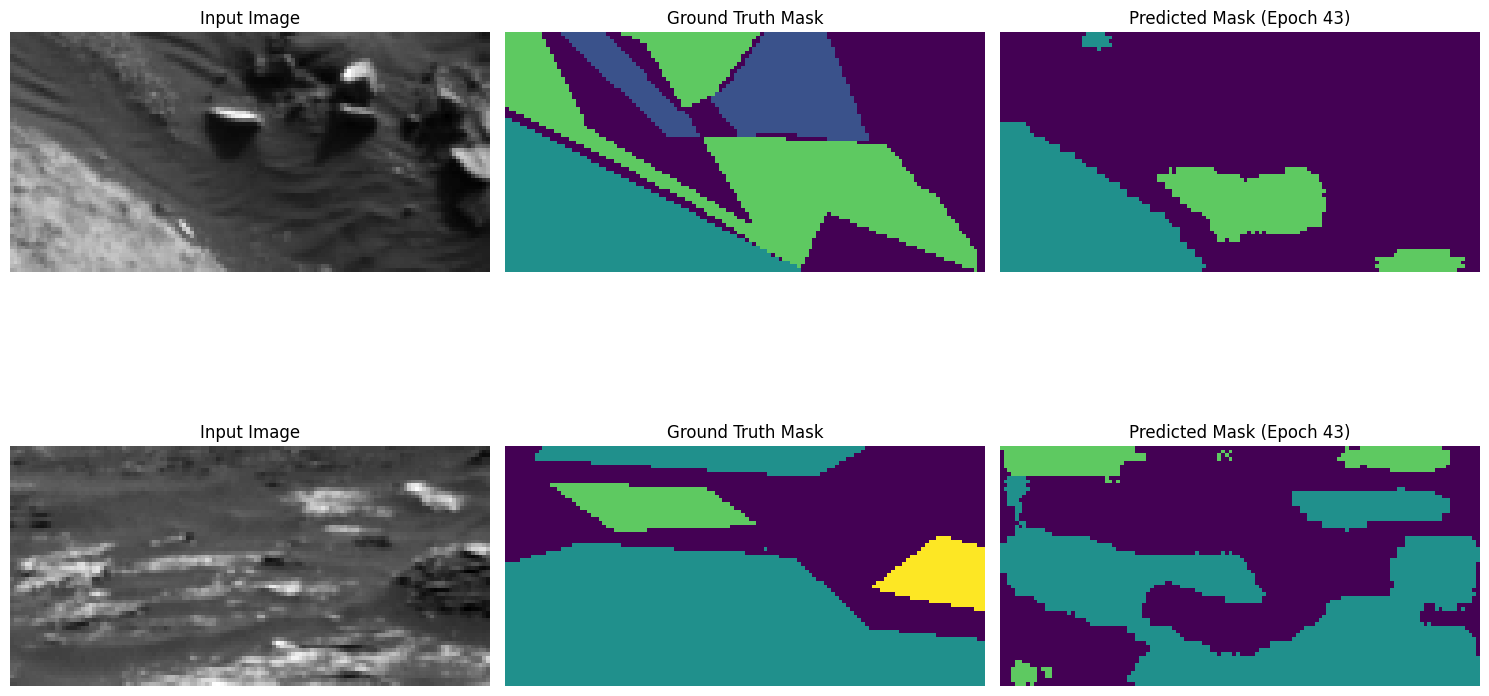

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 228ms/step - accuracy: 0.8712 - loss: 0.3417 - mean_io_u_5: 0.7069 - mean_iou: 0.7069 - val_accuracy: 0.7366 - val_loss: 0.7866 - val_mean_io_u_5: 0.4354 - val_mean_iou: 0.4354 - learning_rate: 1.2500e-05
Epoch 44/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8728 - loss: 0.3378 - mean_io_u_5: 0.7082 - mean_iou: 0.7082Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 44: val_loss did not improve from 0.74751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


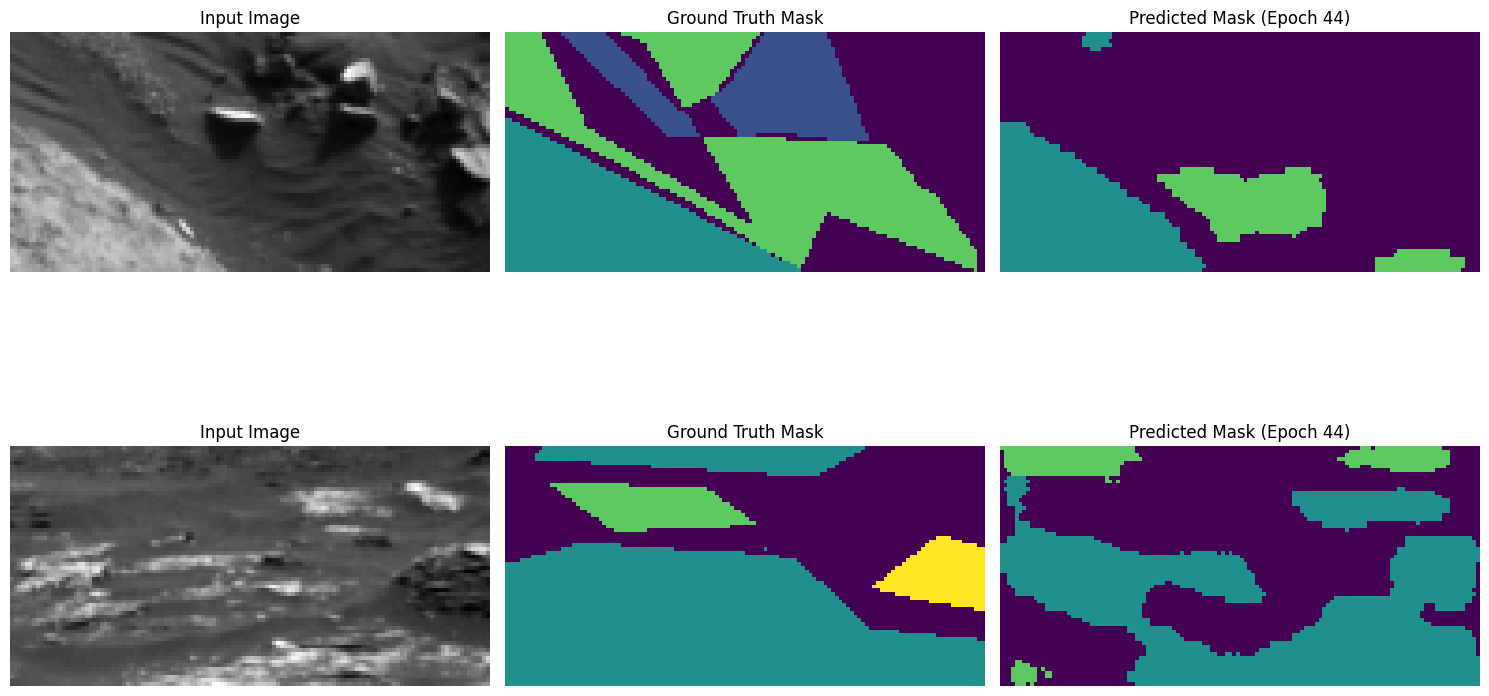

94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 218ms/step - accuracy: 0.8728 - loss: 0.3379 - mean_io_u_5: 0.7082 - mean_iou: 0.7082 - val_accuracy: 0.7368 - val_loss: 0.7895 - val_mean_io_u_5: 0.4354 - val_mean_iou: 0.4354 - learning_rate: 1.2500e-05
Epoch 45/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8743 - loss: 0.3342 - mean_io_u_5: 0.7097 - mean_iou: 0.7097Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 45: val_loss did not improve from 0.74751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


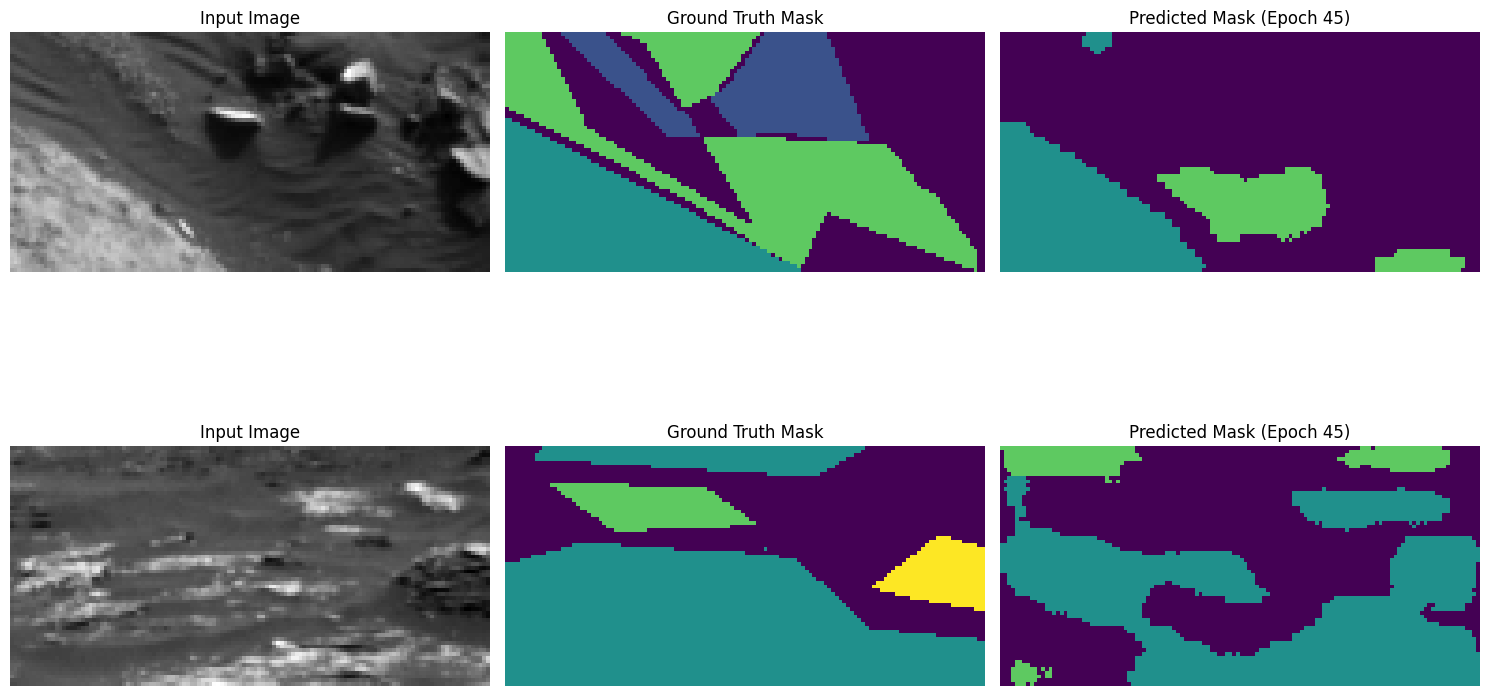

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - accuracy: 0.8743 - loss: 0.3343 - mean_io_u_5: 0.7096 - mean_iou: 0.7096 - val_accuracy: 0.7370 - val_loss: 0.7932 - val_mean_io_u_5: 0.4355 - val_mean_iou: 0.4355 - learning_rate: 1.2500e-05
Epoch 46/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8758 - loss: 0.3307 - mean_io_u_5: 0.7111 - mean_iou: 0.7111Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 46: val_loss did not improve from 0.74751

Epoch 46: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


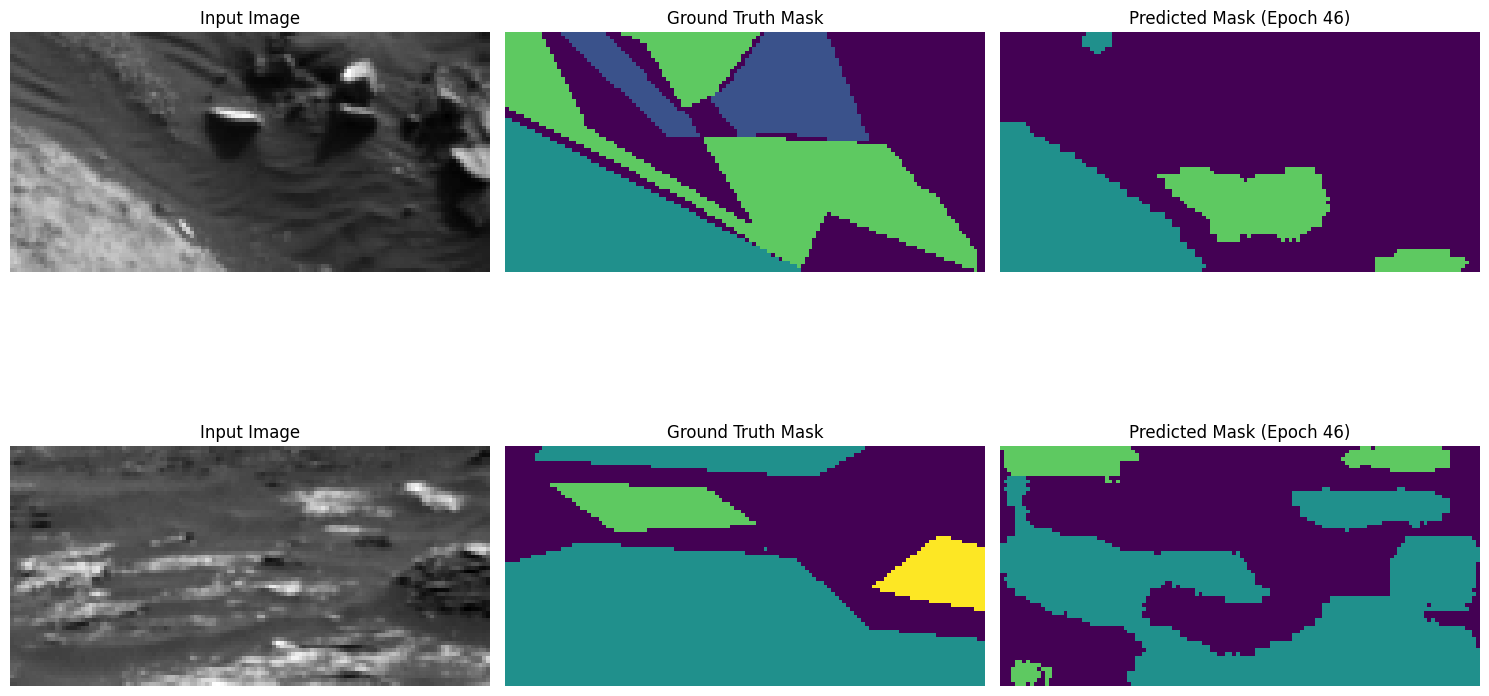

94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 218ms/step - accuracy: 0.8758 - loss: 0.3307 - mean_io_u_5: 0.7111 - mean_iou: 0.7111 - val_accuracy: 0.7371 - val_loss: 0.7964 - val_mean_io_u_5: 0.4356 - val_mean_iou: 0.4356 - learning_rate: 1.2500e-05
Epoch 47/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8787 - loss: 0.3220 - mean_io_u_5: 0.7141 - mean_iou: 0.7141Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])
Epoch 47: val_mean_iou improved to 0.4392, saving model.

Epoch 47: val_loss did not improve from 0.74751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


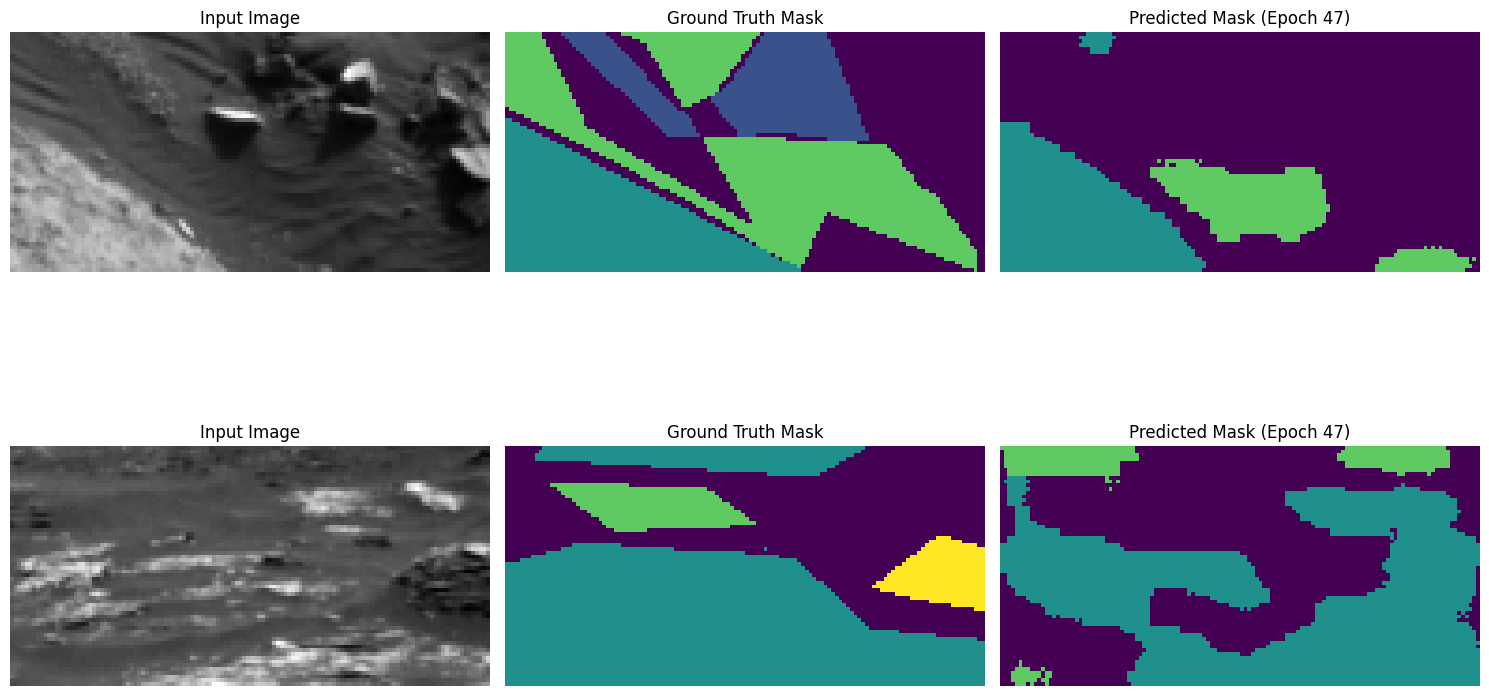

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step - accuracy: 0.8787 - loss: 0.3221 - mean_io_u_5: 0.7141 - mean_iou: 0.7141 - val_accuracy: 0.7389 - val_loss: 0.7741 - val_mean_io_u_5: 0.4392 - val_mean_iou: 0.4392 - learning_rate: 6.2500e-06
Epoch 48/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8790 - loss: 0.3205 - mean_io_u_5: 0.7139 - mean_iou: 0.7139Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 48: val_loss did not improve from 0.74751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


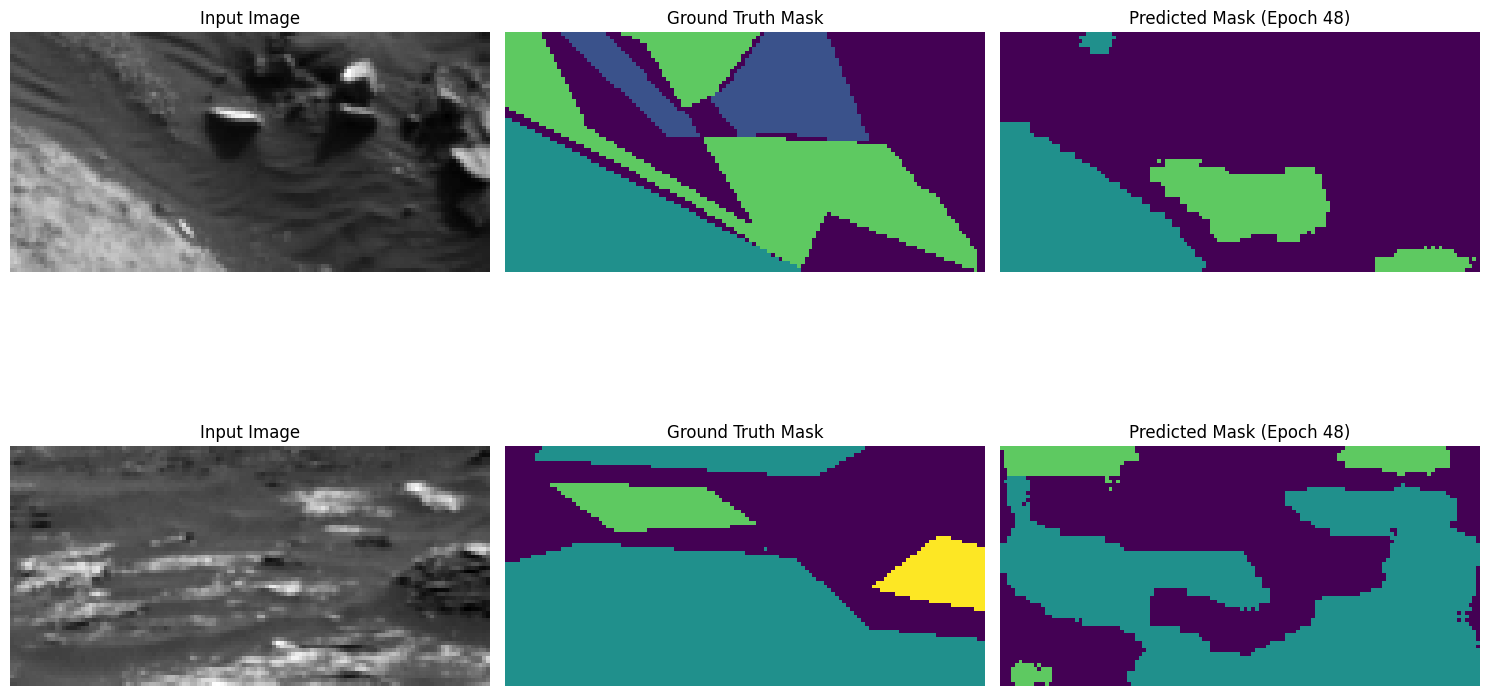

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 220ms/step - accuracy: 0.8790 - loss: 0.3205 - mean_io_u_5: 0.7139 - mean_iou: 0.7139 - val_accuracy: 0.7389 - val_loss: 0.7754 - val_mean_io_u_5: 0.4390 - val_mean_iou: 0.4390 - learning_rate: 6.2500e-06
Epoch 49/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8802 - loss: 0.3179 - mean_io_u_5: 0.7150 - mean_iou: 0.7150Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 49: val_loss did not improve from 0.74751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


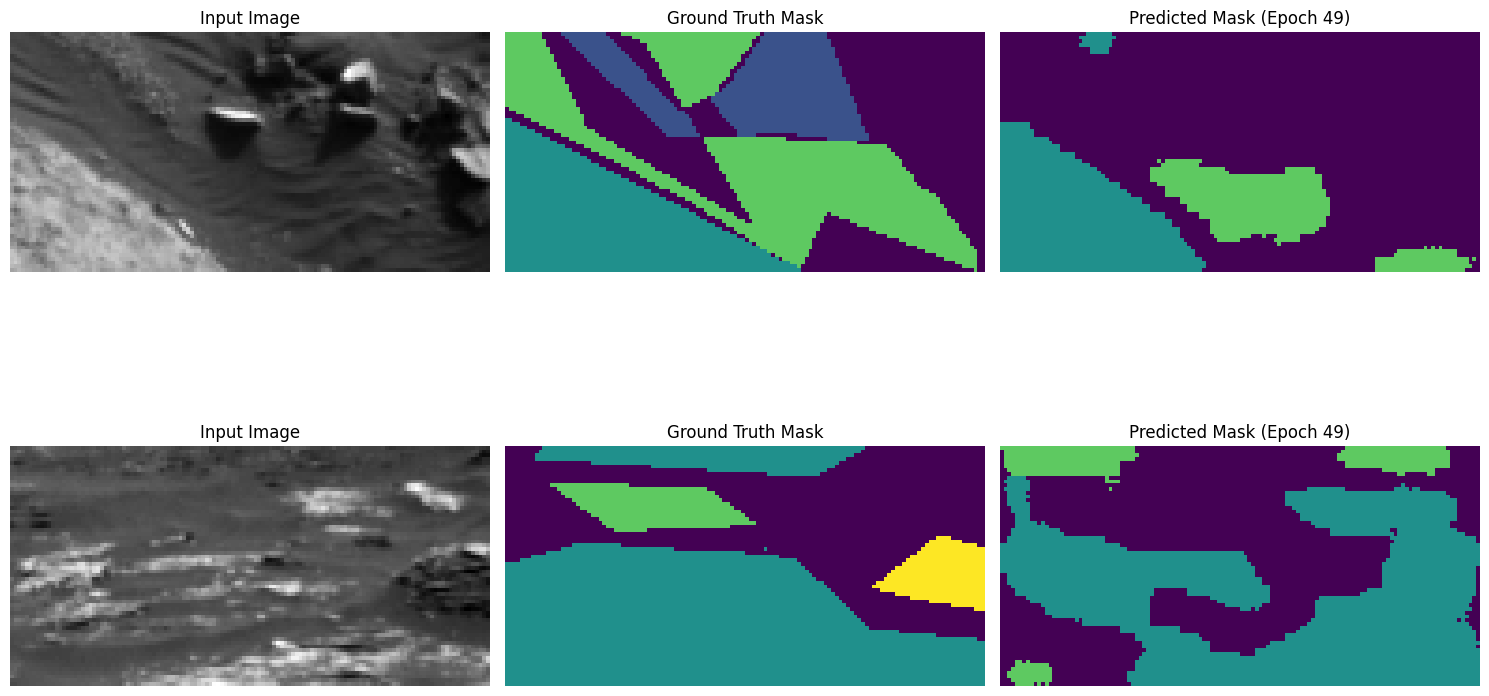

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step - accuracy: 0.8801 - loss: 0.3179 - mean_io_u_5: 0.7150 - mean_iou: 0.7150 - val_accuracy: 0.7389 - val_loss: 0.7771 - val_mean_io_u_5: 0.4389 - val_mean_iou: 0.4389 - learning_rate: 6.2500e-06
Epoch 50/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8811 - loss: 0.3157 - mean_io_u_5: 0.7159 - mean_iou: 0.7159Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 50: val_loss did not improve from 0.74751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


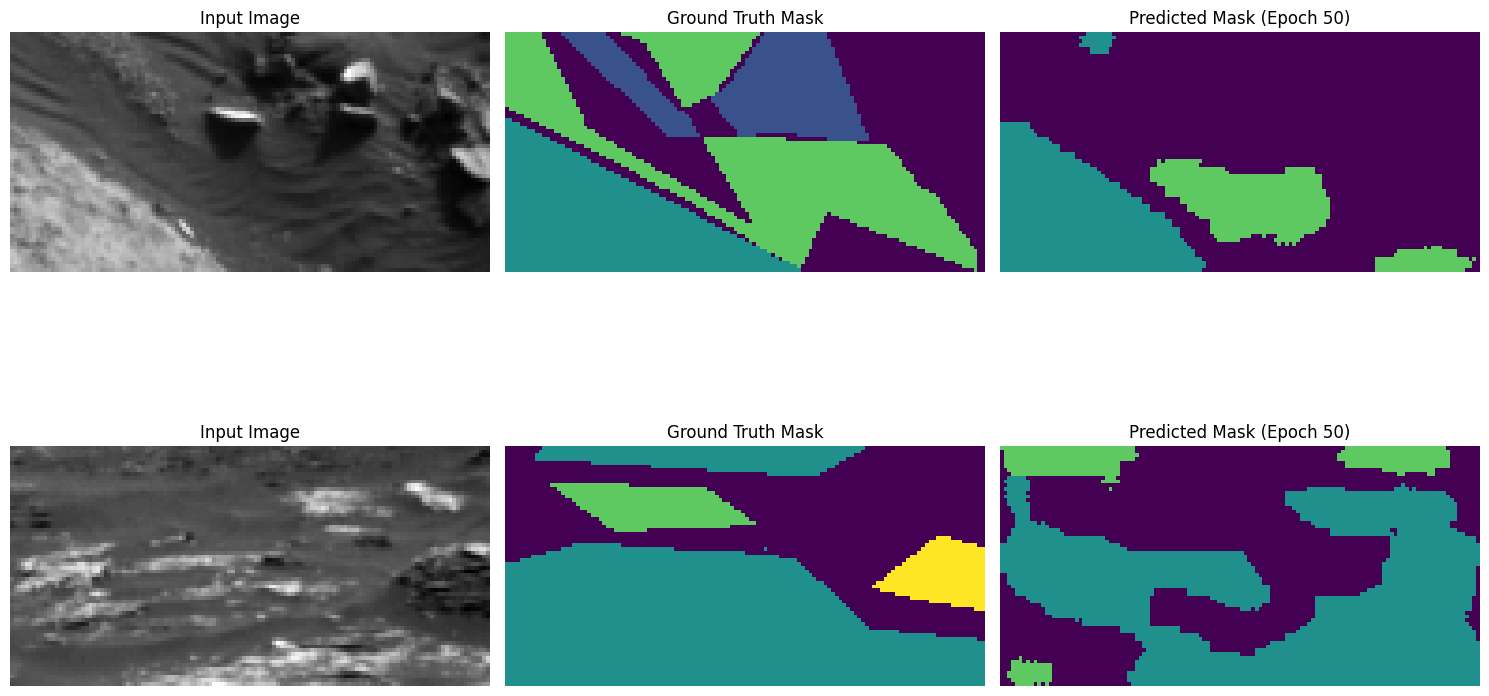

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 220ms/step - accuracy: 0.8811 - loss: 0.3157 - mean_io_u_5: 0.7159 - mean_iou: 0.7159 - val_accuracy: 0.7389 - val_loss: 0.7790 - val_mean_io_u_5: 0.4390 - val_mean_iou: 0.4390 - learning_rate: 6.2500e-06
Epoch 51/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8820 - loss: 0.3136 - mean_io_u_5: 0.7168 - mean_iou: 0.7168Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 51: val_loss did not improve from 0.74751

Epoch 51: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


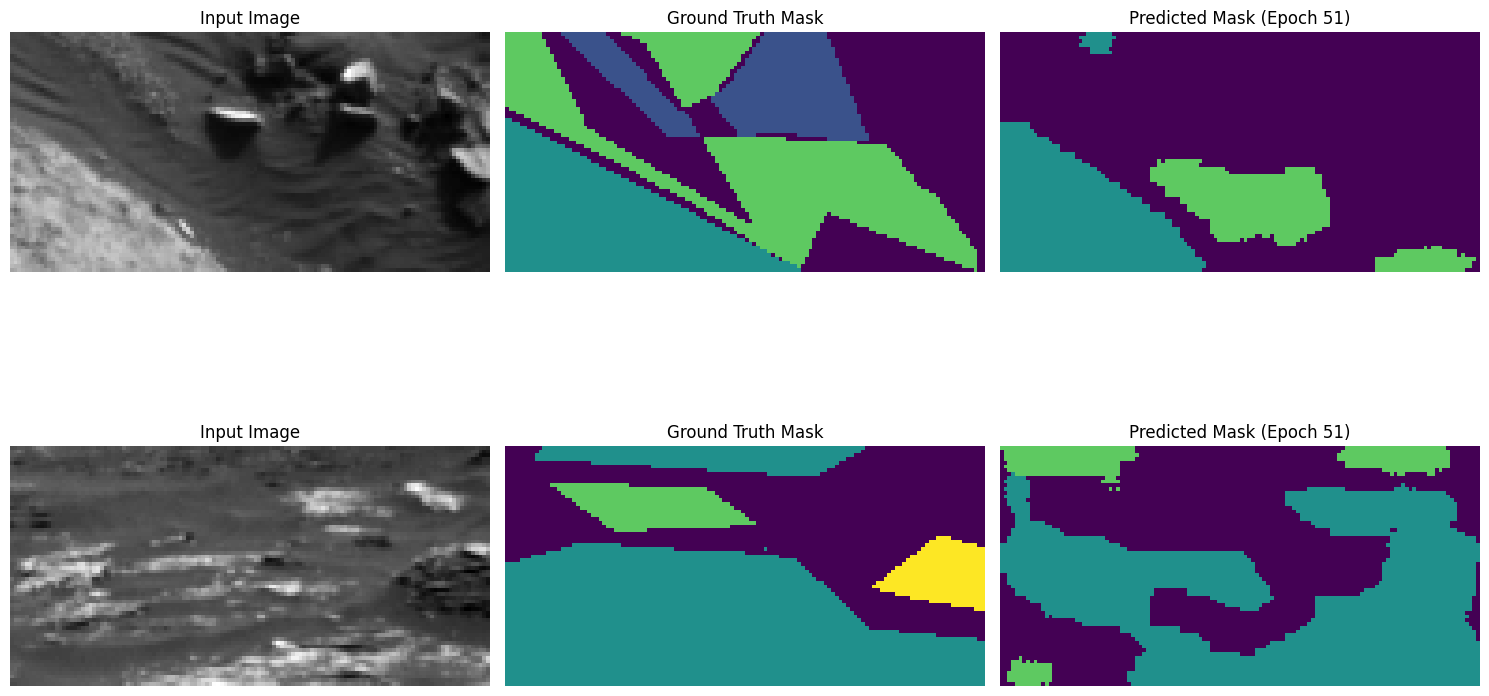

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.8820 - loss: 0.3137 - mean_io_u_5: 0.7168 - mean_iou: 0.7168 - val_accuracy: 0.7390 - val_loss: 0.7807 - val_mean_io_u_5: 0.4390 - val_mean_iou: 0.4390 - learning_rate: 6.2500e-06
Epoch 52/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8848 - loss: 0.3065 - mean_io_u_5: 0.7201 - mean_iou: 0.7201Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 52: val_loss did not improve from 0.74751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


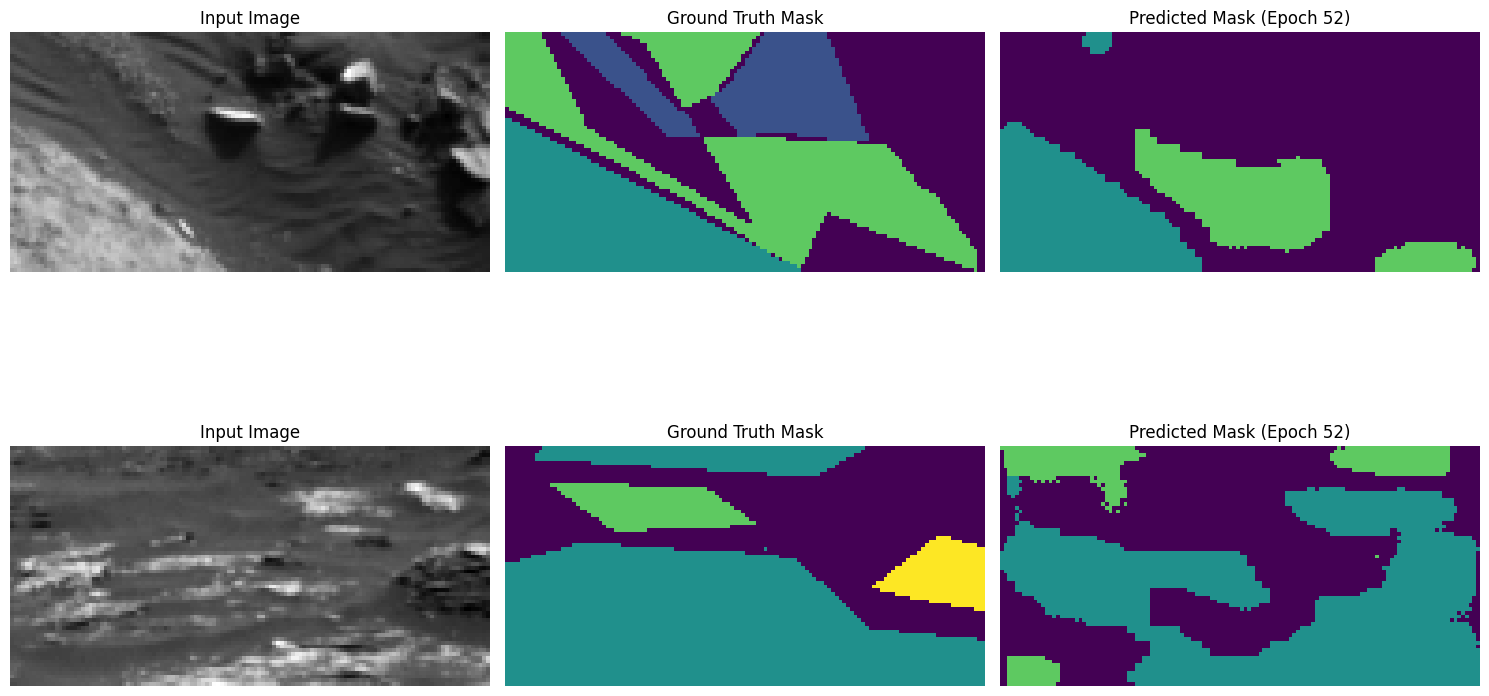

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.8847 - loss: 0.3065 - mean_io_u_5: 0.7201 - mean_iou: 0.7201 - val_accuracy: 0.7410 - val_loss: 0.7577 - val_mean_io_u_5: 0.4382 - val_mean_iou: 0.4382 - learning_rate: 3.1250e-06
Epoch 53/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8857 - loss: 0.3038 - mean_io_u_5: 0.7206 - mean_iou: 0.7206Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 53: val_loss did not improve from 0.74751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


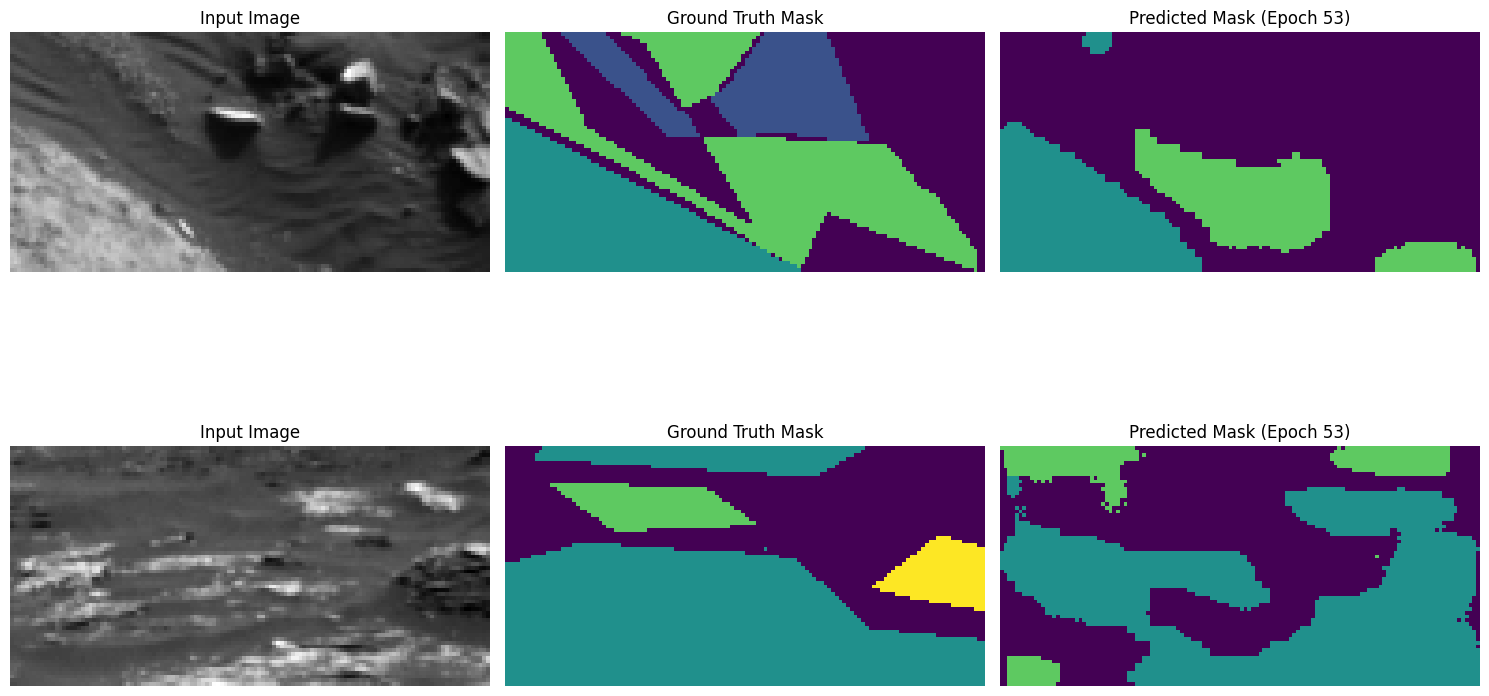

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.8857 - loss: 0.3039 - mean_io_u_5: 0.7206 - mean_iou: 0.7206 - val_accuracy: 0.7409 - val_loss: 0.7605 - val_mean_io_u_5: 0.4381 - val_mean_iou: 0.4381 - learning_rate: 3.1250e-06
Epoch 54/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8862 - loss: 0.3026 - mean_io_u_5: 0.7211 - mean_iou: 0.7211Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 54: val_loss did not improve from 0.74751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


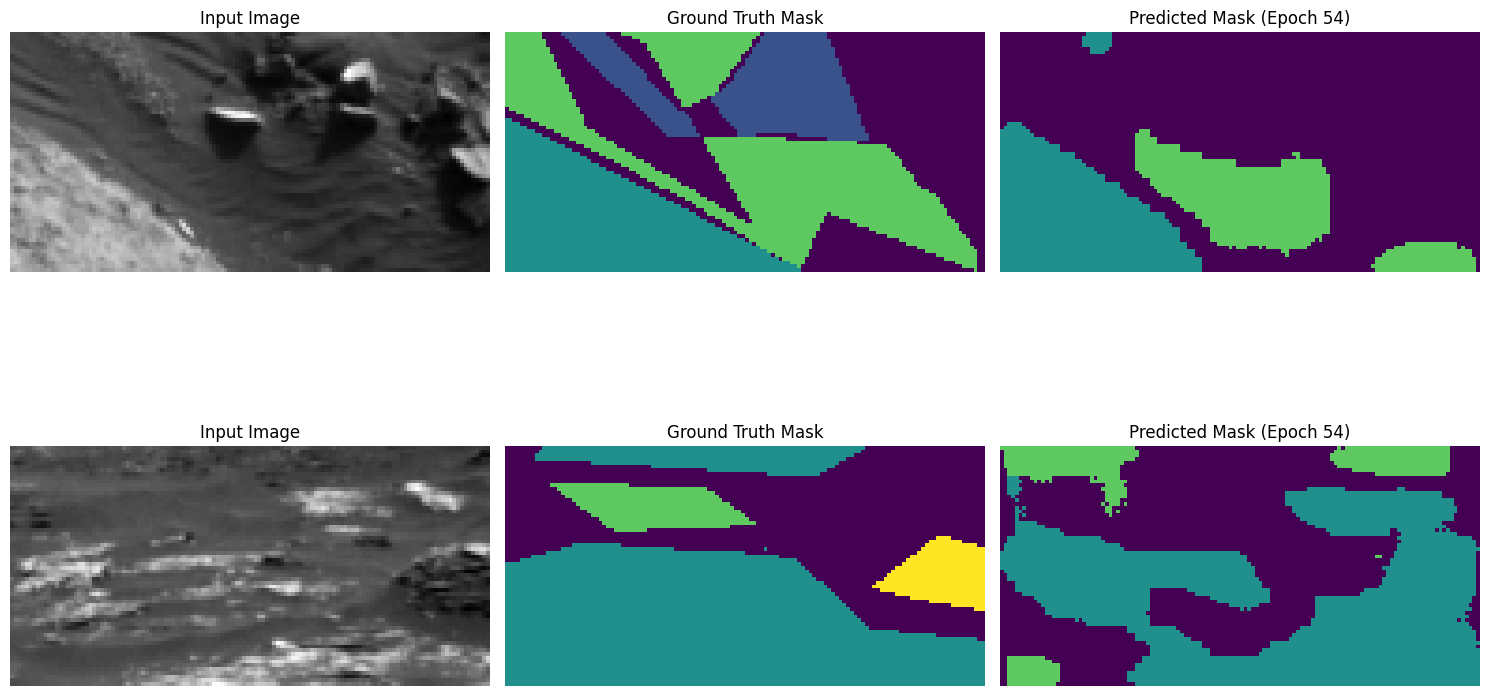

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.8862 - loss: 0.3027 - mean_io_u_5: 0.7211 - mean_iou: 0.7211 - val_accuracy: 0.7409 - val_loss: 0.7626 - val_mean_io_u_5: 0.4381 - val_mean_iou: 0.4381 - learning_rate: 3.1250e-06
Epoch 55/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8867 - loss: 0.3015 - mean_io_u_5: 0.7216 - mean_iou: 0.7216Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 55: val_loss did not improve from 0.74751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


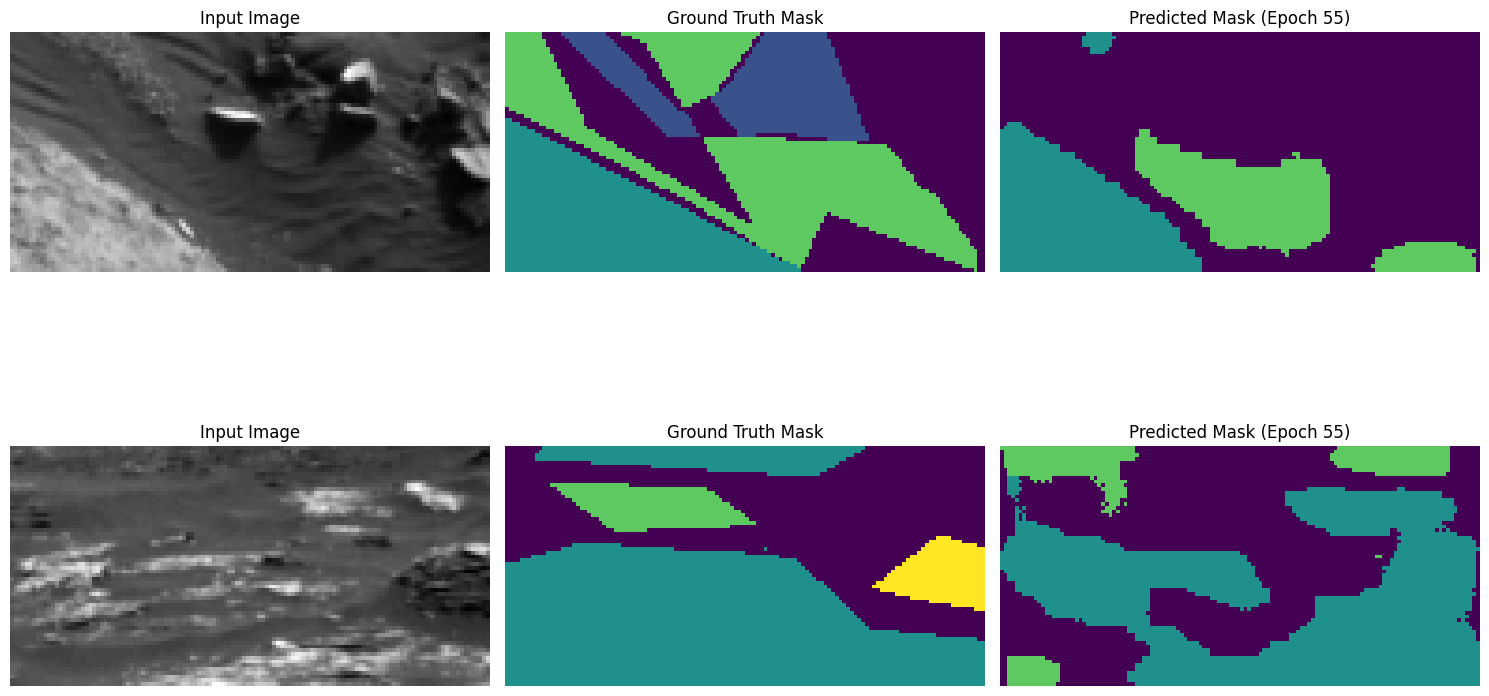

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.8867 - loss: 0.3016 - mean_io_u_5: 0.7216 - mean_iou: 0.7216 - val_accuracy: 0.7409 - val_loss: 0.7644 - val_mean_io_u_5: 0.4381 - val_mean_iou: 0.4381 - learning_rate: 3.1250e-06
Epoch 56/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8871 - loss: 0.3005 - mean_io_u_5: 0.7221 - mean_iou: 0.7221Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 56: val_loss did not improve from 0.74751

Epoch 56: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


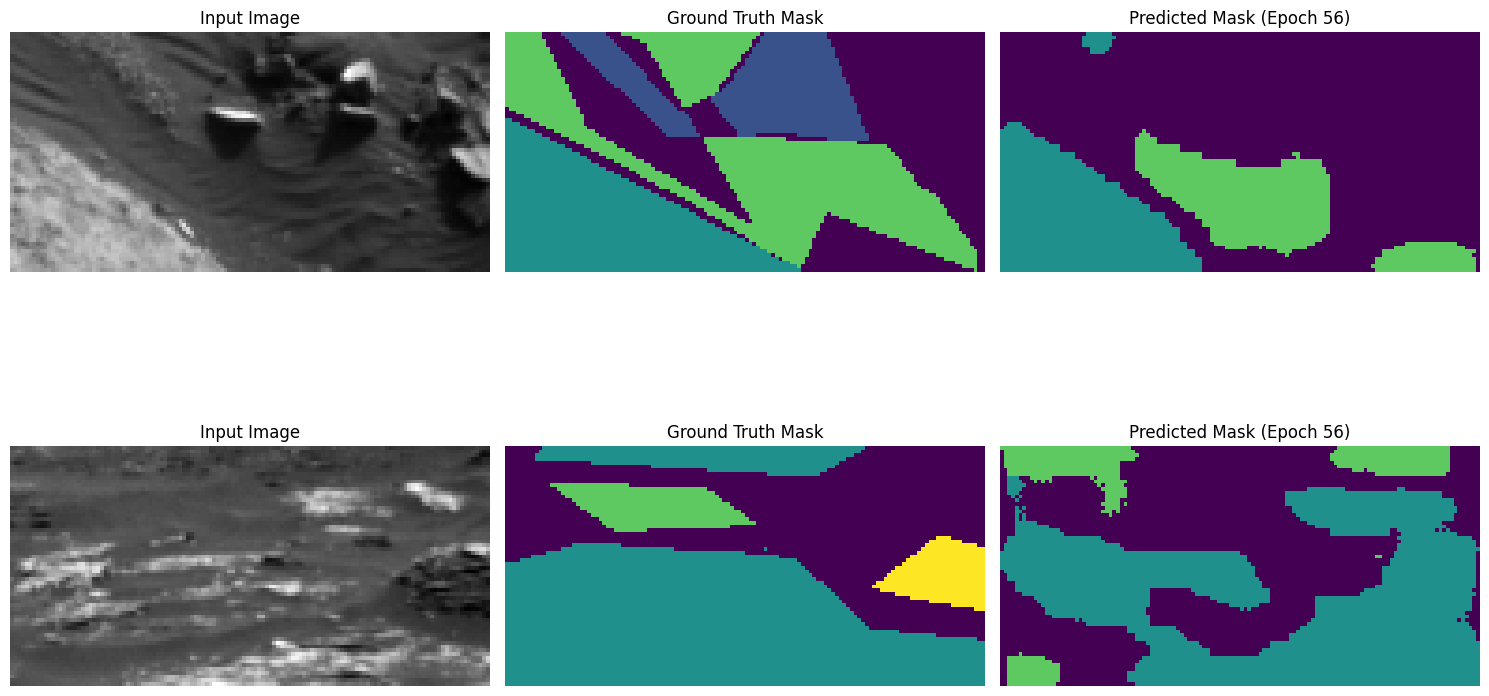

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.8871 - loss: 0.3005 - mean_io_u_5: 0.7221 - mean_iou: 0.7221 - val_accuracy: 0.7408 - val_loss: 0.7660 - val_mean_io_u_5: 0.4381 - val_mean_iou: 0.4381 - learning_rate: 3.1250e-06
Epoch 57/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8879 - loss: 0.2983 - mean_io_u_5: 0.7231 - mean_iou: 0.7231Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 57: val_loss did not improve from 0.74751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


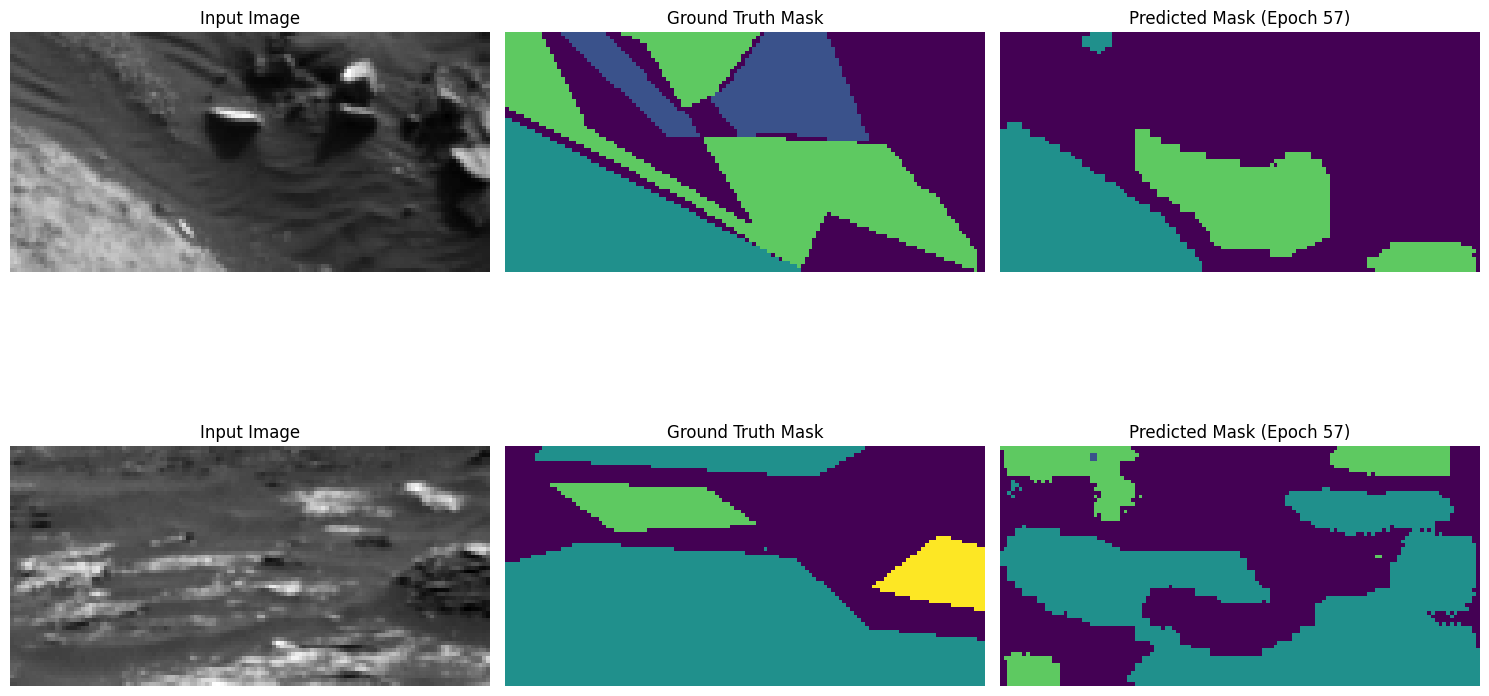

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.8879 - loss: 0.2984 - mean_io_u_5: 0.7231 - mean_iou: 0.7231 - val_accuracy: 0.7411 - val_loss: 0.7649 - val_mean_io_u_5: 0.4373 - val_mean_iou: 0.4373 - learning_rate: 1.5625e-06
Epoch 58/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8883 - loss: 0.2973 - mean_io_u_5: 0.7232 - mean_iou: 0.7232Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 58: val_loss did not improve from 0.74751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


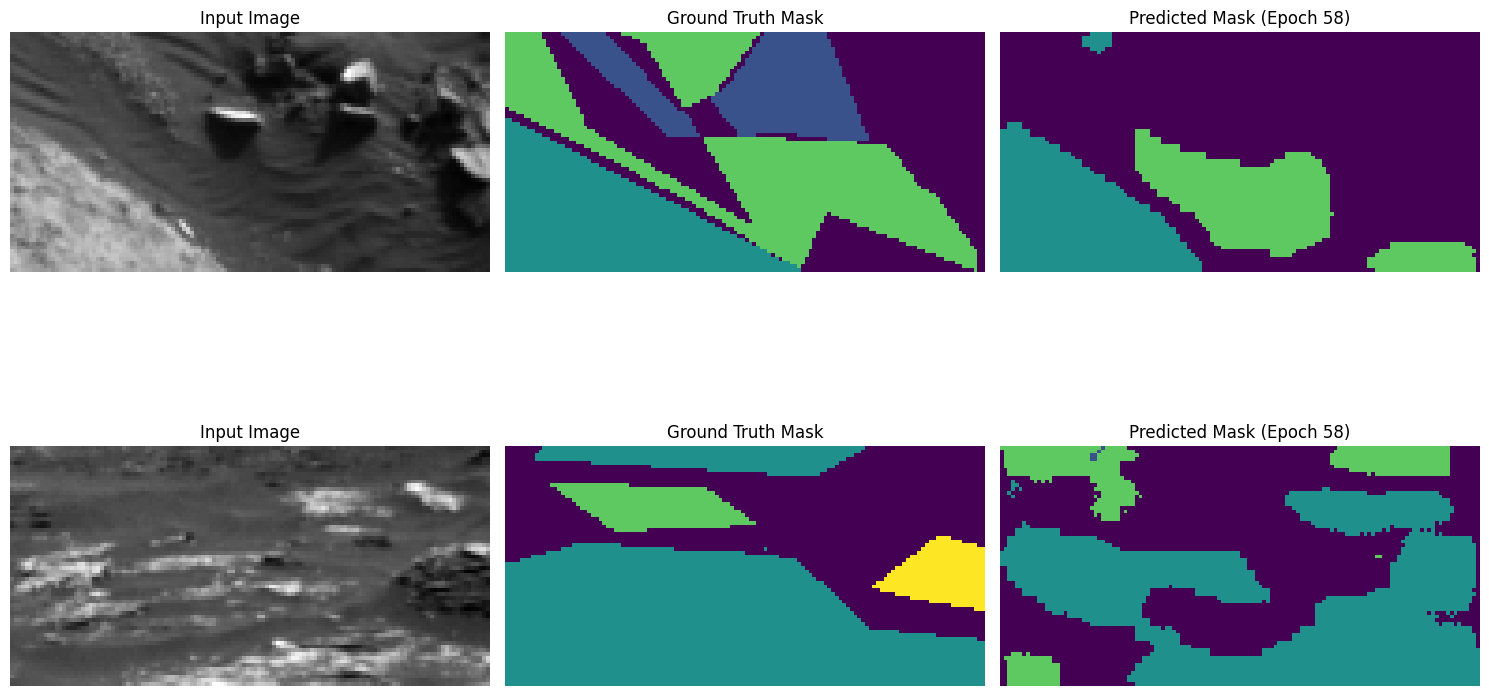

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.8883 - loss: 0.2973 - mean_io_u_5: 0.7232 - mean_iou: 0.7232 - val_accuracy: 0.7410 - val_loss: 0.7660 - val_mean_io_u_5: 0.4372 - val_mean_iou: 0.4372 - learning_rate: 1.5625e-06
Epoch 59/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8885 - loss: 0.2966 - mean_io_u_5: 0.7235 - mean_iou: 0.7235Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 59: val_loss did not improve from 0.74751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


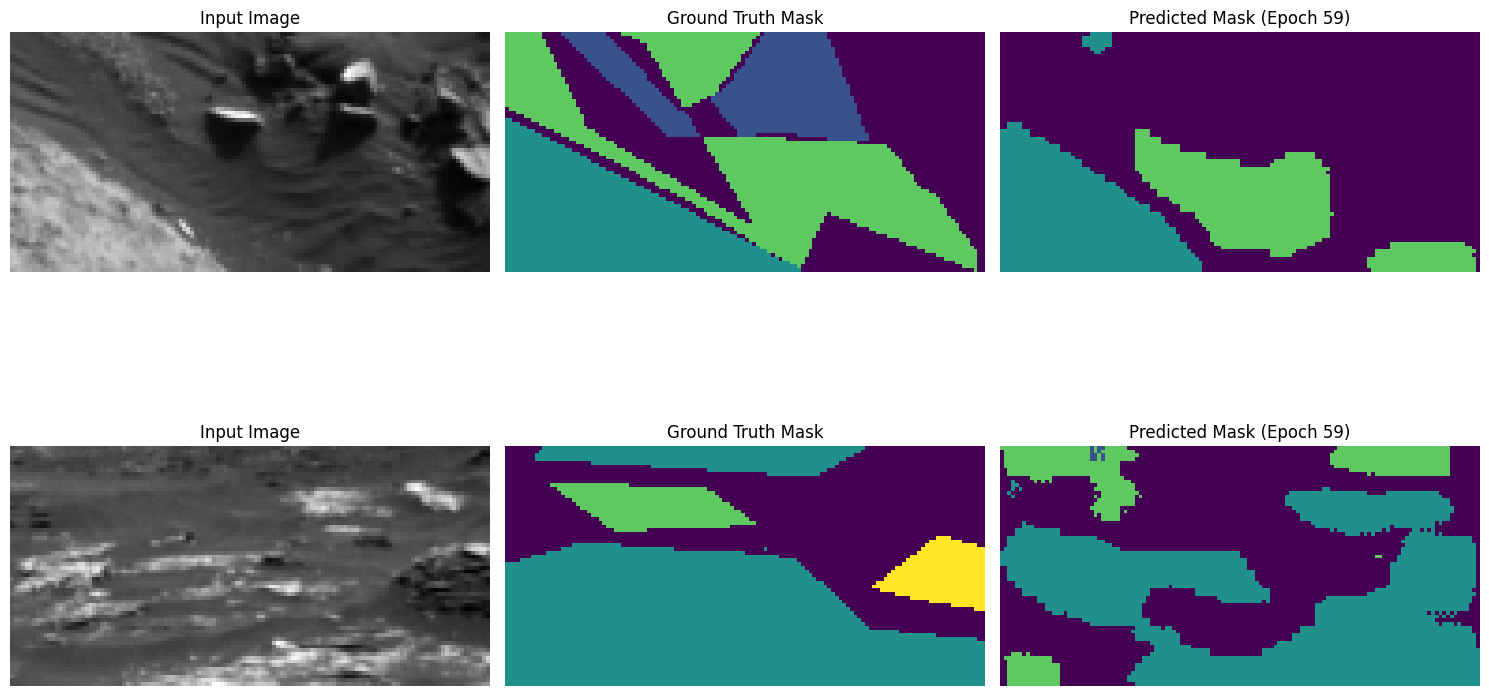

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.8885 - loss: 0.2967 - mean_io_u_5: 0.7235 - mean_iou: 0.7235 - val_accuracy: 0.7410 - val_loss: 0.7669 - val_mean_io_u_5: 0.4372 - val_mean_iou: 0.4372 - learning_rate: 1.5625e-06
Epoch 60/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8888 - loss: 0.2960 - mean_io_u_5: 0.7237 - mean_iou: 0.7237Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 60: val_loss did not improve from 0.74751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


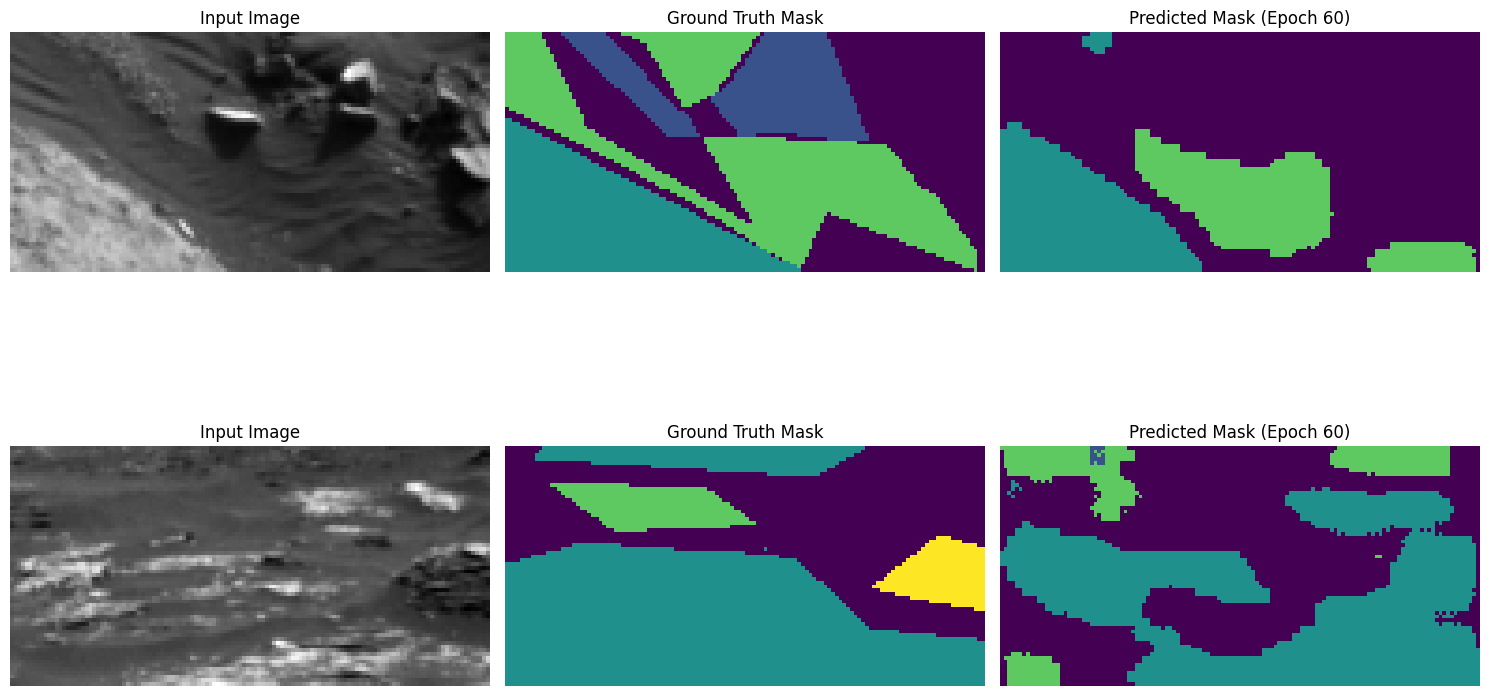

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - accuracy: 0.8888 - loss: 0.2961 - mean_io_u_5: 0.7237 - mean_iou: 0.7237 - val_accuracy: 0.7410 - val_loss: 0.7677 - val_mean_io_u_5: 0.4372 - val_mean_iou: 0.4372 - learning_rate: 1.5625e-06
Epoch 61/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8890 - loss: 0.2954 - mean_io_u_5: 0.7240 - mean_iou: 0.7240Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_5', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_5', 'val_mean_iou'])

Epoch 61: val_loss did not improve from 0.74751

Epoch 61: ReduceLROnPlateau reducing learning rate to 1e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


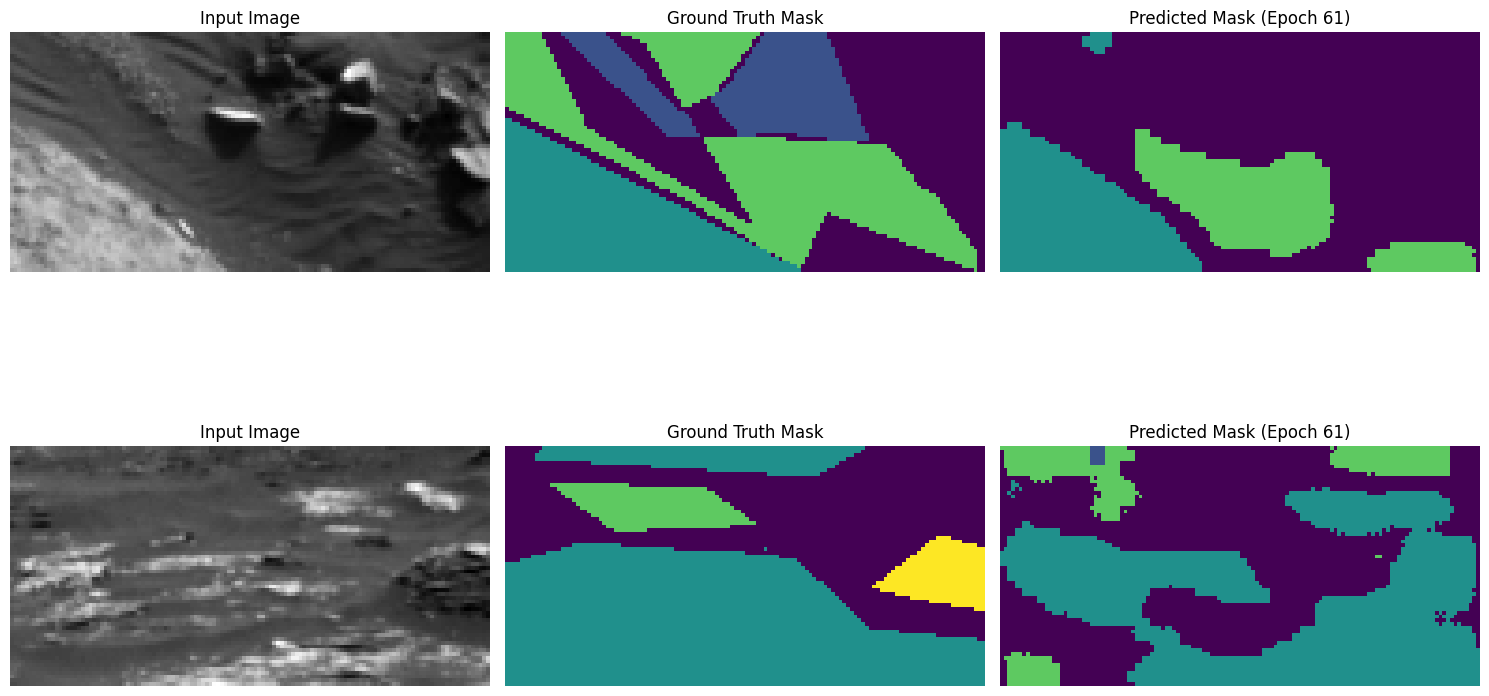

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.8890 - loss: 0.2955 - mean_io_u_5: 0.7240 - mean_iou: 0.7240 - val_accuracy: 0.7410 - val_loss: 0.7685 - val_mean_io_u_5: 0.4372 - val_mean_iou: 0.4372 - learning_rate: 1.5625e-06


In [87]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl

# Residual Block
def residual_block(x, filters):
    shortcut = x
    x = tfkl.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = tfkl.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    shortcut = tfkl.Conv2D(filters, (1, 1), padding='same')(shortcut)
    return tfkl.add([x, shortcut])

# Dice Loss
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
    return tf.reduce_mean(1 - numerator / (denominator + tf.keras.backend.epsilon()))

# Hybrid Loss Function
def combined_loss(weights):
    ce_loss = weighted_categorical_crossentropy(weights)
    def loss(y_true, y_pred):
        return ce_loss(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# U-Net with Residual Connections
def unet_with_residual_blocks(input_shape, num_classes):
    inputs = tfkl.Input(input_shape)

    # Encoder
    c1 = residual_block(inputs, 64)
    p1 = tfkl.MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 128)
    p2 = tfkl.MaxPooling2D((2, 2))(c2)

    c3 = residual_block(p2, 256)
    p3 = tfkl.MaxPooling2D((2, 2))(c3)

    c4 = residual_block(p3, 512)

    # Decoder
    u1 = tfkl.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u1 = tfkl.concatenate([u1, c3])
    d1 = residual_block(u1, 256)

    u2 = tfkl.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(d1)
    u2 = tfkl.concatenate([u2, c2])
    d2 = residual_block(u2, 128)

    u3 = tfkl.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d2)
    u3 = tfkl.concatenate([u3, c1])
    d3 = residual_block(u3, 64)

    outputs = tfkl.Conv2D(num_classes, (1, 1), activation='softmax')(d3)

    return tf.keras.Model(inputs, outputs)

# Initialize the model
input_shape = X_train.shape[1:]
num_classes = 5  # Replace with your number of classes
ignore_class = 0  # Class to ignore

#custom_mean_iou = CustomMeanIoU(num_classes=num_classes, ignore_class=0)

model = unet_with_residual_blocks(input_shape, num_classes)
# Define the optimizer with a specific learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)
# Compile the model


model.compile(optimizer=optimizer, 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy", mean_iou, MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])])

model.summary()
# Define callbacks
save_best_miou = SaveBestMeanIoU(filepath="best_model_mean_iou.h5", monitor="val_mean_iou", mode="max", verbose=1)


# Training the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),  # Add validation data
    #batch_size=32,
    epochs=1000,
    callbacks=[save_best_miou, early_stopping, model_checkpoint, reduce_lr, visualize_callback]
)


In [88]:
# Load the saved model
best_model = tf.keras.models.load_model("best_model_mean_iou.h5", custom_objects={"MeanIoU": tf.keras.metrics.MeanIoU})



In [89]:
model=best_model

In [90]:
#model.load_weights("best_model_mean_iou.h5")

In [91]:
model_filename = f"model_augmented_hvr_best_invert_noise.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

Model saved to model_augmented_hvr_best_invert_noise.keras


In [92]:
# Load the saved model
import numpy as np
from sklearn.metrics import confusion_matrix

# Load the saved best model
#best_model = tf.keras.models.load_model("best_model_mean_iou.h5", custom_objects={"MeanIoU": tf.keras.metrics.MeanIoU})

# Predict on validation data
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=-1)  # Convert to class predictions

# Reshape the true labels to match the predictions
y_val_true = y_val.squeeze()  # Remove channel dimension if present

# Initialize variables to store IoU per class
num_classes = 5
ious = []

# Compute IoU for each class
for class_id in range(1,num_classes):
    true_class = (y_val_true == class_id).astype(int)
    pred_class = (y_val_pred_classes == class_id).astype(int)
    intersection = np.sum(true_class * pred_class)
    union = np.sum(true_class + pred_class) - intersection
    iou = intersection / union if union > 0 else 0.0
    ious.append(iou)
    print(f"Class {class_id} IoU: {iou:.4f}")

# Display mean IoU
mean_iou = np.mean([iou for iou in ious])  # Exclude zero IoUs
print(f"Mean IoU (excluding zero IoUs): {mean_iou:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step
Class 1 IoU: 0.7038
Class 2 IoU: 0.5669
Class 3 IoU: 0.6481
Class 4 IoU: 0.0172
Mean IoU (excluding zero IoUs): 0.4840


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.



In [93]:
import os
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [94]:
print(f"X_test shape before reshaping: {X_test.shape}")

X_test shape before reshaping: (10022, 64, 128, 1)


In [95]:
# Generate predictions
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)  # Convert probabilities to class labels
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step
Predictions shape: (10022, 64, 128)


In [96]:
# Generate predictions
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)  # Convert probabilities to class labels
print(f"Predictions shape: {preds.shape}")
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)  # Convert probabilities to class labels

# Replace predicted class 0 with class 4
preds[preds == 0] = 4
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step
Predictions shape: (10022, 64, 128)
314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step
Predictions shape: (10022, 64, 128)


Randomly selected indices for prediction (seed=42): [3543 5731 4801  416 5125 9915  293 5020 1765 4192 2288 1188  107 7583
  856 5090 9784 5192 6935  850]


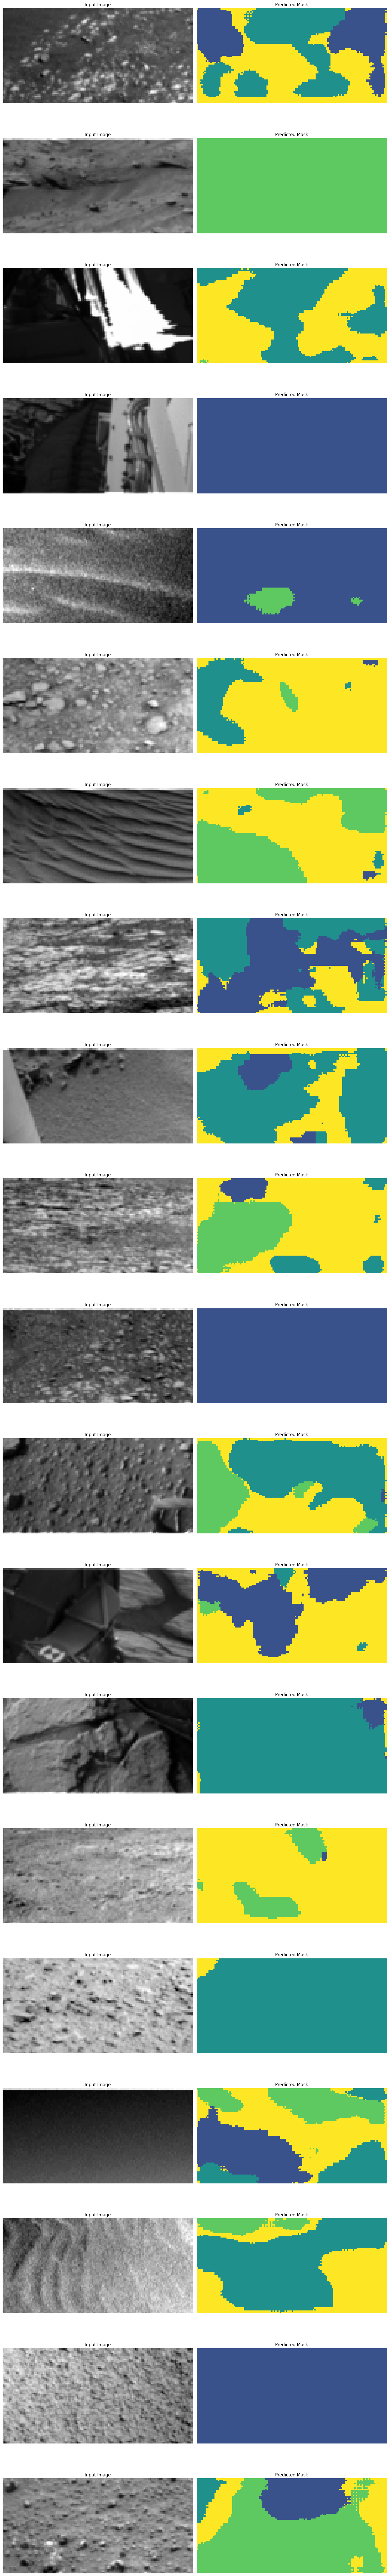

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
# Randomly select 20 indices for prediction
random_indices = np.random.choice(X_test.shape[0], size=20, replace=False)
print(f"Randomly selected indices for prediction (seed=42): {random_indices}")

# Select 20 random samples and their corresponding masks
X_sample = X_test[random_indices]



predicted_masks = preds

# Visualize the predictions
num_images = len(X_sample)  # Number of images to visualize
fig, axes = plt.subplots(num_images, 2, figsize=(15, num_images * 5))

for i in range(num_images):
    # Original Image
    ax_img = axes[i, 0]
    ax_img.imshow(X_sample[i].squeeze(), cmap="gray")
    ax_img.set_title("Input Image")
    ax_img.axis("off")

    # Predicted Mask
    ax_pred = axes[i, 1]
    ax_pred.imshow(predicted_masks[i], cmap="viridis",vmin=0,vmax=4)
    ax_pred.set_title("Predicted Mask")
    ax_pred.axis("off")

plt.tight_layout()
plt.show()

In [98]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [99]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)



In [100]:
len(submission_df.columns)

8193

In [101]:
len(submission_df)

10022

314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step

Class 0:
  Min Probability: 0.0000
  Max Probability: 1.0000
  Mean Probability: 0.3008
  Std Deviation: 0.3288

Class 1:
  Min Probability: 0.0000
  Max Probability: 0.9999
  Mean Probability: 0.2640
  Std Deviation: 0.3692

Class 2:
  Min Probability: 0.0000
  Max Probability: 1.0000
  Mean Probability: 0.2792
  Std Deviation: 0.3762

Class 3:
  Min Probability: 0.0000
  Max Probability: 1.0000
  Mean Probability: 0.1529
  Std Deviation: 0.3059

Class 4:
  Min Probability: 0.0000
  Max Probability: 1.0000
  Mean Probability: 0.0030
  Std Deviation: 0.0358


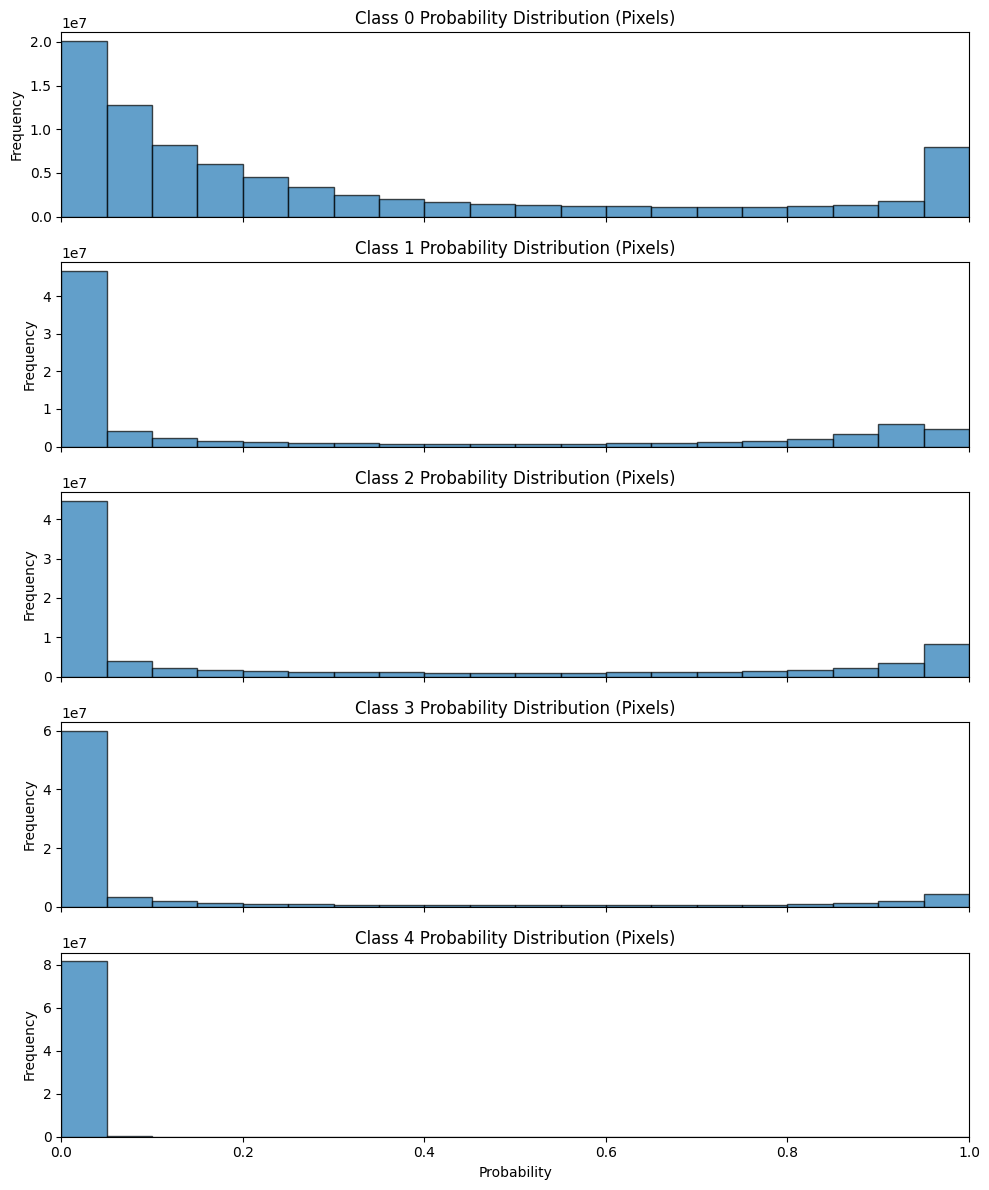

In [102]:
# Step 1: Get model predictions
pred_probs = model.predict(X_test)  # Shape: (num_samples, height, width, num_classes)

# Step 2: Flatten spatial dimensions
flat_probs = pred_probs.reshape(-1, pred_probs.shape[-1])  # Shape: (total_pixels, num_classes)

# Step 3: Calculate statistics
stats = {}
for class_idx in range(flat_probs.shape[1]):
    class_probs = flat_probs[:, class_idx]
    stats[f'Class {class_idx}'] = {
        'Min Probability': np.min(class_probs),
        'Max Probability': np.max(class_probs),
        'Mean Probability': np.mean(class_probs),
        'Std Deviation': np.std(class_probs)
    }

# Print statistics
for class_name, class_stats in stats.items():
    print(f"\n{class_name}:")
    for stat_name, value in class_stats.items():
        print(f"  {stat_name}: {value:.4f}")

# Step 4: Plot histograms
import matplotlib.pyplot as plt

num_classes = pred_probs.shape[-1]
fig, axes = plt.subplots(num_classes, 1, figsize=(10, 12), sharex=True)

for class_idx in range(num_classes):
    # Extract probabilities for the current class
    class_probs = flat_probs[:, class_idx]
    
    # Plot histogram for the current class
    axes[class_idx].hist(class_probs, bins=20, range=(0, 1), alpha=0.7, edgecolor='black')
    axes[class_idx].set_title(f'Class {class_idx} Probability Distribution (Pixels)')
    axes[class_idx].set_ylabel('Frequency')
    axes[class_idx].set_xlim(0, 1)

# Add shared x-axis label
axes[-1].set_xlabel('Probability')
plt.tight_layout()
plt.show()
